<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit

! pip install empiricaldist
from empiricaldist import Pmf, Cdf

In [152]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# R Function
### References:
### https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

### https://medium.com/@rburhum/el-martillazo-y-el-huayno-278716f49938

In [153]:
#@title
# general imports
import numpy as np
import datetime as dt

from joblib import Parallel, delayed

# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
#OPTIMAL_SIGMA = 0.01
OPTIMAL_SIGMA = 0.05

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

    #print(smoothed_cases.to_csv('smoothed_cases'))

    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)

    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())

    #print('End smoothed')
    return original, smoothed_cases
    

def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)

    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    

def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval
    

def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")

    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-05-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

    for i,j in zip(index,values):
        if i in mondays:
            ax.annotate(str(round(j, 2)),xy=(i,j+0.1), arrowprops=dict(facecolor='black', shrink=0.05),) 

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)

    return result

# Doubling-time Function
### References:
### https://github.com/COVID-19-AI-Research-Project/AI-Data-Analysis/blob/master/Projects/1/Prediction_Covid_19_WorldWide.ipynb

###### A large doubling time is good.
###### A constant doubling time - means the measures being taken are effective in controlling the spread
###### An increasing doubling time means - the battle is on winning side
###### A decreasing doubling time-- well danger zone ahead. Do something fast

### https://www.npr.org/sections/health-shots/2020/04/10/829167659/are-we-flattening-the-curve-states-keep-watch-on-coronavirus-doubling-times

In [154]:
def prediction_country2(df1, tipo, plot=True):
    df_final = df1.copy()
    df_country = df_final
    df_country.reset_index(inplace=True)
    
    x=np.array(range(df_country.shape[0]))
    y=df_country[tipo].values
    #print(len(x))

    def func(x,a,b):
        return a*2**(x/b)

    def func1(x, a, b):
        return np.exp(b*(x-a))
  
  
    list_coeff = ['Arequipa']  
    for i in range(10, len(x)+1, 1):
        xdata = x[:i]
        ydata = y[:i]

        try:
            popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata)
        except:
            popt = np.array([0,0])
        
        #print(i, xdata, ydata, popt)
        popt_aux = popt[1]
        popt[1] = np.log(2.)/popt[1]
        list_coeff.append(popt)
  
    if plot:
        fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

        #perc = np.diff(ydata) / ydata[:-1]
        #yfit = popt[0]*2**(xdata/popt[1])
        #perc_fit = np.diff(yfit) / yfit[:-1]

        #tdbl1 = np.log(2.)/popt[1]
        #print('popt1 =', popt, ', doubling time = {:.1f} days\n'.format(tdbl1))

        ax1.set_ylabel('Total infected in '+ 'Arequipa',fontsize=20)
        #ax1.set_yscale('log')
        ax1.plot(df_country[tipo],'--o',ms=10,label='Real Data')
        #ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
        ax1.plot(xdata,func1(xdata, popt[0], popt_aux),'-',label=f'Exponential fit np.exp({popt[1]}*(t-{popt[0]})), \n doubling time = {popt[1]} days')
        ax1.legend(fontsize=15)
        plt.show()

    return list_coeff

def get_country_double(df,country):
    df_coeff2 = df[country].str[-1]
    df_coeff1 = df[country].str[0]
    df_coeff2.dropna(inplace=True)
    df_coeff1.dropna(inplace=True)
    #df_coeff2 = np.log(2.)/df_coeff2.astype(str).astype(float)
    df_coeff2 = df_coeff2.astype(str).astype(float)
    df_coeff1 = df_coeff1.astype(str).astype(float)
    df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
    df_double.columns = ['Coeff1','Doubling Time in Days']
    return df_double

# Funciones Auxiliares

In [155]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-27'), \
           pd.to_datetime('2020-08-03'), pd.to_datetime('2020-08-10'), pd.to_datetime('2020-08-16')]

In [156]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.set_xlabel(labelx,fontsize=15)
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    ax.legend(fontsize=15)

# Load Data

In [157]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

In [158]:
datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
display(datos_arequipa.shape)

0          date total_muestras casos_positivos casos_negativos  \
103  2020-08-12         471217           70558          400597   
104  2020-08-13         480496           72714          407738   
105  2020-08-14         487886           74465          413347   
106  2020-08-15         496331           76299          420006   
107  2020-08-16         502634           77804          424794   

0   espera_resultado defunciones recuperados hospitalizados_positivos  \
103               62        1288       42208                      497   
104               44        1313       43629                      485   
105               74        1332       43905                      486   
106               26        1340       45334                      480   
107               36        1347       46428                      474   

0   hospitalizados_sospechosos uci_positivos uci_sospechosos  \
103                        292            41              28   
104                        302            44              28   
105                        277            43              28   
106                        260            42              27   
107                        294            43              29   

0   defunciones_minsa defunciones_essalud defunciones_clinicas  \
103               478                 744                   15   
104               495                 751                   16   
105               514                 751                   16   
106               522                 751                   16   
107               529                 751                   16   

0   defunciones_domicilio defunciones_sanidades  
103                    41                    10  
104                    41                    10  
105                    41                    10  
106                    41                    10  
107                    41                    10

(108, 16)

# Data Cleaning

In [159]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['weekday'] = datos_arequipa['date'].dt.weekday
datos_arequipa['week'] = datos_arequipa['date'].dt.week
datos_arequipa['year'] = datos_arequipa['date'].dt.year
datos_arequipa.set_index('date', inplace=True)

In [160]:
datos_arequipa.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10',
               '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14',
               '2020-08-15', '2020-08-16'],
              dtype='datetime64[ns]', name='date', length=108, freq=None)

In [161]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2020-05-01 to 2020-08-16
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_muestras              108 non-null    object
 1   casos_positivos             108 non-null    object
 2   casos_negativos             108 non-null    object
 3   espera_resultado            108 non-null    object
 4   defunciones                 108 non-null    object
 5   recuperados                 108 non-null    object
 6   hospitalizados_positivos    108 non-null    object
 7   hospitalizados_sospechosos  108 non-null    object
 8   uci_positivos               108 non-null    object
 9   uci_sospechosos             108 non-null    object
 10  defunciones_minsa           108 non-null    object
 11  defunciones_essalud         108 non-null    object
 12  defunciones_clinicas        108 non-null    object
 13  defunciones_domicilio       108

None

In [162]:
for column in datos_arequipa.columns:
    datos_arequipa[column] = datos_arequipa[column].astype(int)

In [163]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2020-05-01 to 2020-08-16
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_muestras              108 non-null    int64
 1   casos_positivos             108 non-null    int64
 2   casos_negativos             108 non-null    int64
 3   espera_resultado            108 non-null    int64
 4   defunciones                 108 non-null    int64
 5   recuperados                 108 non-null    int64
 6   hospitalizados_positivos    108 non-null    int64
 7   hospitalizados_sospechosos  108 non-null    int64
 8   uci_positivos               108 non-null    int64
 9   uci_sospechosos             108 non-null    int64
 10  defunciones_minsa           108 non-null    int64
 11  defunciones_essalud         108 non-null    int64
 12  defunciones_clinicas        108 non-null    int64
 13  defunciones_domicilio       108 non-null    in

None

# Data Pre-processing


In [164]:
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['recuperados_diarios'] = datos_arequipa['recuperados'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['hospitalizados_positivos_diarios'] = datos_arequipa['hospitalizados_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['uci_positivos_diarios'] = datos_arequipa['uci_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa['mesdia'] = datos_arequipa.index.strftime('%m-%d')
datos_arequipa['activos'] = datos_arequipa.casos_positivos - \
                            datos_arequipa.defunciones - \
                            datos_arequipa.recuperados 

datos_arequipa.tail()

0           total_muestras  casos_positivos  casos_negativos  \
date                                                           
2020-08-12          471217            70558           400597   
2020-08-13          480496            72714           407738   
2020-08-14          487886            74465           413347   
2020-08-15          496331            76299           420006   
2020-08-16          502634            77804           424794   

0           espera_resultado  defunciones  recuperados  \
date                                                     
2020-08-12                62         1288        42208   
2020-08-13                44         1313        43629   
2020-08-14                74         1332        43905   
2020-08-15                26         1340        45334   
2020-08-16                36         1347        46428   

0           hospitalizados_positivos  hospitalizados_sospechosos  \
date                                                               
2020-08-12                       497                         292   
2020-08-13                       485                         302   
2020-08-14                       486                         277   
2020-08-15                       480                         260   
2020-08-16                       474                         294   

0           uci_positivos  uci_sospechosos  defunciones_minsa  \
date                                                            
2020-08-12             41               28                478   
2020-08-13             44               28                495   
2020-08-14             43               28                514   
2020-08-15             42               27                522   
2020-08-16             43               29                529   

0           defunciones_essalud  defunciones_clinicas  defunciones_domicilio  \
date                                                                           
2020-08-12                  744                    15                     41   
2020-08-13                  751                    16                     41   
2020-08-14                  751                    16                     41   
2020-08-15                  751                    16                     41   
2020-08-16                  751                    16                     41   

0           defunciones_sanidades  dia  weekday  week  year  muestras_diarias  \
date                                                                            
2020-08-12                     10  103        2    33  2020              7998   
2020-08-13                     10  104        3    33  2020              9279   
2020-08-14                     10  105        4    33  2020              7390   
2020-08-15                     10  106        5    33  2020              8445   
2020-08-16                     10  107        6    33  2020              6303   

0           confirmados_diarios  fallecidos_diarios  recuperados_diarios  \
date                                                                       
2020-08-12                 1964                  39                 1739   
2020-08-13                 2156                  25                 1421   
2020-08-14                 1751                  19                  276   
2020-08-15                 1834                   8                 1429   
2020-08-16                 1505                   7                 1094   

0           hospitalizados_positivos_diarios  uci_positivos_diarios  \
date                                                                  
2020-08-12                                60                      4   
2020-08-13                               -12                      3   
2020-08-14                                 1                     -1   
2020-08-15                                -6                     -1   
2020-08-16                                -6                      1   

0           positividad mesdia  activos  
date     

# Plots - Test, Confirmados, Fallecidos

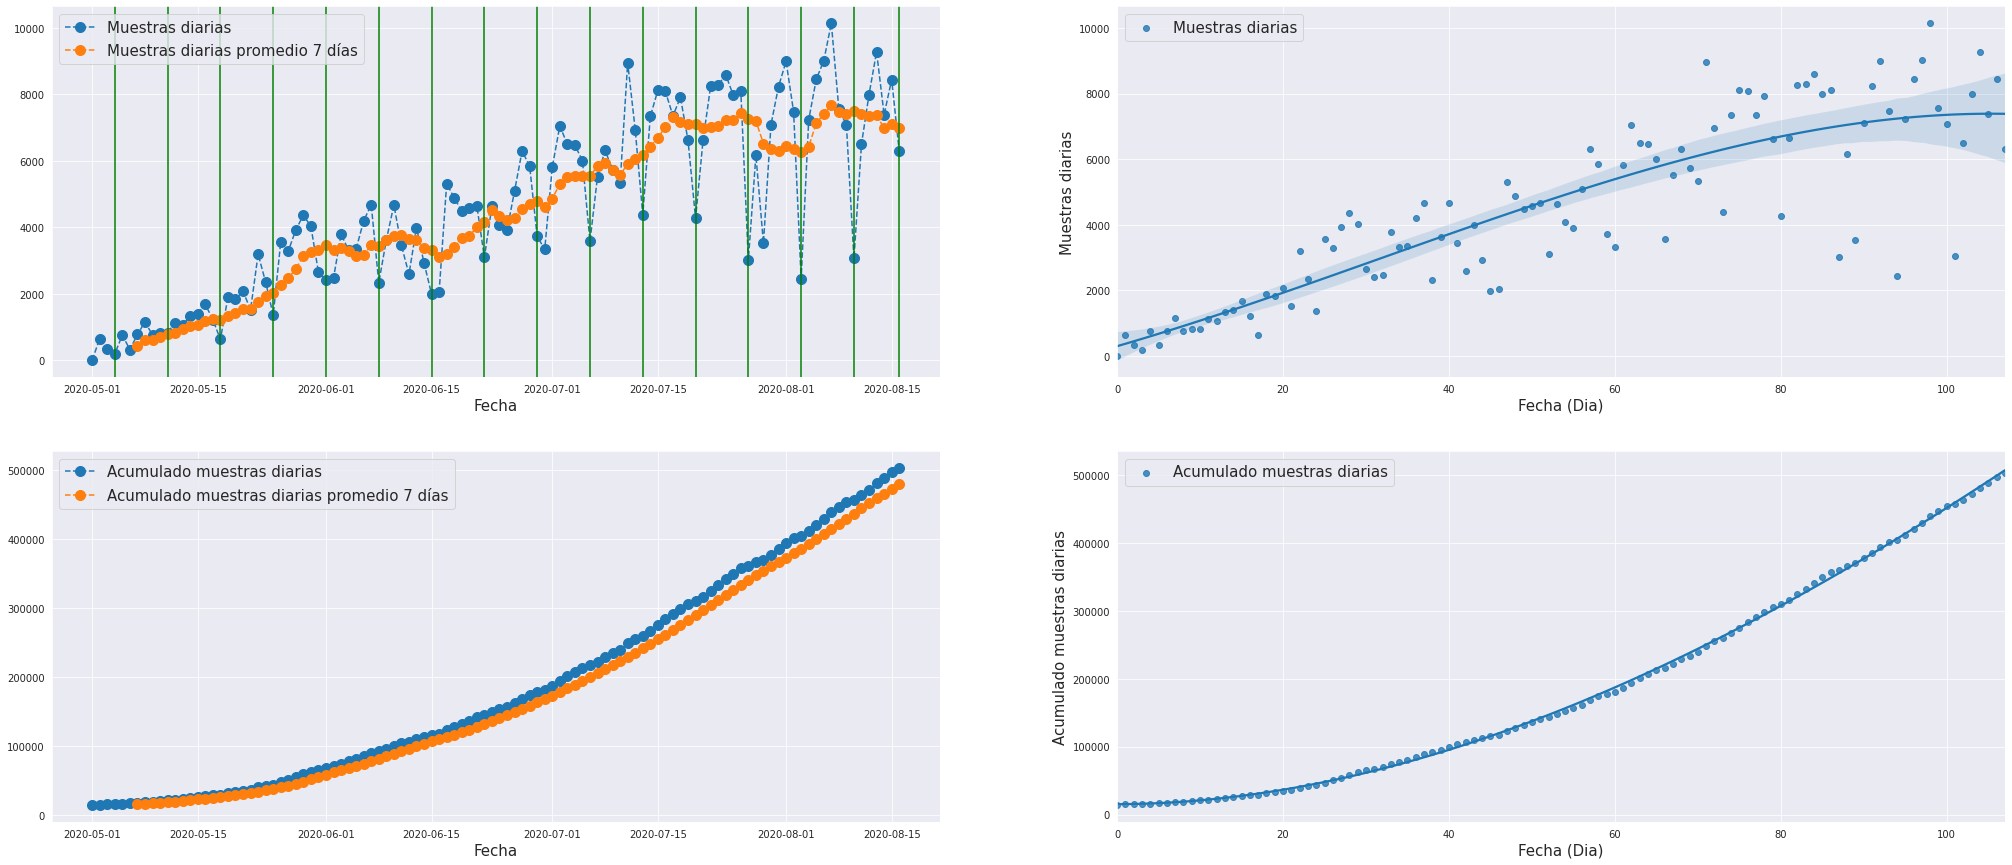

In [165]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Muestras diarias', 'muestras_diarias')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Muestras diarias', 'dia', 'muestras_diarias')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Acumulado muestras diarias', 'total_muestras')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Acumulado muestras diarias', 'dia', 'total_muestras')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_1.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de pruebas diarias esta aumentando, lo que en realidad es un factor positivo.***



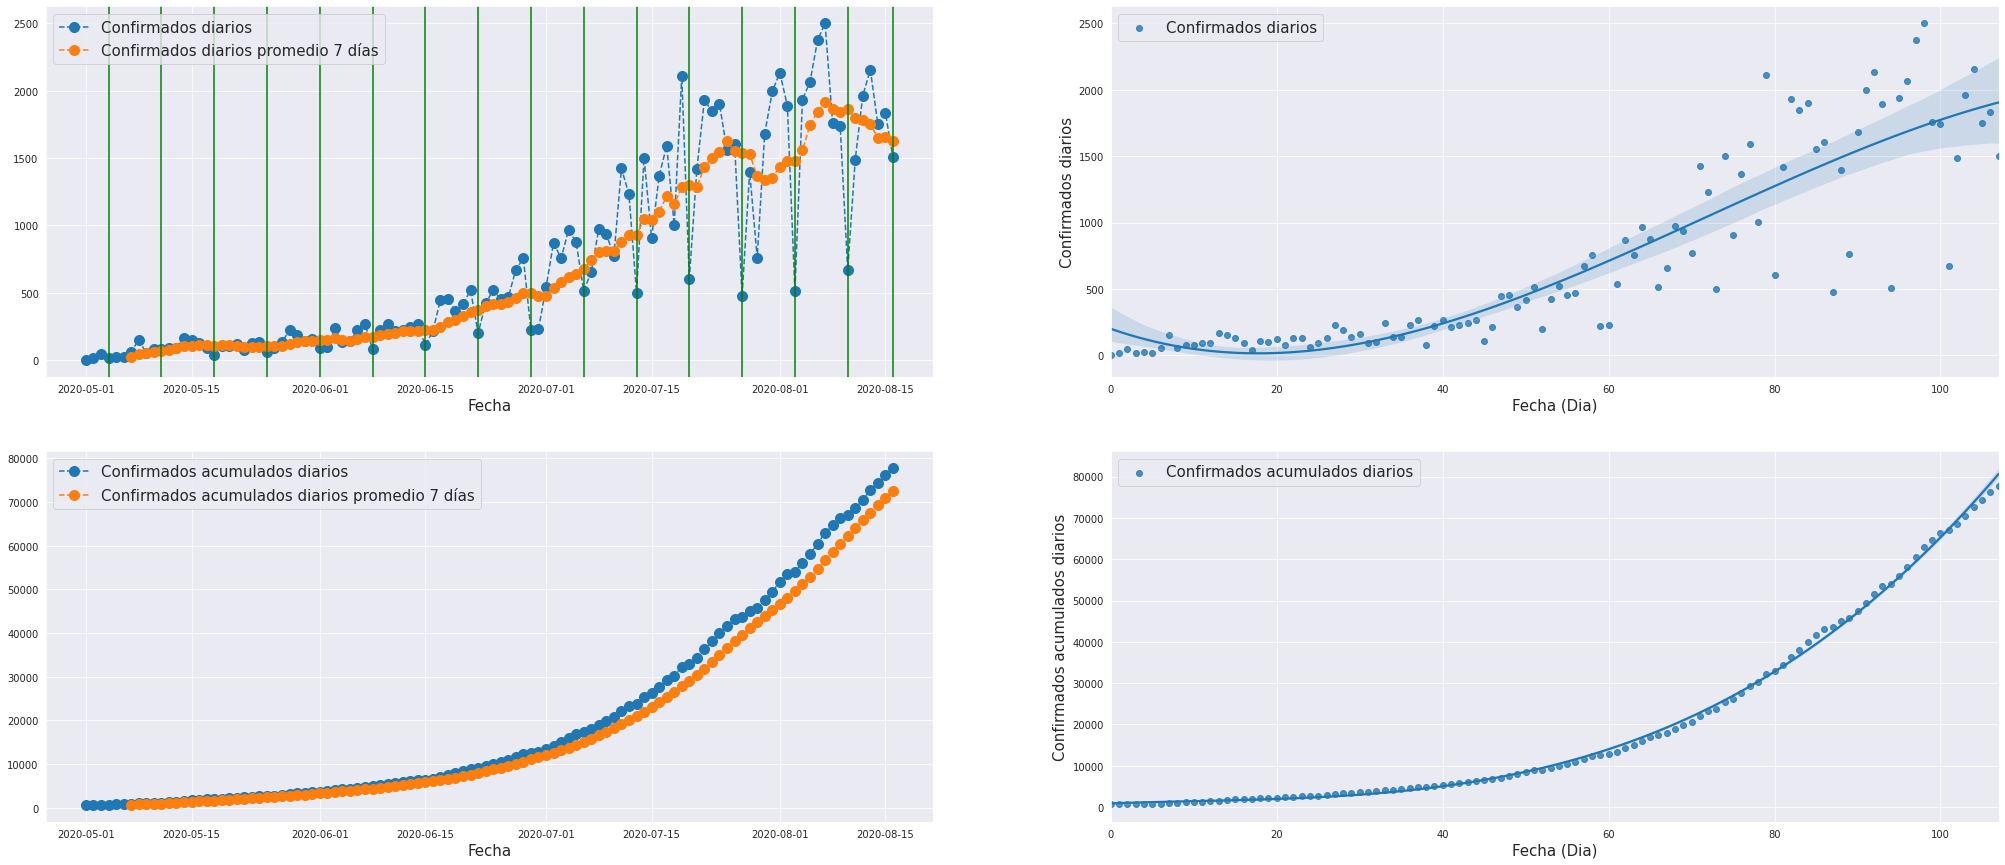

In [166]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados diarios', 'confirmados_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados diarios', 'dia', 'confirmados_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados acumulados diarios', 'casos_positivos')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados acumulados diarios', 'dia', 'casos_positivos')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_2.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de casos positivos también esta aumentando. Haciendo un análisis de regresión, la tendencia es que vaya en aumento.***

***Actualización(2020-07-28): La tendencia de los últimos días es que los contagios llegaron a estabilizarse.***

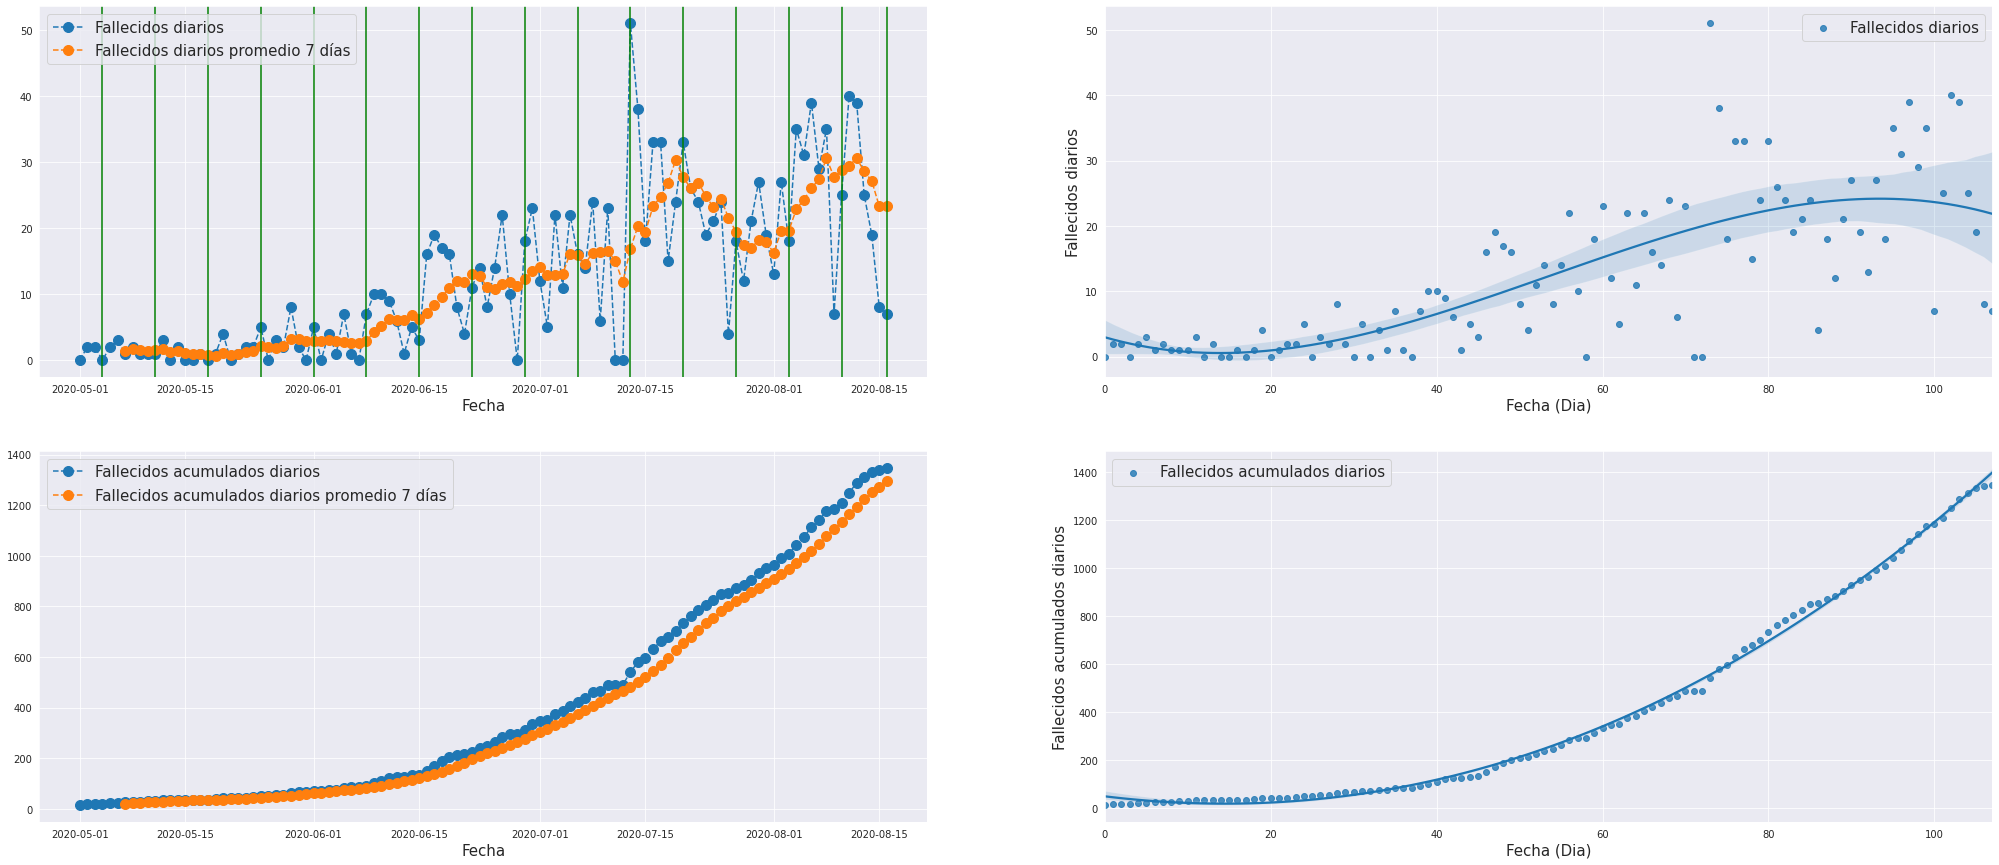

In [167]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos diarios', 'fallecidos_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos diarios', 'dia', 'fallecidos_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos acumulados diarios', 'defunciones')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos acumulados diarios', 'dia', 'defunciones')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_3.png')
plt.show()

***CONCLUSIONES: Se puede observar como el número de fatalidades también esta aumentando. Haciendo un análisis de regresión, la tendencia es que vaya en aumento pero la pendiente no es tan elevada.***

***Actualización(2020-07-28): El número de fallecidos esta disminuyendo diariamente.***

# Positividad

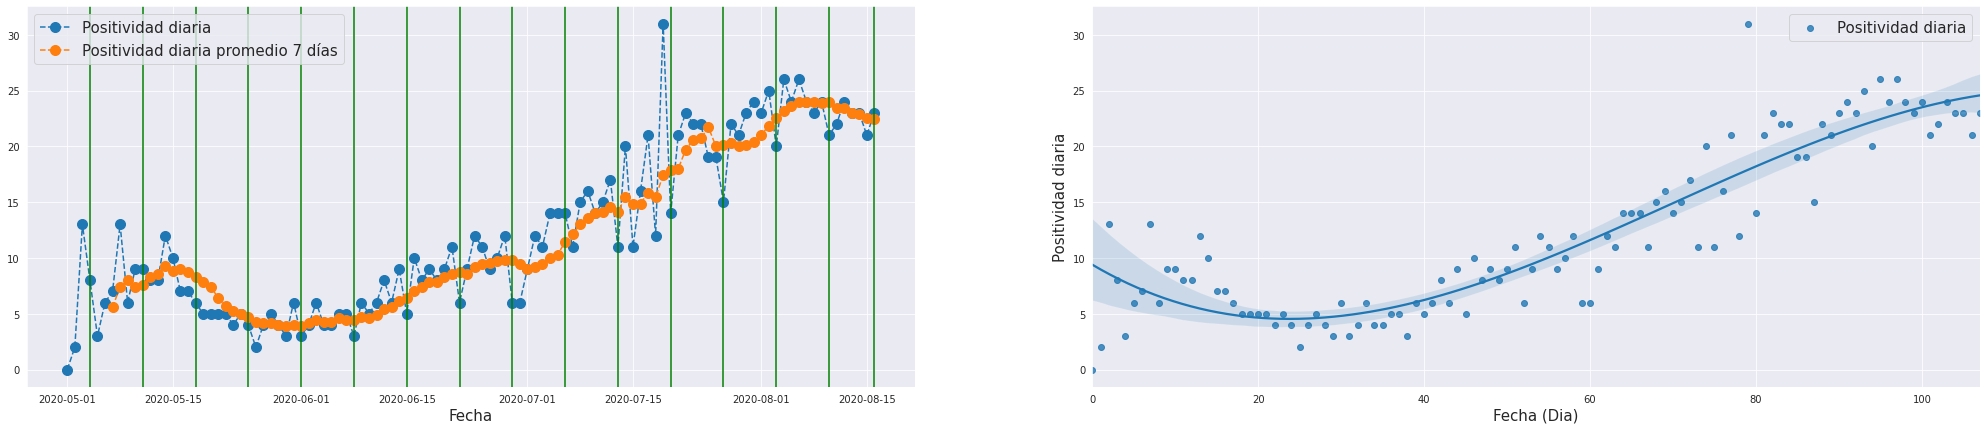

In [168]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Positividad diaria', 'positividad')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Positividad diaria', 'dia', 'positividad')

for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_4.png')
plt.show()

# Factor Salud - Hospitalizados y UCI

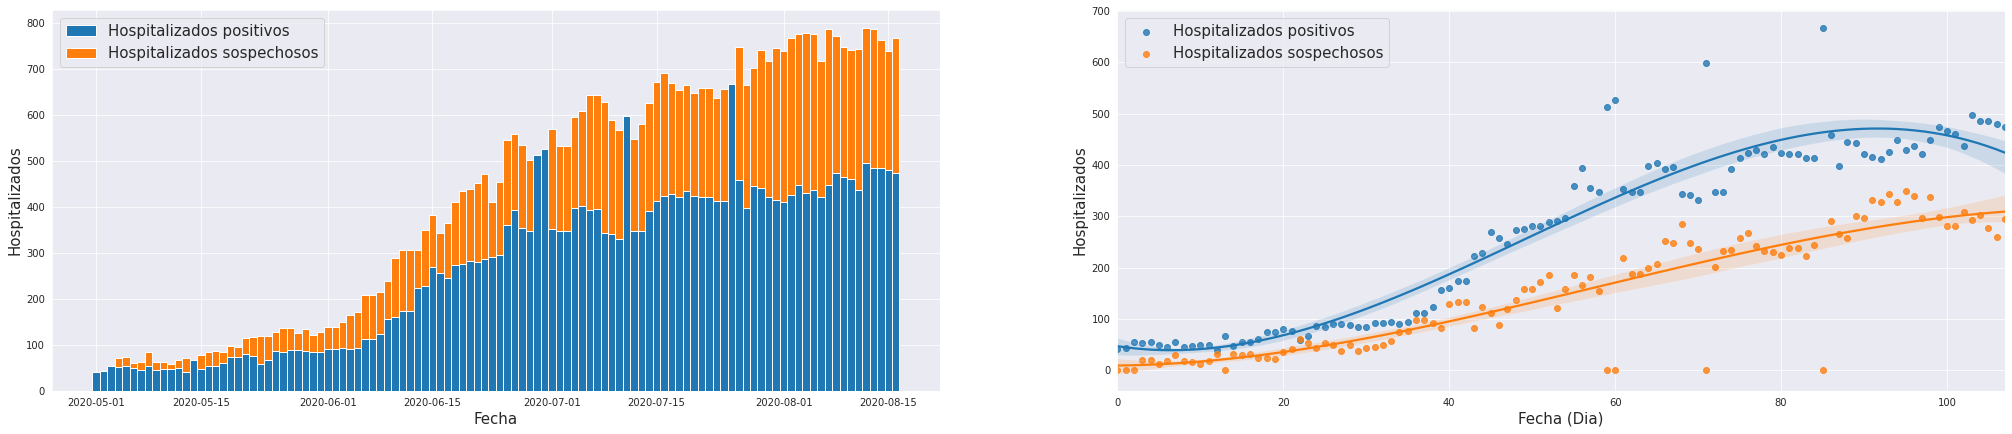

<Figure size 432x288 with 0 Axes>

In [169]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'Hospitalizados', 'index', 'hospitalizados')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'Hospitalizados', 'dia', 'hospitalizados')

plt.savefig('image_5.png')
plt.show()
plt.clf()


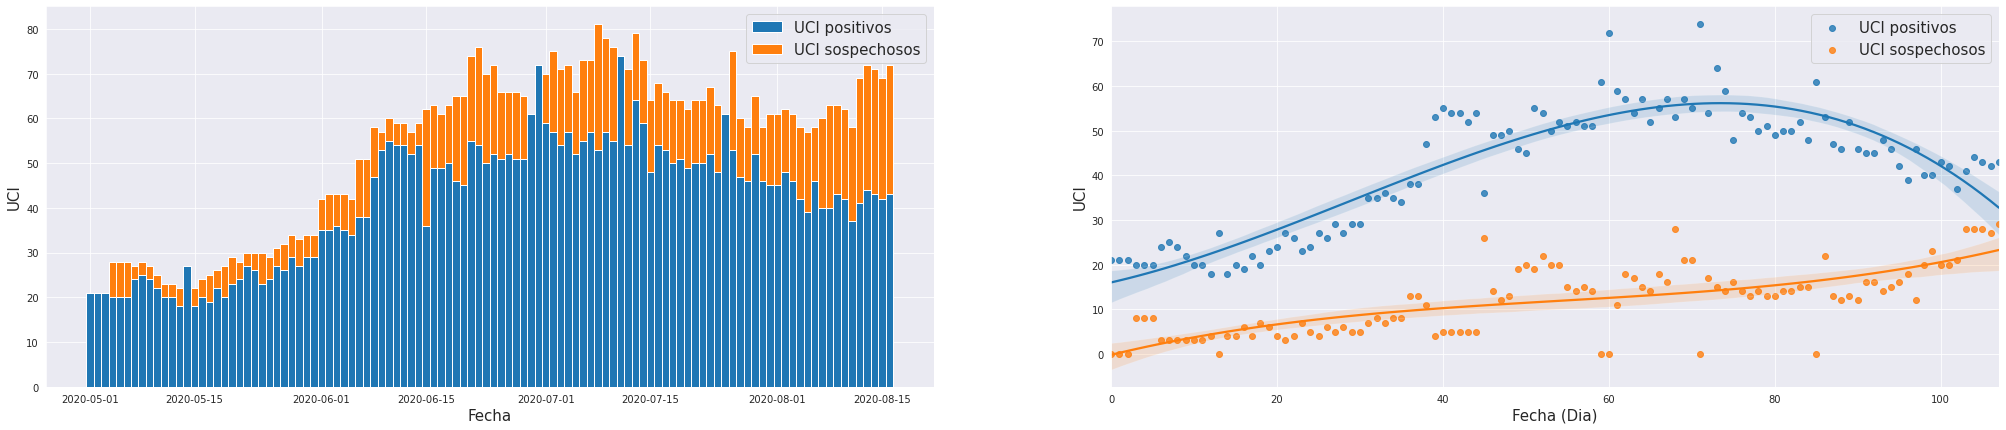

<Figure size 432x288 with 0 Axes>

In [170]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'UCI', 'index', 'uci')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'UCI', 'dia', 'uci')

plt.savefig('image_6.png')
plt.show()
plt.clf()

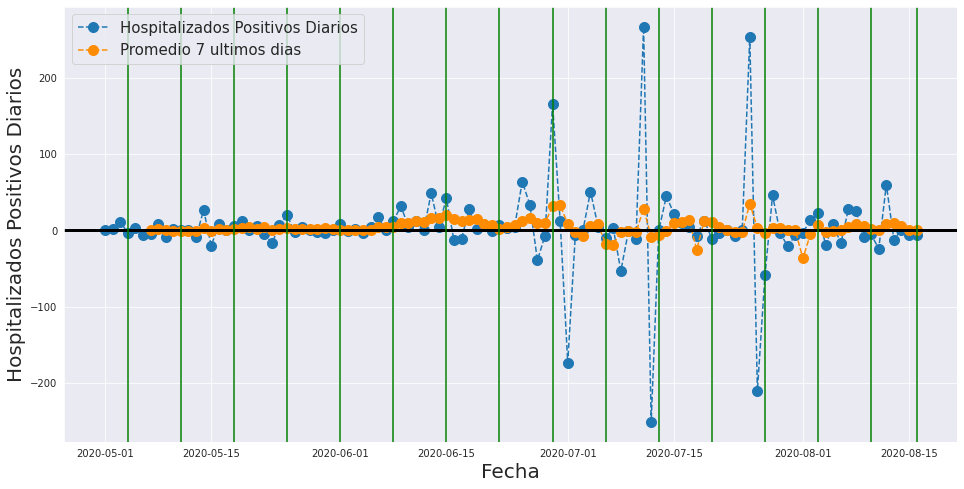

In [171]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Hospitalizados Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'],'--o',ms=10,label='Hospitalizados Positivos Diarios')
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)

plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_7.png')
plt.show()

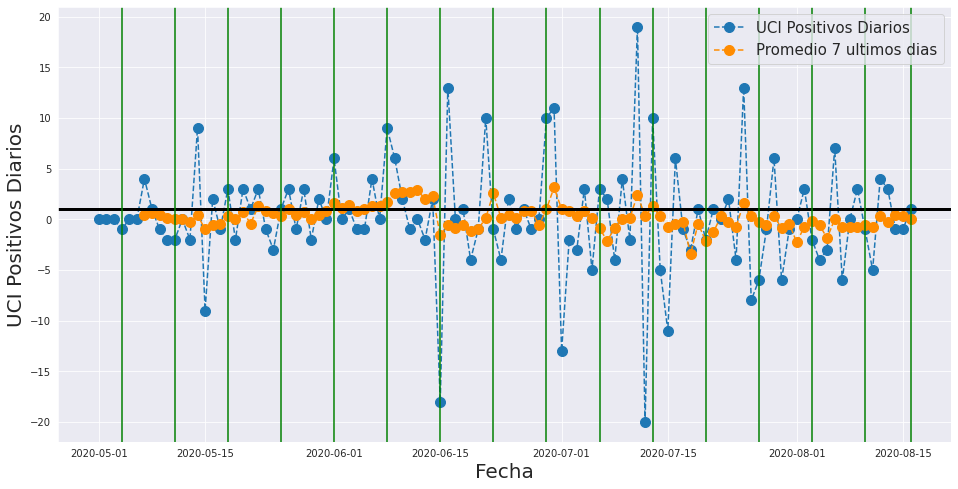

In [172]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

ax1.set_ylabel('UCI Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['uci_positivos_diarios'],'--o',ms=10,label='UCI Positivos Diarios')
ax1.plot(datos_arequipa['uci_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)

plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')

plt.savefig('image_8.png')
plt.show()

***CONCLUSIONES: Este es una de las principales métricas y se ve que la positividad va a aumentar y estará entre un 17 y 23% en las proximas semanas.***

***Actualización(2020-07-28): La positividad empezó a estabilizarse.***

# R Factor - Confirmados

In [173]:
r_confirmados_arequipa = datos_arequipa.loc[:,['confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index([r_confirmados_arequipa.index, 'state'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']
display(r_confirmados_arequipa)
r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)

date        state   
2020-05-01  AREQUIPA       0
2020-05-02  AREQUIPA      19
2020-05-03  AREQUIPA      45
2020-05-04  AREQUIPA      16
2020-05-05  AREQUIPA      26
2020-05-06  AREQUIPA      21
2020-05-07  AREQUIPA      59
2020-05-08  AREQUIPA     153
2020-05-09  AREQUIPA      52
2020-05-10  AREQUIPA      81
2020-05-11  AREQUIPA      81
2020-05-12  AREQUIPA      93
2020-05-13  AREQUIPA      92
2020-05-14  AREQUIPA     165
2020-05-15  AREQUIPA     151
2020-05-16  AREQUIPA     130
2020-05-17  AREQUIPA      90
2020-05-18  AREQUIPA      38
2020-05-19  AREQUIPA     105
2020-05-20  AREQUIPA     104
2020-05-21  AREQUIPA     121
2020-05-22  AREQUIPA      76
2020-05-23  AREQUIPA     128
2020-05-24  AREQUIPA     132
2020-05-25  AREQUIPA      61
2020-05-26  AREQUIPA      93
2020-05-27  AREQUIPA     134
2020-05-28  AREQUIPA     225
2020-05-29  AREQUIPA     189
2020-05-30  AREQUIPA     139
2020-05-31  AREQUIPA     159
2020-06-01  AREQUIPA      93
2020-06-02  AREQUIPA     101
2020-06-03  AREQUIPA  

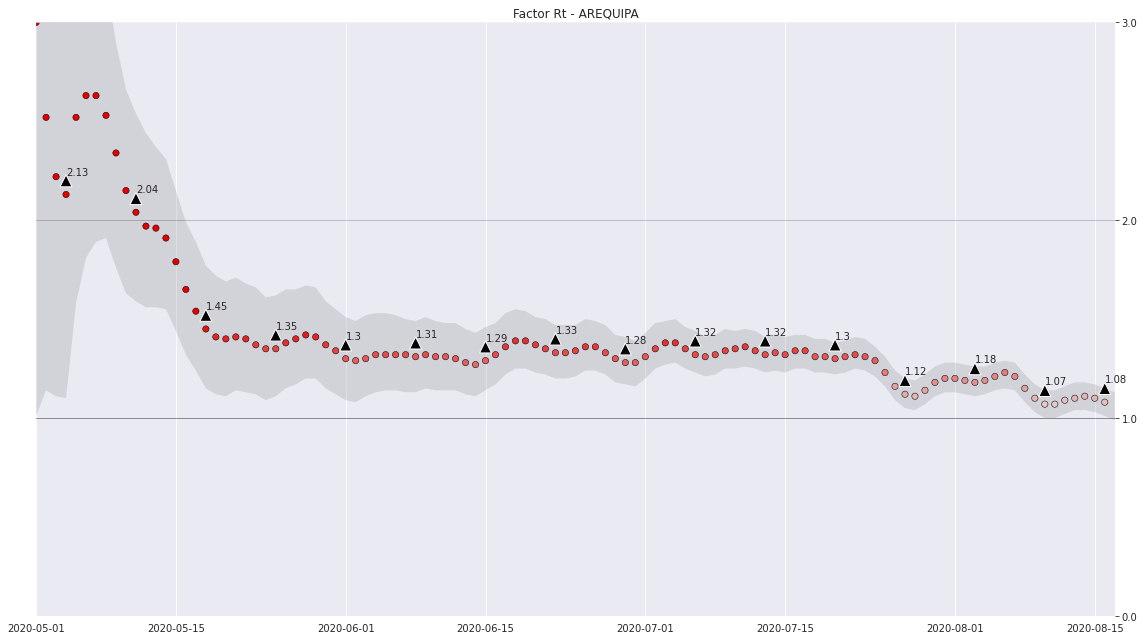

<Figure size 432x288 with 0 Axes>

In [174]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_confirmados, ax, 'Factor Rt - AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('image_9.png')
plt.show()
plt.clf()

***CONCLUSIONES: Este es otra de las principales métricas y se ve que el Factor R se mantiene constante entre 1.3 y 1.4. Este dato es muy preocupante debido a que otros estudios realizados con los datos de todo el país, el tiempo para que este valor este por debajo de 1 es más de un mes. Esto indica a que los contagios no estaran controlados en mínimo un 1 hacia adelante.***

***Actualización(2020-07-28): El factor R esta disminuyendo rapidamente, esto es sumamente bueno.***

# R Factor - Fallecidos

In [175]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index([r_fallecidos_arequipa.index, 'state'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']

r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

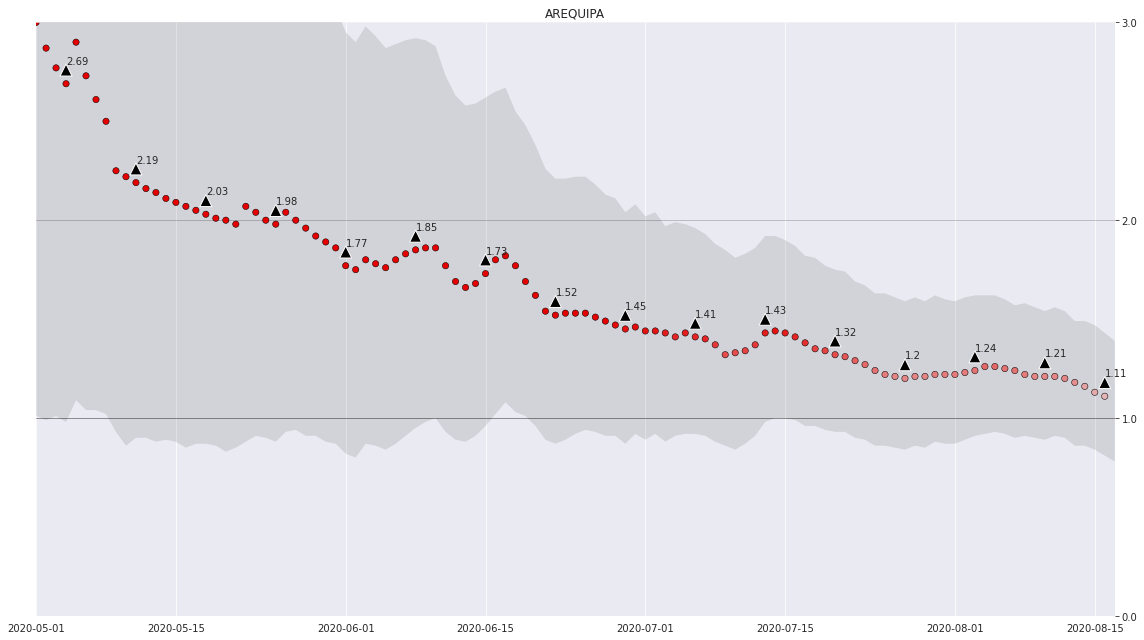

<Figure size 432x288 with 0 Axes>

In [176]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

# Plot doubling-time: Casos Positivos

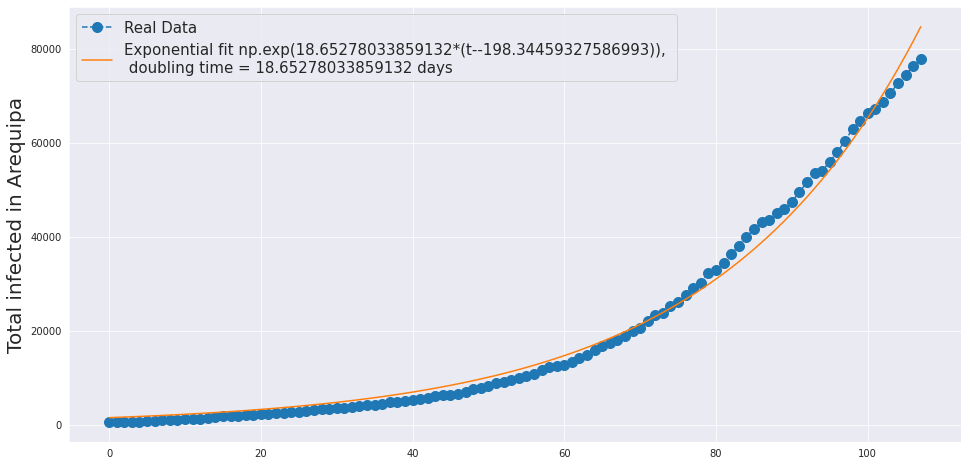

In [177]:
List = []
coeff = prediction_country2(datos_arequipa,'casos_positivos',plot=True)
List.append(coeff)

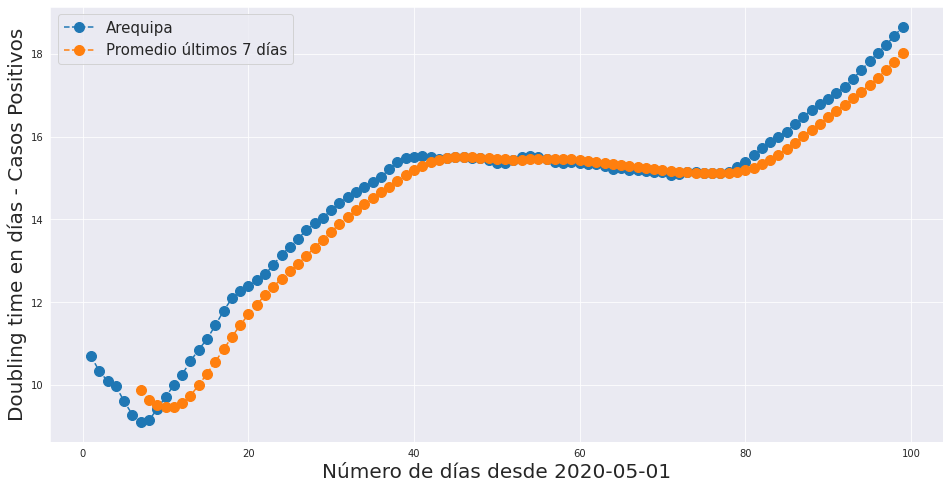

In [178]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - Casos Positivos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
plt.savefig('image_10.png')
plt.show()

***CONCLUSIONES: Esta métrica mide el número de días que los contagios se duplicarán. Con los datos actuales de Arequipa se puede observar que los contagios se duplican cada 15 días. Mientras este valor aumente las medidas en que se están tomando son las adecuadas, pero el caso es totalmente contrario en Arequipa donde la tendencia es a disminuir.***

***Actualización(2020-07-28): Por fin se puede apreciar una tendencia a subir este factor, se espera mucho más.***

# Plot doubling-time: Fallecidos

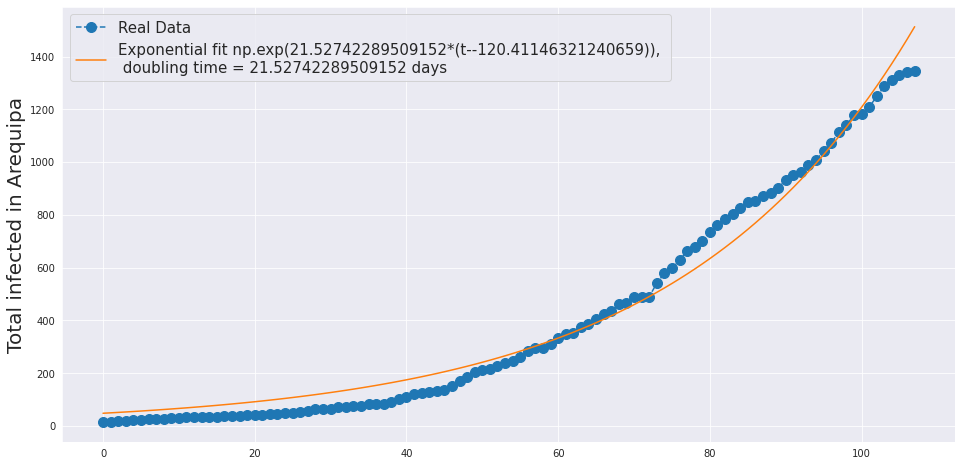

In [179]:
List = []
coeff = prediction_country2(datos_arequipa,'defunciones',plot=True)
List.append(coeff)

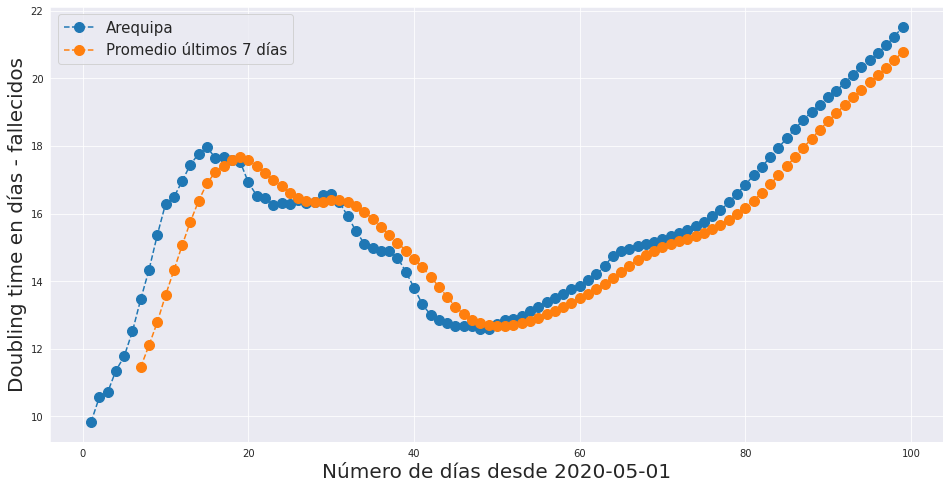

In [180]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - fallecidos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
plt.savefig('image_11.png')
plt.show()

***CONCLUSIONES: Esta métrica mide el número de días que las fatalidades se duplicarán. Con los datos actuales de Arequipa se puede observar que las fatalidades se duplican también cada 15 días. Caso contrario a los contagios, la tendencia de esta métrica en las fatalidades esta aumentando y ese es un factor positivo.***

***Actualización(2020-07-28): Este factor en fallecidos pasó de 15 a 17 días, son excelentes noticias.***

# Plots - Defunciones, Activos, Recuperados

In [181]:
data_map_arequipa = datos_arequipa.loc[:,['casos_positivos', 'defunciones','recuperados','activos','dia']]
data_map_arequipa['hito1'] = data_map_arequipa['defunciones']
data_map_arequipa['hito2'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos']
data_map_arequipa['hito3'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos'] + data_map_arequipa['recuperados']
data_map_arequipa.tail()

0           casos_positivos  defunciones  recuperados  activos  dia  hito1  \
date                                                                         
2020-08-12            70558         1288        42208    27062  103   1288   
2020-08-13            72714         1313        43629    27772  104   1313   
2020-08-14            74465         1332        43905    29228  105   1332   
2020-08-15            76299         1340        45334    29625  106   1340   
2020-08-16            77804         1347        46428    30029  107   1347   

0           hito2  hito3  
date                      
2020-08-12  28350  70558  
2020-08-13  29085  72714  
2020-08-14  30560  74465  
2020-08-15  30965  76299  
2020-08-16  31376  77804

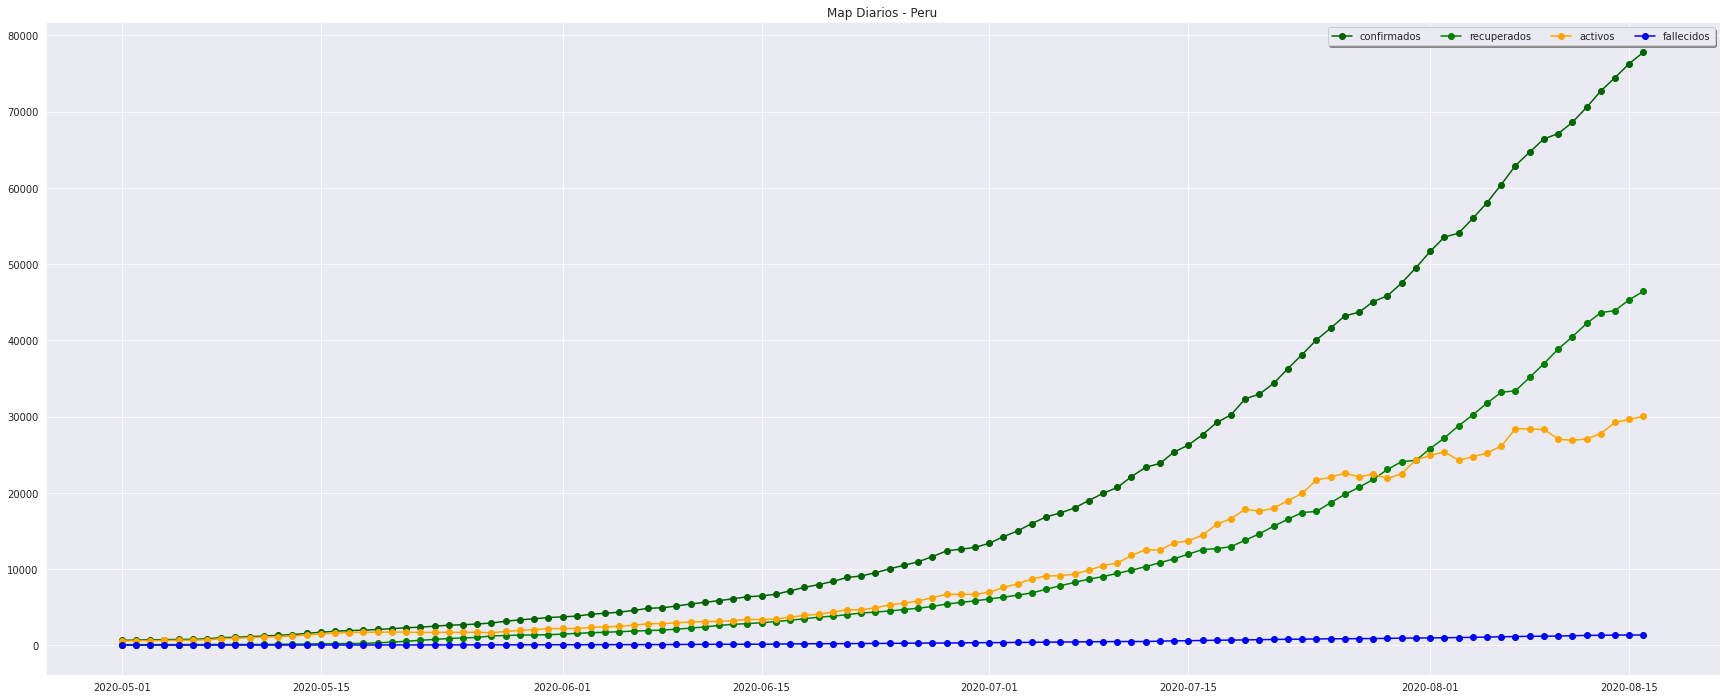

<Figure size 432x288 with 0 Axes>

In [182]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

colors = ['darkgreen', 'green', 'orange', 'blue']
labels = ['confirmados', 'recuperados', 'activos', 'fallecidos']

ax1.plot_date(data_map_arequipa.index, data_map_arequipa['casos_positivos'], color=colors[0], label=labels[0], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['recuperados'], color=colors[1], label=labels[1], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['activos'], color=colors[2], label=labels[2], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['defunciones'], color=colors[3], label=labels[3], linestyle="-")

ax1.set(title='Map Diarios - Peru')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.savefig('image_12.png')
plt.show()
plt.clf()

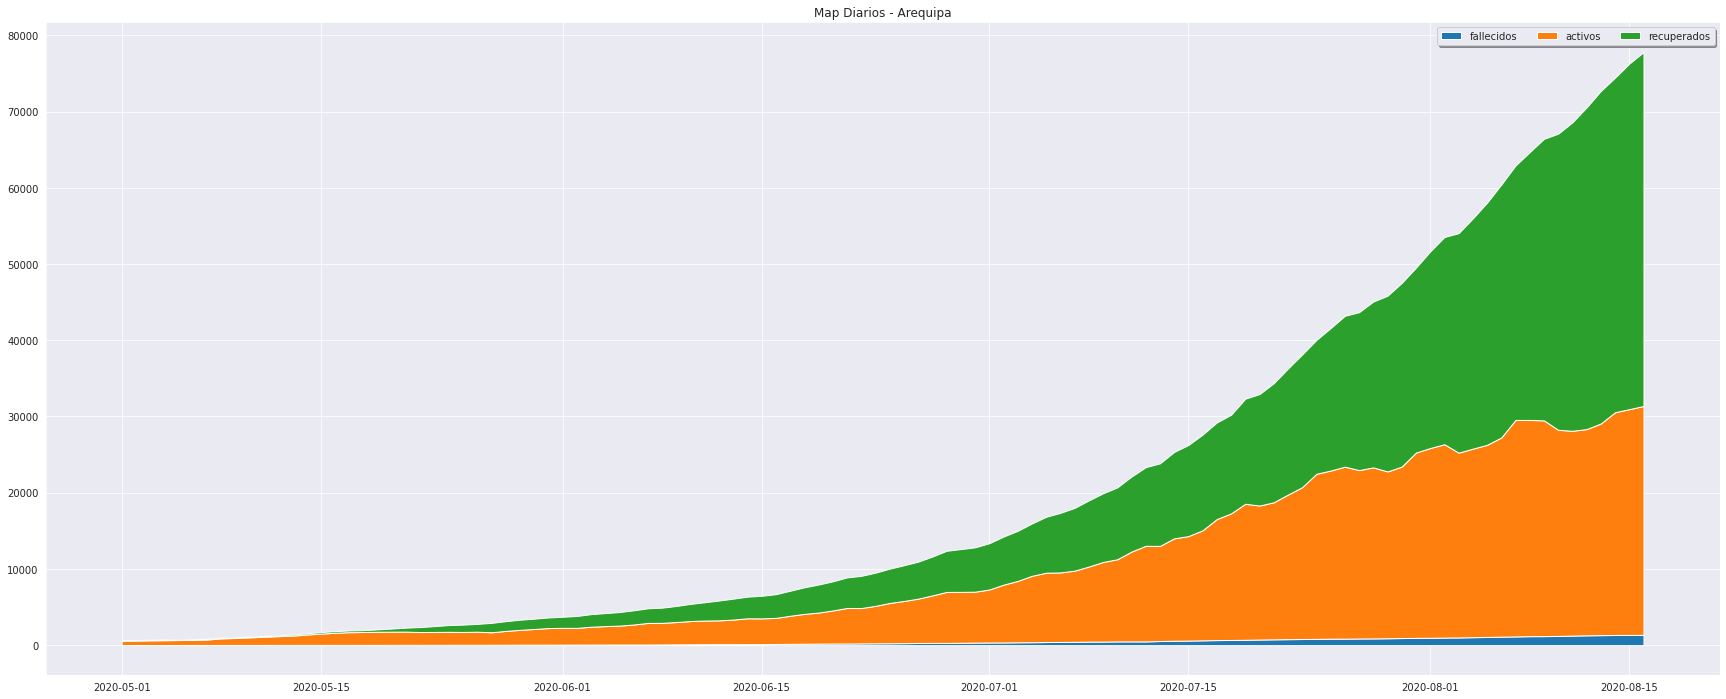

<Figure size 432x288 with 0 Axes>

In [183]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

x1 = data_map_arequipa.index
x2 = data_map_arequipa['hito1']
x3 = data_map_arequipa['hito2']
x4 = data_map_arequipa['hito3']

ax1.fill_between(x1, 0, x2, label='fallecidos')
ax1.fill_between(x1, x2, x3, label='activos')
ax1.fill_between(x1, x3, x4, label='recuperados')

ax1.set(title='Map Diarios - Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.savefig('image_13.png')
plt.show()
plt.clf()

***CONCLUSIONES: En este gráfico se puede ver, que a diferencia de los datos de todo el Perú, el area de los activos son más que los recuperados.***

***Actualización(2020-07-28): Ya casi la cantidad de recuperados es el mismo a los contagiados. Esto no significa que todas las personas contagiadas ya están recuperadas, sino que el número de recuperadas acumuladas esta por alcanzar al número de personas contagiadas acumuladas.***

#Plots - Confirmados diarios vs Recuperados diarios

In [184]:
daily_confirmados_vs_recuperados = datos_arequipa.loc[:,['confirmados_diarios','recuperados_diarios']]
daily_confirmados_vs_recuperados['diario_c_vs_r'] = daily_confirmados_vs_recuperados.recuperados_diarios / \
                                                    daily_confirmados_vs_recuperados.confirmados_diarios

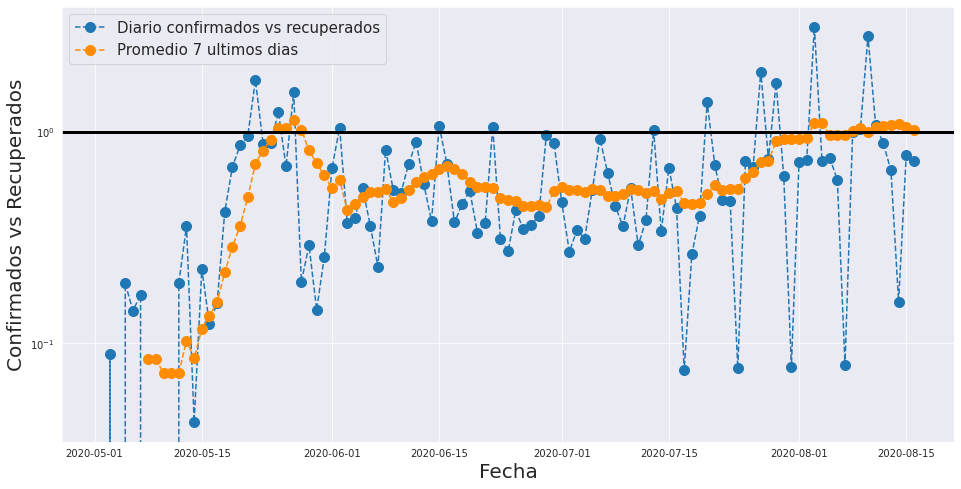

In [185]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Confirmados vs Recuperados',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
#ax1.bar(daily_confirmados_vs_recuperados.index, daily_confirmados_vs_recuperados['diario_c_vs_r'],label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'],'--o',ms=10,label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
ax1.set_yscale('log')

plt.axhline(1, color='k',lw=3)

plt.savefig('image_14.png')
plt.show()

***CONCLUSIONES: En este gráfico se puede ver que solo entre el 20 y el 25 de Mayo la tasa de recuperados supero a la de contagiados, luego las tasa de recuperados es inferior a los contagiados.***

***Actualización(2020-07-28): El promedio de los últimos 7 días esta aumentando, que excelente.***

# SIR Function

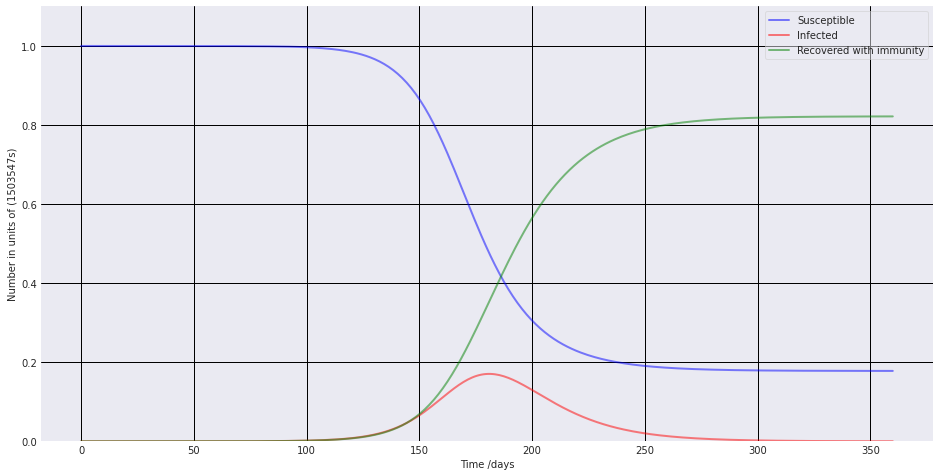

In [186]:
from scipy.integrate import odeint

# Total population, Arequipa
N = 1503547
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/14    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 360, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(16,8))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('image_15.png')
plt.show()

***CONCLUSIONES: Esta función grafíca el comportamiento del coronavirus con los datos de Arequipa. Los datos importantes son:***

1.   Poblacion de Arequipa: 1503547
2.   Contact rate (beta) : Diversos estudios catalogarón que en esta pandemia este valor se encontraría entre 0.2 y 0.3. (Se necesita mas investigación pero en caso del Perú un beta de 0.15 gráfica mejor la situación actual).
3.   Mean recovery rate (gamma): Básicamente este valor es 1/<Periodo de incubación>. Este dato para Perú es de 14 días.

Se puede observar que el límite de contagios en Arequipa llegaría en aproximadamente al día 170 y 180 que se inició la pandemia. Esto sería en un mes aproximadamente.

***Actualización(2020-07-28): Según todas las métricas, puede que se llegue al pico de contagiados algunas semanas antes de lo esperado.***


# Análisis por días de contagio


***Para realizar este estudio utilizaremos los datos del MINSA (Ministerio de Salud), recordando siempre que existen un deficit en el total de contagios reales vs reportados a esta institución***

In [187]:
url = 'https://www.datosabiertos.gob.pe/node/6447/download/positivos_covid.csv'
#url = 'positivos_covid.csv'

datos_minsa = pd.read_csv(url, encoding = "ISO-8859-1") 

In [188]:
# Si el archivo fue descargado ejecutar esta celda y comentar la tercera linea de la celda siguiente
########################################################################
datos_minsa.sort_values('FECHA_RESULTADO', inplace=True)
datos_minsa.dropna(inplace=True)
datos_minsa['FECHA_RESULTADO'] = datos_minsa['FECHA_RESULTADO'].astype(str)
datos_minsa.reset_index(drop=True, inplace=True)
datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'].apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8]))

In [189]:
datos_minsa['EDAD'] = datos_minsa['EDAD'].fillna(0)
datos_minsa['EDAD'] = datos_minsa['EDAD'].astype('int')
#datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'], dayfirst=True)

datos_minsa = datos_minsa.apply(lambda x: x.str.upper() if x.dtype == "object" else x)  

In [190]:
display(datos_minsa.info())
display(datos_minsa.sort_values('FECHA_RESULTADO'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507935 entries, 0 to 507934
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             507935 non-null  object        
 1   DEPARTAMENTO     507935 non-null  object        
 2   PROVINCIA        507935 non-null  object        
 3   DISTRITO         507935 non-null  object        
 4   METODODX         507935 non-null  object        
 5   EDAD             507935 non-null  int64         
 6   SEXO             507935 non-null  object        
 7   FECHA_RESULTADO  507935 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 31.0+ MB


None

UUID DEPARTAMENTO PROVINCIA  \
0       BC4631746D3B54D2270F1F4EAFDF2754         LIMA      LIMA   
1       BE47724AAC01F72F2FCA6C8978E3A1A4         LIMA      LIMA   
2       C86252FD8C5F241509CD1B9AB239C3D3         LIMA      LIMA   
3       A387EBDB0C991006681A4BC98F0551BA         LIMA      LIMA   
4       73A8E86613CED65AC8F6A2F9385613F0         LIMA      LIMA   
...                                  ...          ...       ...   
504552  41CAD53C893F15F4A4073AE53E604565         LIMA      LIMA   
504551  AC67E4AB2D7D6320CDAC7C333A924228         LIMA      LIMA   
504550  ECCF2D80CB08494D4D5137D5F8B2D1EF         LIMA      LIMA   
504557  BF9508AF30AA97928B46D6B79C8EC2EB         LIMA      LIMA   
507934  33B9DD41260ABDEA35C825FA928D0728         LIMA      LIMA   

                 DISTRITO METODODX  EDAD       SEXO FECHA_RESULTADO  
0               LA MOLINA      PCR    25  MASCULINO      2020-03-06  
1       SANTIAGO DE SURCO      PCR    51  MASCULINO      2020-03-07  
2       SANTIAGO DE SURCO      PCR    25  MASCULINO      2020-03-07  
3       SANTIAGO DE SURCO      PCR     7  MASCULINO      2020-03-07  
4       SANTIAGO DE SURCO      PCR    74   FEMENINO      2020-03-07  
...                   ...      ...   ...        ...             ...  
504552        JESUS MARIA      PCR    37   FEMENINO      2020-08-12  
504551              COMAS      PCR    39  MASCULINO      2020-08-12  
504550      INDEPENDENCIA      PCR    40  MASCULINO      2020-08-12  
504557         LOS OLIVOS      PCR    67   FEMENINO      2020-08-12  
507934      PUENTE PIEDRA      PCR    24   FEMENINO      2020-08-12  

[507935 rows x 8 columns]

In [191]:
datos_minsa_cut = datos_minsa.query('FECHA_RESULTADO >= \"2020-03-29\"')

In [192]:
datos_minsa_cut = datos_minsa_cut.reset_index(drop=True)
display(datos_minsa_cut.info())
display(datos_minsa_cut.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507141 entries, 0 to 507140
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             507141 non-null  object        
 1   DEPARTAMENTO     507141 non-null  object        
 2   PROVINCIA        507141 non-null  object        
 3   DISTRITO         507141 non-null  object        
 4   METODODX         507141 non-null  object        
 5   EDAD             507141 non-null  int64         
 6   SEXO             507141 non-null  object        
 7   FECHA_RESULTADO  507141 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 31.0+ MB


None

UUID DEPARTAMENTO  PROVINCIA  \
507136  C7934EF26C93E81D57C26216FF3FE1B4         LIMA       LIMA   
507137  AEE0B40C850973EBCCFD7B912F0B6809       CALLAO     CALLAO   
507138  7D8C08DB2D7FE65480DF2D7BB21EA53B   SAN MARTIN  MOYOBAMBA   
507139  B80D18B98AD70D7C2E48C07800E59F78        TACNA      TACNA   
507140  33B9DD41260ABDEA35C825FA928D0728         LIMA       LIMA   

                      DISTRITO METODODX  EDAD       SEXO FECHA_RESULTADO  
507136  SAN JUAN DE LURIGANCHO      PCR    41  MASCULINO      2020-08-12  
507137                  CALLAO      PCR    74  MASCULINO      2020-08-12  
507138               MOYOBAMBA      PCR    21   FEMENINO      2020-08-12  
507139                   TACNA      PCR    65  MASCULINO      2020-08-12  
507140           PUENTE PIEDRA      PCR    24   FEMENINO      2020-08-12

In [193]:
display(datos_minsa_cut['FECHA_RESULTADO'].min())
display(datos_minsa_cut['FECHA_RESULTADO'].max())

Timestamp('2020-03-29 00:00:00')

Timestamp('2020-08-12 00:00:00')

In [194]:
df_arequipa_dep = datos_minsa_cut[datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA']
df_arequipa_dep['WEEKDAY'] = df_arequipa_dep['FECHA_RESULTADO'].dt.weekday
df_arequipa_dep = df_arequipa_dep.reset_index(drop=True)
display(df_arequipa_dep.shape)
display(df_arequipa_dep.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(21665, 9)

UUID DEPARTAMENTO PROVINCIA  \
21660  2D5E3BB04C7B4EDE30BD80F48BB5C6F9     AREQUIPA  CAYLLOMA   
21661  884AA1F72DCF269324D338B53368A4E7     AREQUIPA  AREQUIPA   
21662  86C80C264FE87AECC695950A9DE12CEC     AREQUIPA  AREQUIPA   
21663  0D73D863C84C6B95AD6D4AE34FC474F3     AREQUIPA  AREQUIPA   
21664  C1A86E2DBAF34F78DDF973E6BD1A22B1     AREQUIPA  AREQUIPA   

             DISTRITO METODODX  EDAD       SEXO FECHA_RESULTADO  WEEKDAY  
21660           MAJES      PCR    93   FEMENINO      2020-08-12        2  
21661        AREQUIPA      PCR    33   FEMENINO      2020-08-12        2  
21662  CERRO COLORADO      PCR    62  MASCULINO      2020-08-12        2  
21663        AREQUIPA      PCR    66  MASCULINO      2020-08-12        2  
21664       YANAHUARA      PCR    61  MASCULINO      2020-08-12        2

PROVINCIA         SEXO     
AREQUIPA          MASCULINO    10482
                  FEMENINO      8747
ISLAY             MASCULINO      399
                  FEMENINO       396
CAYLLOMA          MASCULINO      377
                  FEMENINO       331
CAMANA            MASCULINO      174
CARAVELI          MASCULINO      158
CAMANA            FEMENINO       129
CARAVELI          FEMENINO       127
CASTILLA          MASCULINO       93
EN INVESTIGACIÓN  MASCULINO       81
                  FEMENINO        60
CASTILLA          FEMENINO        57
CONDESUYOS        MASCULINO       20
LA UNION          MASCULINO       19
                  FEMENINO         8
CONDESUYOS        FEMENINO         7
Name: UUID, dtype: int64

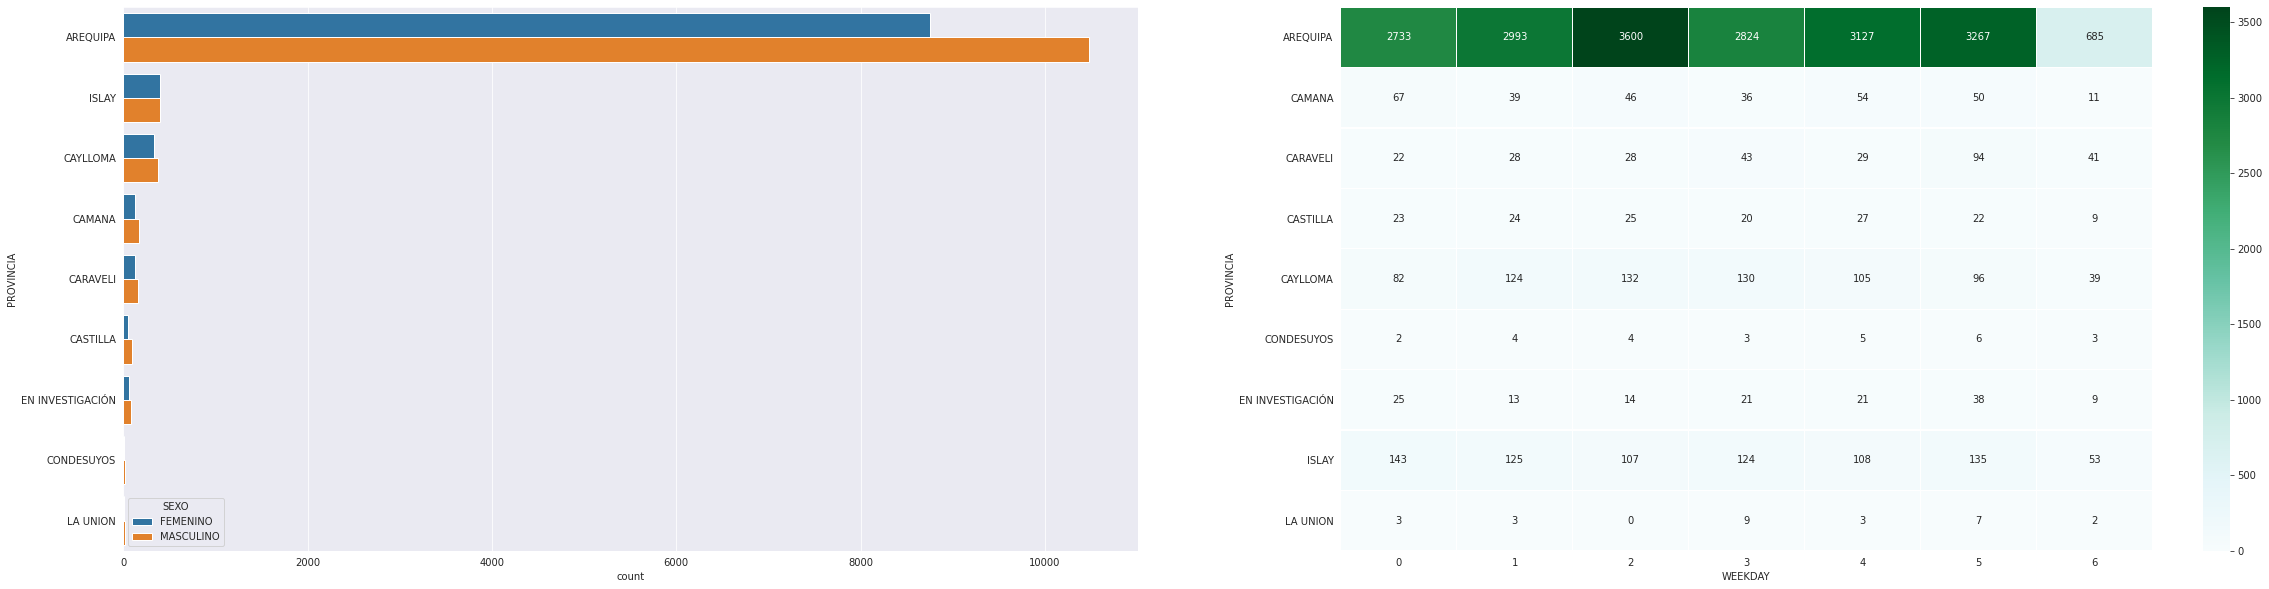

In [195]:
pd_arequipa_dep_crosstab = pd.crosstab(df_arequipa_dep["PROVINCIA"], df_arequipa_dep["WEEKDAY"])

display(df_arequipa_dep.groupby(['PROVINCIA', 'SEXO'])['UUID'].count().sort_values(ascending=False))

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_dep, y='PROVINCIA', order = df_arequipa_dep['PROVINCIA'].value_counts().index, hue='SEXO', ax = ax1)
sns.heatmap(pd_arequipa_dep_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)

plt.savefig('image_16.png')
plt.show()

In [196]:
df_arequipa_pro = datos_minsa_cut[(datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA') & (datos_minsa_cut['PROVINCIA'] == 'AREQUIPA')].reset_index(drop=True)
df_arequipa_pro['WEEKDAY'] = df_arequipa_pro['FECHA_RESULTADO'].dt.weekday
display(df_arequipa_pro.shape)
display(df_arequipa_pro.tail())

(19229, 9)

UUID DEPARTAMENTO PROVINCIA  \
19224  6CDDA9E82DA732F9924039A33F5FD33F     AREQUIPA  AREQUIPA   
19225  884AA1F72DCF269324D338B53368A4E7     AREQUIPA  AREQUIPA   
19226  86C80C264FE87AECC695950A9DE12CEC     AREQUIPA  AREQUIPA   
19227  0D73D863C84C6B95AD6D4AE34FC474F3     AREQUIPA  AREQUIPA   
19228  C1A86E2DBAF34F78DDF973E6BD1A22B1     AREQUIPA  AREQUIPA   

             DISTRITO METODODX  EDAD       SEXO FECHA_RESULTADO  WEEKDAY  
19224        AREQUIPA      PCR    58  MASCULINO      2020-08-12        2  
19225        AREQUIPA      PCR    33   FEMENINO      2020-08-12        2  
19226  CERRO COLORADO      PCR    62  MASCULINO      2020-08-12        2  
19227        AREQUIPA      PCR    66  MASCULINO      2020-08-12        2  
19228       YANAHUARA      PCR    61  MASCULINO      2020-08-12        2

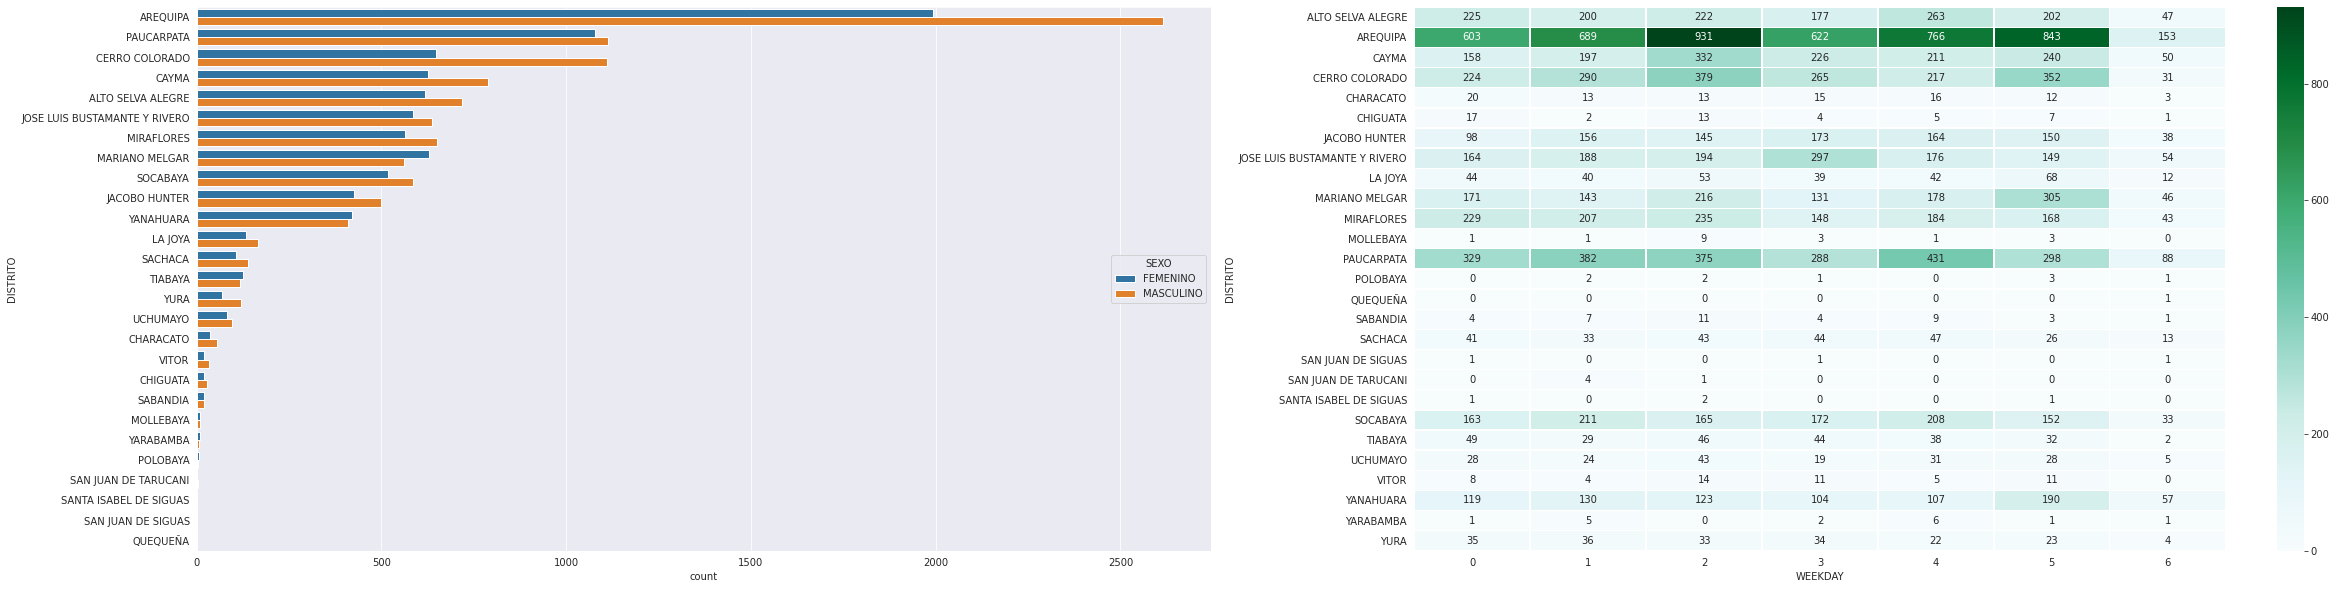

In [197]:
pd_arequipa_pro_crosstab = pd.crosstab(df_arequipa_pro["DISTRITO"], df_arequipa_pro["WEEKDAY"])

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_pro, y='DISTRITO', order = df_arequipa_pro['DISTRITO'].value_counts().index, hue = 'SEXO', ax = ax1)
sns.heatmap(pd_arequipa_pro_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)

plt.savefig('image_17.png')
plt.show()

***CONCLUSIONES: Esta, aunque no parezca, es una métrica importante; indica, aproximadamente, cuando es que las personas de Arequipa contraen el virus. Según la OMS, el virus tiende a provocar sintomas entre 5 y 6 días después de la exposición (pero pude variar entre 1 y 14 días), debido a la actual realidad de Arequipa (la temporada de invierno), en este estudio se cree que los sintomas tienden a aparecer lo mas antes posible (5 días).***

***Como vemos en las gráficas, los días (dentro de la provincia de Arequipa), más personas son diagnosticadas con COVID-19 son los MIERCOLES y SABADOS, si a estos días le quitamos los 5 días que demoraría una persona normal en tener los sintomas, eso quiere decir que las personas tienden a contagiarse más los días SABADOS y MARTES. SE SUGIERE A LAS PERSONAS NO SALIR LOS DIAS SABADO, LUNES Y MARTES***

***Referencia : https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it***

***Tenemos que notar que los datos para esta métrica son extraídos de los datos liberados del MINSA.***

In [198]:
df_arequipa_pro

UUID DEPARTAMENTO PROVINCIA  \
0      FB3B7217C24EEF03F0CA5CA47CF7C65F     AREQUIPA  AREQUIPA   
1      74592508A1ACE90119E4BA24273EC7AD     AREQUIPA  AREQUIPA   
2      796FC72482800B97B1F9781C3DD58C6C     AREQUIPA  AREQUIPA   
3      019D2354FB29A98D8D3CE44941707FF0     AREQUIPA  AREQUIPA   
4      8C0D59B58ACBA9FAFDB0AC8A6B04484B     AREQUIPA  AREQUIPA   
...                                 ...          ...       ...   
19224  6CDDA9E82DA732F9924039A33F5FD33F     AREQUIPA  AREQUIPA   
19225  884AA1F72DCF269324D338B53368A4E7     AREQUIPA  AREQUIPA   
19226  86C80C264FE87AECC695950A9DE12CEC     AREQUIPA  AREQUIPA   
19227  0D73D863C84C6B95AD6D4AE34FC474F3     AREQUIPA  AREQUIPA   
19228  C1A86E2DBAF34F78DDF973E6BD1A22B1     AREQUIPA  AREQUIPA   

             DISTRITO METODODX  EDAD       SEXO FECHA_RESULTADO  WEEKDAY  
0            AREQUIPA      PCR    30   FEMENINO      2020-03-29        6  
1            AREQUIPA      PCR    42   FEMENINO      2020-03-29        6  
2          PAUCARPATA      PCR    67  MASCULINO      2020-03-29        6  
3            AREQUIPA      PCR    22  MASCULINO      2020-03-29        6  
4            AREQUIPA      PCR    12   FEMENINO      2020-03-29        6  
...               ...      ...   ...        ...             ...      ...  
19224        AREQUIPA      PCR    58  MASCULINO      2020-08-12        2  
19225        AREQUIPA      PCR    33   FEMENINO      2020-08-12        2  
19226  CERRO COLORADO      PCR    62  MASCULINO      2020-08-12        2  
19227        AREQUIPA      PCR    66  MASCULINO      2020-08-12        2  
19228       YANAHUARA      PCR    61  MASCULINO      2020-08-12        2  

[19229 rows x 9 columns]

# Análisis por etapas y edad de las personas

In [199]:
df_arequipa_pro['ETAPA'] = df_arequipa_pro['EDAD'].apply(lambda x: 
                              'INFANCIA(0-6)' if x <= 6 
                              else 'NIÑEZ(7-12)' if x <= 12 
                              else 'ADOLESCENCIA(13-20)' if x <= 20
                              else 'JUVENTUD(21-25)' if x <= 25
                              #else 'ADULTEZ_JOVEN' if x <= 40
                              #else 'ADULTEZ_INTERMEDIA' if x <= 50
                              #else 'ADULTEZ_TARDIA' if x <= 60 
                              else 'ADULTEZ(26-60)' if x <= 60 
                              else 'ANCIANIDAD(60+)') 

In [200]:
df_etapas = df_arequipa_pro.groupby(['ETAPA', 'FECHA_RESULTADO']).size().reset_index().pivot(columns='ETAPA', index='FECHA_RESULTADO', values=0)
df_etapas.fillna(0, inplace=True)
df_etapas = df_etapas[['INFANCIA(0-6)', 'NIÑEZ(7-12)', 'ADOLESCENCIA(13-20)', 'JUVENTUD(21-25)', 'ADULTEZ(26-60)', 'ANCIANIDAD(60+)']]
df_etapas

ETAPA            INFANCIA(0-6)  NIÑEZ(7-12)  ADOLESCENCIA(13-20)  \
FECHA_RESULTADO                                                    
2020-03-29                 0.0          1.0                  0.0   
2020-03-30                 0.0          0.0                  0.0   
2020-03-31                 0.0          0.0                  0.0   
2020-04-02                 0.0          0.0                  0.0   
2020-04-04                 0.0          1.0                  1.0   
2020-04-05                 0.0          0.0                  0.0   
2020-04-06                 1.0          0.0                  0.0   
2020-04-07                 0.0          0.0                  1.0   
2020-04-08                 0.0          0.0                  0.0   
2020-04-09                 0.0          1.0                  0.0   
2020-04-10                 0.0          0.0                  0.0   
2020-04-11                 0.0          0.0                  0.0   
2020-04-12                 0.0          0.0                  0.0   
2020-04-13                 0.0          0.0                  0.0   
2020-04-14                 0.0          0.0                  0.0   
2020-04-15                 1.0          0.0                  1.0   
2020-04-16                 0.0          0.0                  1.0   
2020-04-17                 0.0          0.0                  0.0   
2020-04-18                 1.0          0.0                  0.0   
2020-04-19                 0.0          0.0                  0.0   
2020-04-20                 1.0          0.0                  0.0   
2020-04-21                 1.0          0.0                  1.0   
2020-04-22                 0.0          0.0                  0.0   
2020-04-23                 0.0          0.0                  0.0   
2020-04-24                 0.0          2.0                  1.0   
2020-04-25                 0.0          1.0                  1.0   
2020-04-26                 0.0          0.0                  0.0   
2020-04-27                 2.0          1.0                  0.0   
2020-04-28                 1.0          1.0                  1.0   
2020-04-29                 3.0          1.0                  3.0   
2020-04-30                 1.0          1.0                  1.0   
2020-05-01                 0.0          1.0                  0.0   
2020-05-02                 0.0          0.0                  0.0   
2020-05-03                 0.0          0.0                  0.0   
2020-05-04                 2.0          1.0                  1.0   
2020-05-05                 0.0          0.0                  0.0   
2020-05-06                 0.0          1.0                  0.0   
2020-05-07                 0.0          0.0                  1.0   
2020-05-08                 0.0          0.0                  2.0   
2020-05-09                 1.0          2.0                  4.0   
2020-05-10                 0.0          1.0                  0.0   
2020-05-11                 0.0          0.0                  0.0   
2020-05-12                 0.0          0.0                  1.0   
2020-05-13                 1.0          0.0                  2.0   
2020-05-14                 1.0          2.0                  1.0   
2020-05-15                 0.0          0.0                  0.0   
2020-05-16                 1.0          0.0                  4.0   
2020-05-17                 0.0          0.0                  0.0   
2020-05-18                 0.0          0.0                  2.0   
2020-05-19                 1.0          1.0                  1.0   
2020-05-20                 0.0          1.0                  5.0   
2020-05-21                 3.0          0.0                  3.0   
2020-05-22                 0.0          3.0                  6.0   
2020-05-23                 1.0          0.0                  2.0   
2020-05-24                 0.0          0.0                  0.0   
2020-05-25                 1.0          2.0                  7.0   
2020-05-26                 2.0          3.0             

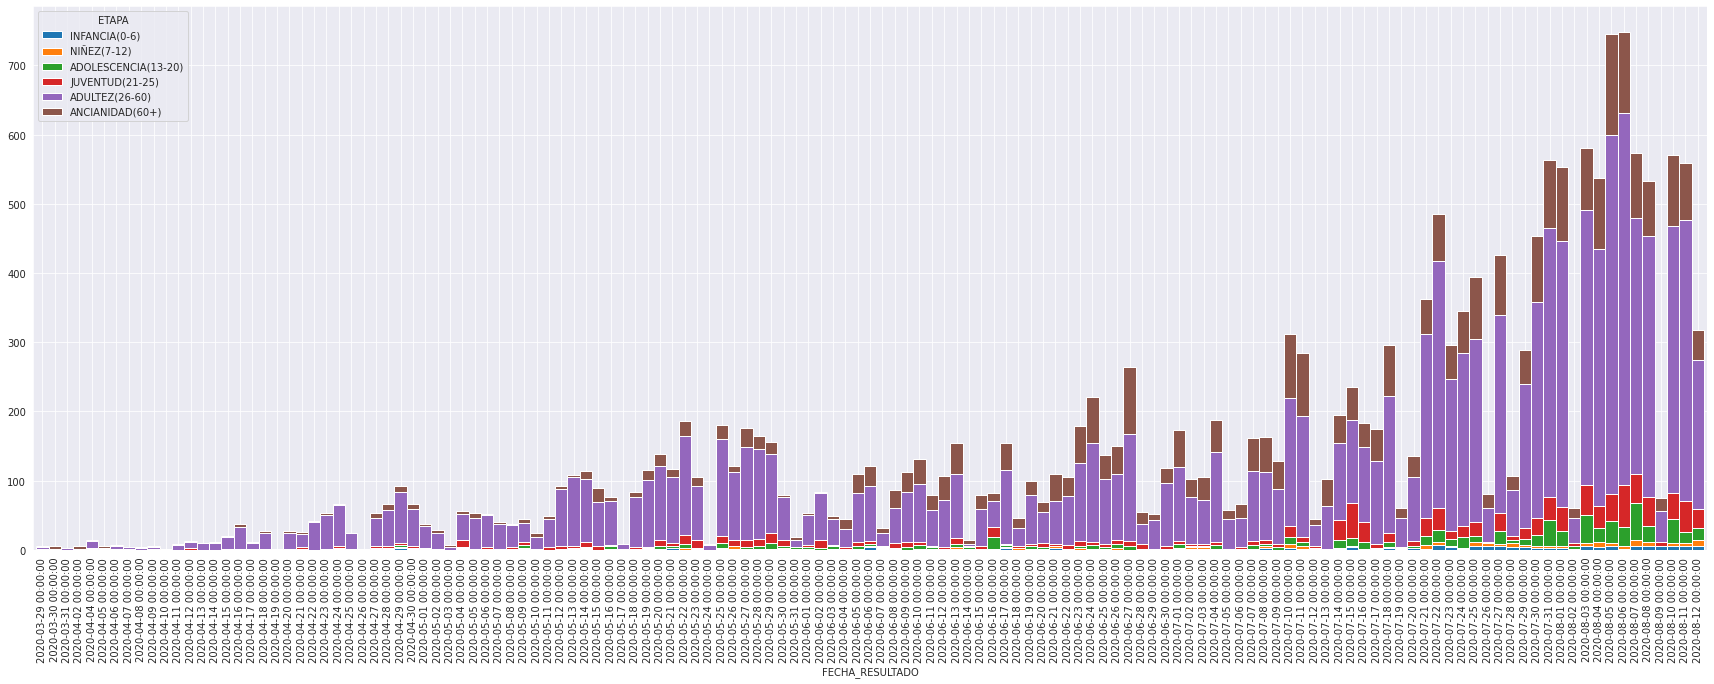

In [201]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_etapas.plot(kind='bar', stacked=True, width=1, ax=ax1)

plt.savefig('image_18.png')
plt.show()

In [202]:
df_plot = df_etapas.copy()
df_plot['SUM'] = df_plot.sum(axis=1)

df_plot['INFANCIA(0-6)'] = df_plot['INFANCIA(0-6)'] / df_plot['SUM']
df_plot['NIÑEZ(7-12)'] = df_plot['NIÑEZ(7-12)'] / df_plot['SUM']
df_plot['ADOLESCENCIA(13-20)'] = df_plot['ADOLESCENCIA(13-20)'] / df_plot['SUM']
#df_plot['ADULTEZ_INTERMEDIA'] = df_plot['ADULTEZ_INTERMEDIA'] / df_plot['SUM']
#df_plot['ADULTEZ_JOVEN'] = df_plot['ADULTEZ_JOVEN'] / df_plot['SUM']
#df_plot['ADULTEZ_TARDIA'] = df_plot['ADULTEZ_TARDIA'] / df_plot['SUM']
df_plot['JUVENTUD(21-25)'] = df_plot['JUVENTUD(21-25)'] / df_plot['SUM']
df_plot['ADULTEZ(26-60)'] = df_plot['ADULTEZ(26-60)'] / df_plot['SUM']
df_plot['ANCIANIDAD(60+)'] = df_plot['ANCIANIDAD(60+)'] / df_plot['SUM']
del df_plot['SUM']
df_plot

ETAPA            INFANCIA(0-6)  NIÑEZ(7-12)  ADOLESCENCIA(13-20)  \
FECHA_RESULTADO                                                    
2020-03-29            0.000000     0.166667             0.000000   
2020-03-30            0.000000     0.000000             0.000000   
2020-03-31            0.000000     0.000000             0.000000   
2020-04-02            0.000000     0.000000             0.000000   
2020-04-04            0.000000     0.071429             0.071429   
2020-04-05            0.000000     0.000000             0.000000   
2020-04-06            0.142857     0.000000             0.000000   
2020-04-07            0.000000     0.000000             0.250000   
2020-04-08            0.000000     0.000000             0.000000   
2020-04-09            0.000000     0.166667             0.000000   
2020-04-10            0.000000     0.000000             0.000000   
2020-04-11            0.000000     0.000000             0.000000   
2020-04-12            0.000000     0.000000             0.000000   
2020-04-13            0.000000     0.000000             0.000000   
2020-04-14            0.000000     0.000000             0.000000   
2020-04-15            0.050000     0.000000             0.050000   
2020-04-16            0.000000     0.000000             0.026316   
2020-04-17            0.000000     0.000000             0.000000   
2020-04-18            0.037037     0.000000             0.000000   
2020-04-19            0.000000     0.000000             0.000000   
2020-04-20            0.035714     0.000000             0.000000   
2020-04-21            0.038462     0.000000             0.038462   
2020-04-22            0.000000     0.000000             0.000000   
2020-04-23            0.000000     0.000000             0.000000   
2020-04-24            0.000000     0.030303             0.015152   
2020-04-25            0.000000     0.041667             0.041667   
2020-04-26            0.000000     0.000000             0.000000   
2020-04-27            0.037037     0.018519             0.000000   
2020-04-28            0.015152     0.015152             0.015152   
2020-04-29            0.032258     0.010753             0.032258   
2020-04-30            0.014925     0.014925             0.014925   
2020-05-01            0.000000     0.026316             0.000000   
2020-05-02            0.000000     0.000000             0.000000   
2020-05-03            0.000000     0.000000             0.000000   
2020-05-04            0.035714     0.017857             0.017857   
2020-05-05            0.000000     0.000000             0.000000   
2020-05-06            0.000000     0.019231             0.000000   
2020-05-07            0.000000     0.000000             0.024390   
2020-05-08            0.000000     0.000000             0.052632   
2020-05-09            0.022222     0.044444             0.088889   
2020-05-10            0.000000     0.041667             0.000000   
2020-05-11            0.000000     0.000000             0.000000   
2020-05-12            0.000000     0.000000             0.010753   
2020-05-13            0.009259     0.000000             0.018519   
2020-05-14            0.008772     0.017544             0.008772   
2020-05-15            0.000000     0.000000             0.000000   
2020-05-16            0.012987     0.000000             0.051948   
2020-05-17            0.000000     0.000000             0.000000   
2020-05-18            0.000000     0.000000             0.023810   
2020-05-19            0.008696     0.008696             0.008696   
2020-05-20            0.000000     0.007194             0.035971   
2020-05-21            0.025641     0.000000             0.025641   
2020-05-22            0.000000     0.016129             0.032258   
2020-05-23            0.009524     0.000000             0.019048   
2020-05-24            0.000000     0.000000             0.000000   
2020-05-25            0.005556     0.011111             0.038889   
2020-05-26            0.016529     0.024793             

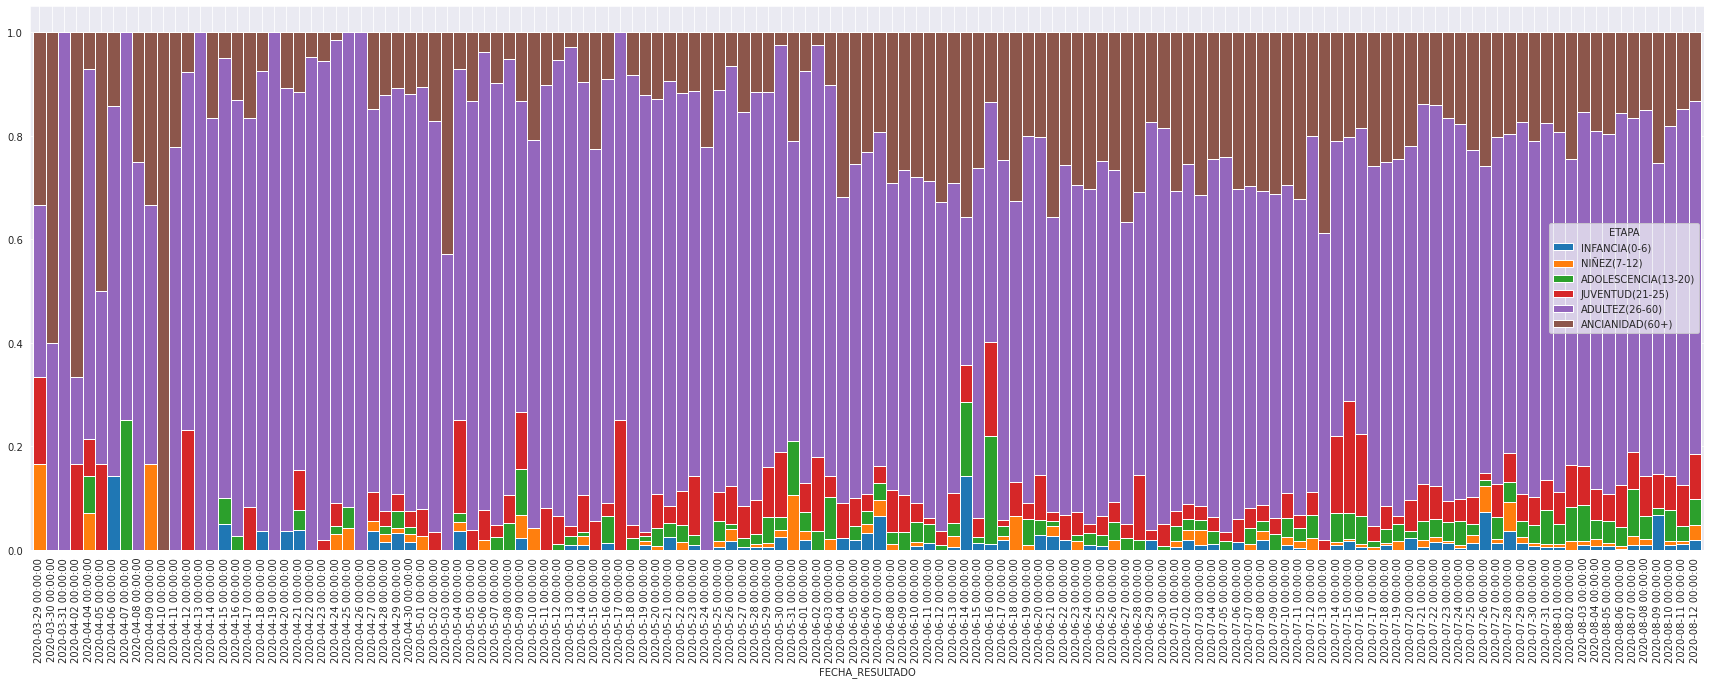

In [203]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_plot.plot(kind='bar', stacked=True, width=1, ax=ax1)

plt.savefig('image_19.png')
plt.show()

In [204]:
df_edad = df_arequipa_pro.EDAD
#df_edad.replace([0], np.nan, inplace=True)
display(df_edad.value_counts().sort_index().shape)
df_edad.describe()

(102,)

count    19229.000000
mean        45.424931
std         17.191367
min          0.000000
25%         33.000000
50%         44.000000
75%         57.000000
max        106.000000
Name: EDAD, dtype: float64

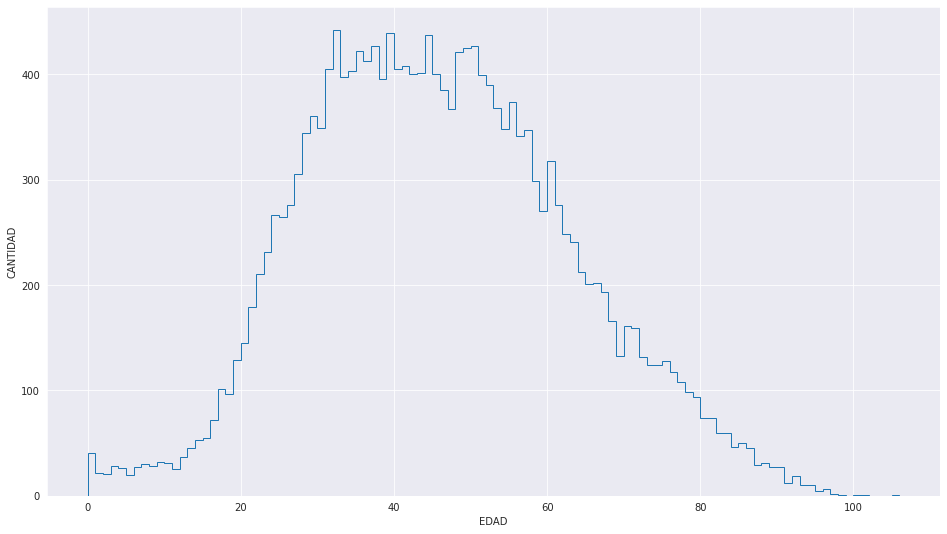

In [205]:
plt.figure(figsize=(16,9))
plt.hist(df_edad.dropna(), bins=106, histtype='step')
plt.xlabel('EDAD')
plt.ylabel('CANTIDAD')
plt.show()

In [206]:
is_masculine = df_arequipa_pro.SEXO == 'MASCULINO'
is_PCR = df_arequipa_pro.METODODX == 'PCR'
edad_sex_masculine = df_edad[is_masculine]
edad_sex_femenine = df_edad[~is_masculine]
print('Promedio de Edad Hombres: ', edad_sex_masculine.mean())
print('Promedio de Edad Mujeres: ',edad_sex_femenine.mean())

edad_sex_masculine_pcr = df_edad[is_masculine & is_PCR]
edad_sex_femenine_pcr = df_edad[~is_masculine & is_PCR]
print('Promedio de Edad Hombres - PCR: ',edad_sex_masculine_pcr.mean())
print('Promedio de Edad Mujeres - PCR: ',edad_sex_femenine_pcr.mean())

Promedio de Edad Hombres:  45.82865865292883
Promedio de Edad Mujeres:  44.94112267062993
Promedio de Edad Hombres - PCR:  51.76618049225159
Promedio de Edad Mujeres - PCR:  50.82789729354615


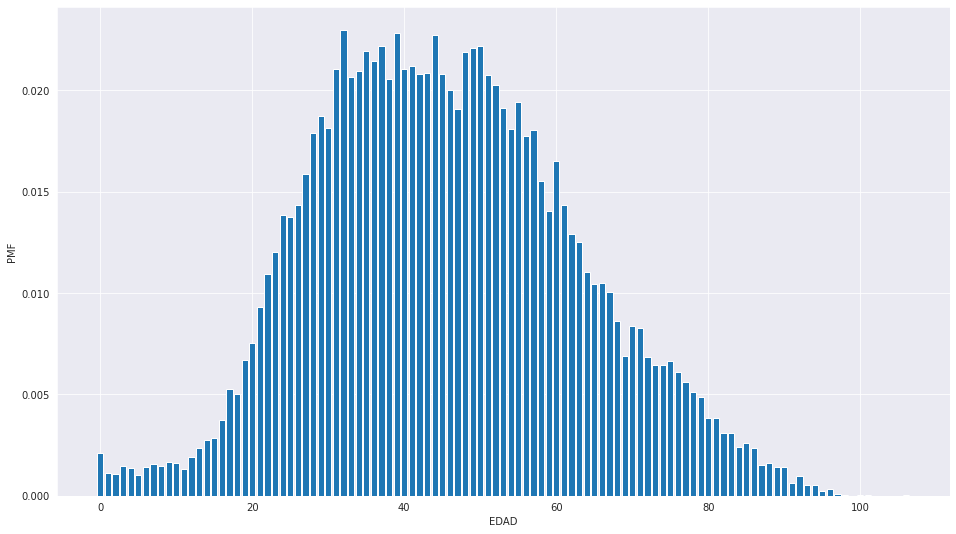

In [207]:
pmf_age_result = Pmf.from_seq(df_edad)
# Plot the PMF
plt.figure(figsize=(16,9))
pmf_age_result.bar()

# Label the axes
plt.xlabel('EDAD')
plt.ylabel('PMF')
plt.show()

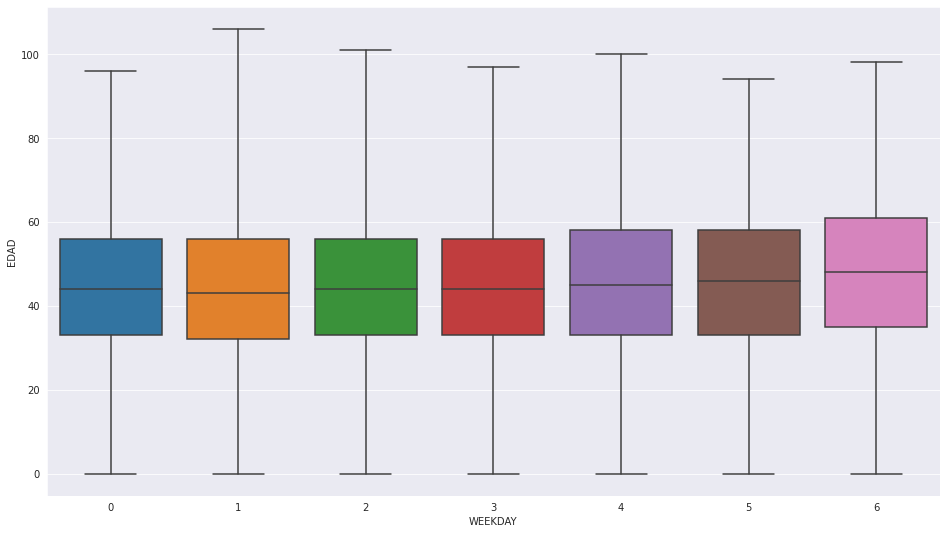

In [208]:
plt.figure(figsize=(16,9))
sns.boxplot(data = df_arequipa_pro, x='WEEKDAY', y='EDAD', whis=10)
#plt.yscale('log')
plt.show()

# SINADEF

In [209]:
MY_EXCEL_URL="https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files=SINADEF_DATOS_ABIERTOS_15082020.xlsx&downloadStartSecret=b9n0l9odbvq"
#MY_EXCEL_URL="SINADEF_DATOS_ABIERTOS_12082020.xlsx"
datos_sinadef_raw = pd.read_excel(MY_EXCEL_URL,
                       sheet_name='Tabla_SINADEF',
                       skiprows=range(3),
                       skipfooter=0)

In [210]:
datos_sinadef_raw

Nº TIPO SEGURO       SEXO EDAD TIEMPO EDAD ESTADO CIVIL  \
0            1    IGNORADO  MASCULINO   42        AÑOS      SOLTERO   
1            2         SIS  MASCULINO   40        AÑOS      SOLTERO   
2            3         SIS  MASCULINO   43        AÑOS      SOLTERO   
3            4    IGNORADO  MASCULINO   91        AÑOS       CASADO   
4            5     ESSALUD  MASCULINO   80        AÑOS       CASADO   
...        ...         ...        ...  ...         ...          ...   
460849  460850         SIS   FEMENINO   85        AÑOS       CASADO   
460850  460851         SIS   FEMENINO   83        AÑOS        VIUDO   
460851  460852         SIS   FEMENINO   94        AÑOS        VIUDO   
460852  460853         SIS   FEMENINO   85        AÑOS       CASADO   
460853  460854         SIS   FEMENINO   85        AÑOS        VIUDO   

           NIVEL DE INSTRUCCIÓN COD# UBIGEO DOMICILIO  \
0                      IGNORADO    92-11-00-00-00-000   
1         SECUNDARIA INCOMPLETA    92-33-07-01-01-000   
2       SUPERIOR NO UNIV. COMP.    92-33-24-01-01-000   
3                      IGNORADO    92-33-06-01-06-000   
4                      IGNORADO    92-33-12-01-01-000   
...                         ...                   ...   
460849      PRIMARIA INCOMPLETA    92-33-02-07-04-000   
460850      PRIMARIA INCOMPLETA    92-33-01-05-04-000   
460851  NINGUN NIVEL / ILETRADO    92-33-01-05-04-000   
460852  NINGUN NIVEL / ILETRADO    92-33-01-04-22-000   
460853      PRIMARIA INCOMPLETA    92-33-01-05-04-000   

                        PAIS DOMICILIO DEPARTAMENTO DOMICILIO  \
0       ECUADOR                                    EXTRANJERO   
1                                 PERU                  CUSCO   
2                                 PERU                 CALLAO   
3                                 PERU              CAJAMARCA   
4                                 PERU            LA LIBERTAD   
...                                ...                    ...   
460849                            PERU                 ANCASH   
460850                            PERU               AMAZONAS   
460851                            PERU               AMAZONAS   
460852                            PERU               AMAZONAS   
460853                            PERU               AMAZONAS   

         PROVINCIA DOMICILIO DISTRITO DOMICILIO       FECHA   AÑO  MES  \
0                 EXTRANJERO         EXTRANJERO  2020-01-04  2020    1   
1                      CUSCO              CUSCO  2020-01-24  2020    1   
2                     CALLAO             CALLAO  2020-01-30  2020    1   
3                  CAJAMARCA              JESUS  2020-01-19  2020    1   
4                   TRUJILLO           TRUJILLO  2020-01-13  2020    1   
...                      ...                ...         ...   ...  ...   
460849               HUAYLAS            HUAYLAS  2019-12-05  2019   12   
460850  RODRIGUEZ DE MENDOZA             HUAMBO  2019-12-13  2019   12   
460851  RODRIGUEZ DE MENDOZA             HUAMBO  2019-12-24  2019   12   
460852                  LUYA              TRITA  2019-12-02  2019   12   
460853  RODRIGUEZ DE MENDOZA             HUAMBO  2019-12-10  2019   12   

         TIPO LUGAR        INSTITUCION MUERTE VIOLENTA  \
0              EESS              MINSA       HOMICIDIO   
1              EESS  GOBIERNO REGIONAL    SIN REGISTRO   
2              EESS              MINSA    SIN REGISTRO   
3         DOMICILIO       SIN REGISTRO    SIN REGISTRO   
4              EESS            ESSALUD    SIN REGISTRO   
...             ...                ...             ...   
460849    DOMICILIO       SIN REGISTRO    SIN REGISTRO   
460850    DOMICILIO       SIN REGISTRO    SIN REGISTRO   
460851         OTRO       SIN REGISTRO    SIN REGISTRO   
460852    DOMICILIO       SIN REGISTRO    SIN REGISTRO   
460853  EN TRANSITO       SIN REGISTRO    SIN REGISTRO   

                      NECROPSIA                    DEBIDO A (CAUSA A)  \
0       SI SE REALIZÓ NECROPSIA   

In [211]:
datos_sinadef_raw['SEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.week
#datos_sinadef_raw['DIAANUAL'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.dayofyear
datos_sinadef_raw['MESDIA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%m-%d')

In [212]:
datos_sinadef_raw.query('SEMANA == 18').query('AÑO == 2020').sort_values('FECHA')
#datos_sinadef_raw.sort_values('FECHA')

Nº TIPO SEGURO       SEXO EDAD TIEMPO EDAD ESTADO CIVIL  \
30089    30090         SIS  MASCULINO   65        AÑOS       CASADO   
30106    30107    IGNORADO  MASCULINO   53        AÑOS       CASADO   
30105    30106     ESSALUD  MASCULINO   53        AÑOS      SOLTERO   
30104    30105    IGNORADO  MASCULINO   38        AÑOS       CASADO   
30103    30104         SIS  MASCULINO   76        AÑOS      SOLTERO   
...        ...         ...        ...  ...         ...          ...   
62790    62791         SIS  MASCULINO   90        AÑOS       CASADO   
62789    62790         SIS  MASCULINO   64        AÑOS       CASADO   
62788    62789         SIS  MASCULINO   57        AÑOS      SOLTERO   
62786    62787         SIS   FEMENINO   61        AÑOS      SOLTERO   
133056  133057         SIS  MASCULINO   92        AÑOS       CASADO   

        NIVEL DE INSTRUCCIÓN COD# UBIGEO DOMICILIO PAIS DOMICILIO  \
30089    PRIMARIA INCOMPLETA    92-33-19-06-01-000           PERU   
30106    SECUNDARIA COMPLETA    92-33-14-01-01-000           PERU   
30105   SUPERIOR UNIV. COMP.    92-33-13-01-12-000           PERU   
30104    SECUNDARIA COMPLETA    92-33-14-01-03-000           PERU   
30103    PRIMARIA INCOMPLETA    92-33-17-02-01-000           PERU   
...                      ...                   ...            ...   
62790               IGNORADO    92-33-11-08-01-000           PERU   
62789    SECUNDARIA COMPLETA    92-33-14-01-36-000           PERU   
62788               IGNORADO    92-33-19-01-03-000           PERU   
62786               IGNORADO    92-33-14-01-03-000           PERU   
133056   PRIMARIA INCOMPLETA    92-33-02-13-09-000           PERU   

       DEPARTAMENTO DOMICILIO    PROVINCIA DOMICILIO      DISTRITO DOMICILIO  \
30089                   PIURA                SULLANA                 SULLANA   
30106                    LIMA                   LIMA                    LIMA   
30105              LAMBAYEQUE               CHICLAYO     JOSE LEONARDO ORTIZ   
30104                    LIMA                   LIMA                     ATE   
30103                MOQUEGUA  GENERAL SANCHEZ CERRO                   OMATE   
...                       ...                    ...                     ...   
62790                   JUNIN            CHANCHAMAYO             CHANCHAMAYO   
62789                    LIMA                   LIMA  SAN JUAN DE MIRAFLORES   
62788                   PIURA                  PIURA                CASTILLA   
62786                    LIMA                   LIMA                     ATE   
133056                 ANCASH                  SANTA          NUEVO CHIMBOTE   

             FECHA   AÑO  MES TIPO LUGAR        INSTITUCION MUERTE VIOLENTA  \
30089   2020-04-27  2020    4       EESS  GOBIERNO REGIONAL    SIN REGISTRO   
30106   2020-04-27  2020    4       EESS              MINSA    SIN REGISTRO   
30105   2020-04-27  2020    4       EESS            ESSALUD    SIN REGISTRO   
30104   2020-04-27  2020    4       EESS              MINSA    SIN REGISTRO   
30103   2020-04-27  2020    4  DOMICILIO       SIN REGISTRO    SIN REGISTRO   
...            ...   ...  ...        ...                ...             ...   
62790   2020-05-03  2020    5  DOMICILIO       SIN REGISTRO    SIN REGISTRO   
62789   2020-05-03  2020    5  DOMICILIO       SIN REGISTRO    SIN REGISTRO   
62788   2020-05-03  2020    5       EESS  GOBIERNO REGIONAL    SIN REGISTRO   
62786   2020-05-03  2020    5       EESS              MINSA    SIN REGISTRO   
133056  2020-05-03  2020    5  DOMICILIO       SIN REGISTRO    SIN REGISTRO   

                      NECROPSIA  \
30089   NO SE REALIZÓ NECROPSIA   
30106   NO SE REALIZÓ NECROPSIA   
30105   NO SE REALIZÓ NECROPSIA   
30104   NO SE REALIZÓ NECROPSIA   
30103   NO SE REALIZÓ NECROPSIA   
...                         ...   
62790   NO SE REALIZÓ NECROPSIA   
62789   NO SE REALIZÓ NECROPSIA   
62788   NO SE REALIZÓ NECROPSIA   
62786   NO SE REALIZÓ NECROPSIA   
133056  NO SE REALIZÓ NECROPSIA   


In [213]:
datos_sinadef_semana = datos_sinadef_raw.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_semana = datos_sinadef_semana.to_frame().reset_index()
datos_sinadef_semana = datos_sinadef_semana[datos_sinadef_semana['SEMANA'] <= 32 ]
datos_sinadef_semana.tail()

SEMANA   AÑO    Nº
0         1  2017  1584
1         1  2018  2284
2         1  2019  2620
3         1  2020  1615
4         2  2017  1670
5         2  2018  1980
6         2  2019  2126
7         2  2020  2290
8         3  2017  1740
9         3  2018  1922
10        3  2019  2132
11        3  2020  2198
12        4  2017  1760
13        4  2018  1953
14        4  2019  2126
15        4  2020  2213
16        5  2017  1880
17        5  2018  1888
18        5  2019  2345
19        5  2020  2112
20        6  2017  1682
21        6  2018  1914
22        6  2019  2307
23        6  2020  2228
24        7  2017  1715
25        7  2018  2024
26        7  2019  2251
27        7  2020  2203
28        8  2017  1933
29        8  2018  1949
30        8  2019  2317
31        8  2020  2217
32        9  2017  2052
33        9  2018  1948
34        9  2019  2373
35        9  2020  2301
36       10  2017  1839
37       10  2018  1893
38       10  2019  2293
39       10  2020  2287
40       11  2017  1932
41       11  2018  1972
42       11  2019  2254
43       11  2020  2329
44       12  2017  1911
45       12  2018  1970
46       12  2019  2107
47       12  2020  2057
48       13  2017  1788
49       13  2018  1984
50       13  2019  2111
51       13  2020  2023
52       14  2017  1767
53       14  2018  2098
54       14  2019  2039
55       14  2020  2220
56       15  2017  1758
57       15  2018  1835
58       15  2019  2096
59       15  2020  2327
60       16  2017  1804
61       16  2018  1985
62       16  2019  2139
63       16  2020  2873
64       17  2017  1685
65       17  2018  1991
66       17  2019  2023
67       17  2020  3613
68       18  2017  1780
69       18  2018  2130
70       18  2019  2042
71       18  2020  4466
72       19  2017  1751
73       19  2018  2001
74       19  2019  1980
75       19  2020  5069
76       20  2017  1812
77       20  2018  2118
78       20  2019  2021
79       20  2020  5552
80       21  2017  1811
81       21  2018  2294
82       21  2019  1995
83       21  2020  5916
84       22  2017  1782
85       22  2018  2288
86       22  2019  2080
87       22  2020  6133
88       23  2017  1933
89       23  2018  2348
90       23  2019  2124
91       23  2020  6331
92       24  2017  1839
93       24  2018  2442
94       24  2019  2169
95       24  2020  6414
96       25  2017  1918
97       25  2018  2496
98       25  2019  2258
99       25  2020  6301
100      26  2017  1966
101      26  2018  2453
102      26  2019  2181
103      26  2020  5879
104      27  2017  2009
105      27  2018  2477
106      27  2019  2234
107      27  2020  5965
108      28  2017  1923
109      28  2018  2320
110      28  2019  2182
111      28  2020  6158
112      29  2017  1956
113      29  2018  2389
114      29  2019  2255
115      29  2020  6413
116      30  2017  2004
117      30  2018  2377
118      30  2019  2265
119      30  2020  6436
120      31  2017  1929
121      31  2018  2388
122      31  2019  2231
123      31  2020  6545
124      32  2017  1962
125      32  2018  2373
126      32  2019  2356
127      32  2020  6666

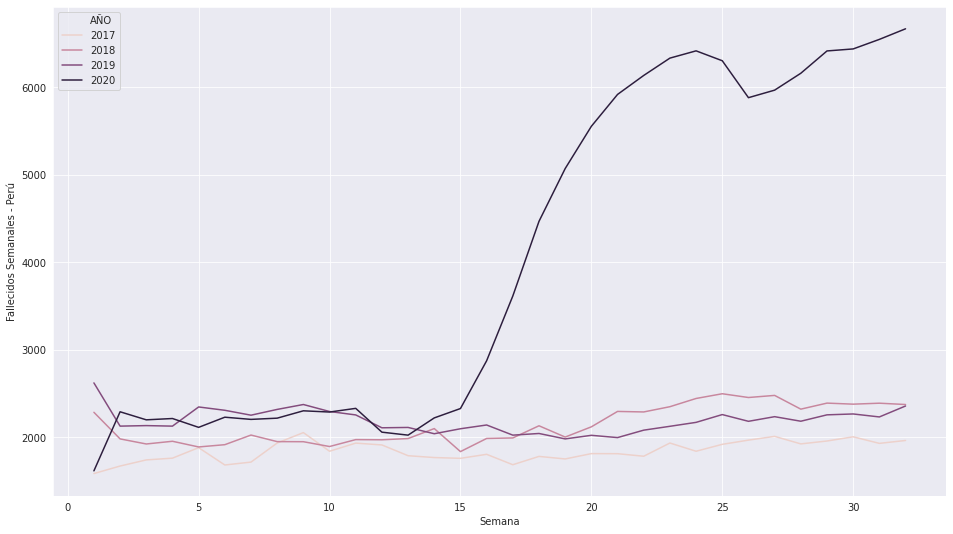

In [214]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Perú')

plt.savefig('image_20.png')
plt.show()

In [270]:
#datos_sinadef_dia = datos_sinadef_raw.groupby(['DIAANUAL', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_raw.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_dia.to_frame().reset_index()
#datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['DIAANUAL'] <= 222]
datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['MESDIA'] <= '08-14']
datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['MESDIA'] != '02-29']
datos_sinadef_dia

MESDIA   AÑO   Nº
0    01-01  2017  270
1    01-01  2018  322
2    01-01  2019  344
3    01-01  2020  358
4    01-02  2017  238
..     ...   ...  ...
900  08-13  2020  917
901  08-14  2017  263
902  08-14  2018  359
903  08-14  2019  302
904  08-14  2020  902

[904 rows x 3 columns]

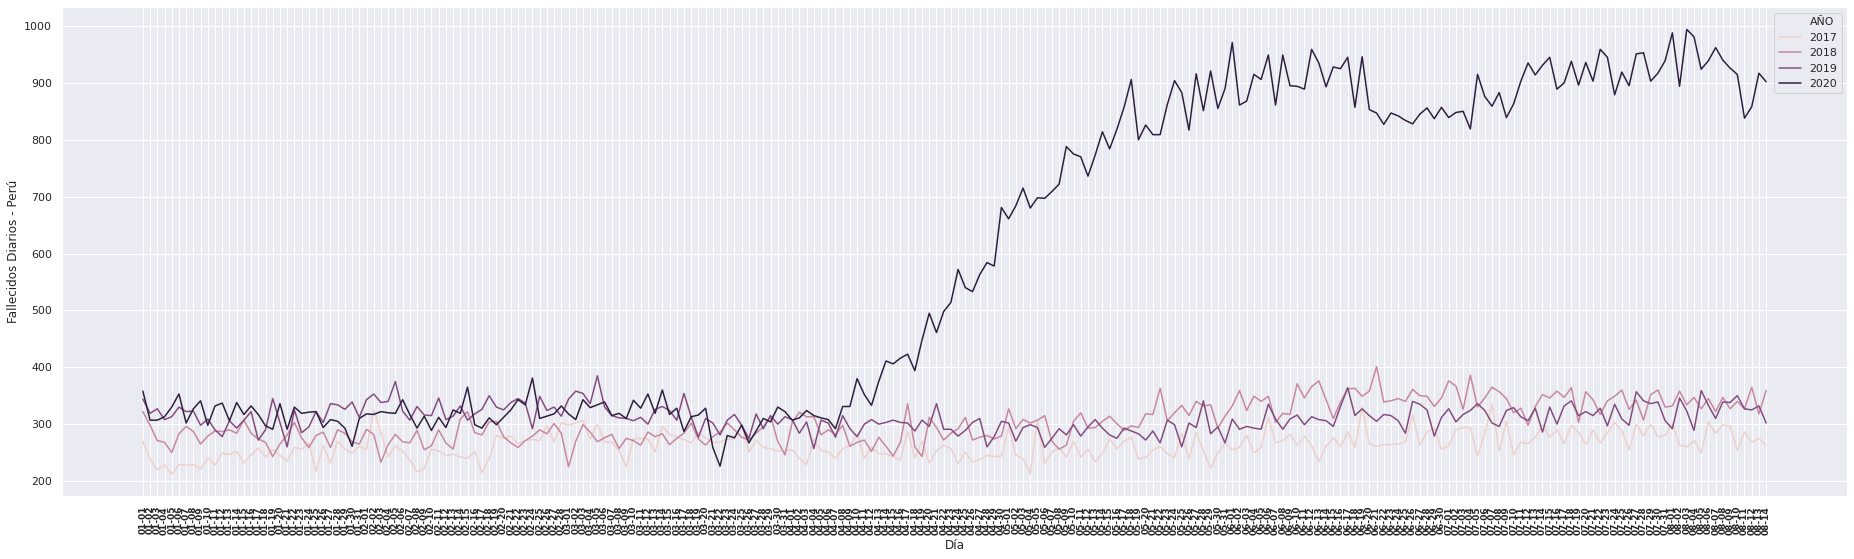

In [271]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

sns.lineplot(data=datos_sinadef_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Perú')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')

#plt.savefig('image_20.png')
plt.show()

In [272]:
datos_sinadef_raw.tail()

Nº TIPO SEGURO      SEXO EDAD TIEMPO EDAD ESTADO CIVIL  \
460849  460850         SIS  FEMENINO   85        AÑOS       CASADO   
460850  460851         SIS  FEMENINO   83        AÑOS        VIUDO   
460851  460852         SIS  FEMENINO   94        AÑOS        VIUDO   
460852  460853         SIS  FEMENINO   85        AÑOS       CASADO   
460853  460854         SIS  FEMENINO   85        AÑOS        VIUDO   

           NIVEL DE INSTRUCCIÓN COD# UBIGEO DOMICILIO PAIS DOMICILIO  \
460849      PRIMARIA INCOMPLETA    92-33-02-07-04-000           PERU   
460850      PRIMARIA INCOMPLETA    92-33-01-05-04-000           PERU   
460851  NINGUN NIVEL / ILETRADO    92-33-01-05-04-000           PERU   
460852  NINGUN NIVEL / ILETRADO    92-33-01-04-22-000           PERU   
460853      PRIMARIA INCOMPLETA    92-33-01-05-04-000           PERU   

       DEPARTAMENTO DOMICILIO   PROVINCIA DOMICILIO DISTRITO DOMICILIO  \
460849                 ANCASH               HUAYLAS            HUAYLAS   
460850               AMAZONAS  RODRIGUEZ DE MENDOZA             HUAMBO   
460851               AMAZONAS  RODRIGUEZ DE MENDOZA             HUAMBO   
460852               AMAZONAS                  LUYA              TRITA   
460853               AMAZONAS  RODRIGUEZ DE MENDOZA             HUAMBO   

             FECHA   AÑO  MES   TIPO LUGAR   INSTITUCION MUERTE VIOLENTA  \
460849  2019-12-05  2019   12    DOMICILIO  SIN REGISTRO    SIN REGISTRO   
460850  2019-12-13  2019   12    DOMICILIO  SIN REGISTRO    SIN REGISTRO   
460851  2019-12-24  2019   12         OTRO  SIN REGISTRO    SIN REGISTRO   
460852  2019-12-02  2019   12    DOMICILIO  SIN REGISTRO    SIN REGISTRO   
460853  2019-12-10  2019   12  EN TRANSITO  SIN REGISTRO    SIN REGISTRO   

                      NECROPSIA                    DEBIDO A (CAUSA A)  \
460849  NO SE REALIZÓ NECROPSIA   SINDROME DE DIFICULTAD RESPIRATORIA   
460850  NO SE REALIZÓ NECROPSIA            INSUFICIENCIA RESPIRATORIA   
460851  NO SE REALIZÓ NECROPSIA      INSUFICIENCIA RESPIRATORIA AGUDA   
460852  NO SE REALIZÓ NECROPSIA  INSUFICIENCIA CARDIACA ESPICIFICADAD   
460853  NO SE REALIZÓ NECROPSIA                   FALLA MULTIORGANICA   

       CAUSA A (CIE-X)                             DEBIDO A (CAUSA B)  \
460849            J80X                                       NEUMONIA   
460850            J969                     INFARTO AGUDO DE MIOCARDIO   
460851            J960                      INFART AGUDO DE MIOCARDIO   
460852            I509  INFARTO AGUDO DEL MIOCARDIO OTRA ESPECIFICADA   
460853            Y628                                ULCERA GASTRICA   

       CAUSA B (CIE-X)     DEBIDO A (CAUSA C) CAUSA C (CIE-X)  \
460849            J189      FIBROSIS PULMONAR            J849   
460850            I219  HIPERTENSION ARTERIAL            I10X   
460851            I252  HIPERTENSION ARTERIAL            I10X   
460852            I219           SIN REGISTRO    SIN REGISTRO   
460853            N778      GASTRITIS CRONICA            K295   

            DEBIDO A (CAUSA D) CAUSA D (CIE-X) DEBIDO A (CAUSA E)  \
460849            SIN REGISTRO    SIN REGISTRO       SIN REGISTRO   
460850            SIN REGISTRO    SIN REGISTRO       SIN REGISTRO   
460851            SIN REGISTRO    SIN REGISTRO       SIN REGISTRO   
460852            SIN REGISTRO    SIN REGISTRO       SIN REGISTRO   
460853  OSBTRUCCION INTESTINAL            K913       SIN REGISTRO   

       CAUSA E (CIE-X) DEBIDO A (CAUSA F) CAUSA F (CIE-X)  SEMANA MESDIA  
460849    SIN REGISTRO       SIN REGISTRO    SIN REGISTRO      49  12-05  
460850    SIN REGISTRO       SIN REGISTRO    SIN REGISTRO      50  12-13  
460851    SIN REGISTRO       SIN REGISTRO    SIN REGISTRO      52  12-24  
460852    SIN REGISTRO       SIN REGISTRO    SIN REGISTRO      49  12-02  
460853    SIN REGISTRO       SIN REGISTRO    SIN REGISTRO      50  12-10

In [278]:
#datos_sinadef_departamentos = datos_sinadef_raw[(datos_sinadef_raw['FECHA'] <= '2020-08-14') & (datos_sinadef_raw['FECHA'] >= '2017-01-01')]
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['FECHA'] <= '2020-08-13']
datos_sinadef_departamentos = datos_sinadef_raw[datos_sinadef_raw['SEMANA'] <= 32]
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['MESDIA'] <= '08-13']
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['MESDIA'] != '02-29' ]
datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'AÑO', 'SEMANA'])['Nº', 'Nº', 'Nº'].count()
#datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'SEMANA'])['Nº', 'Nº', 'Nº'].count()
datos_sinadef_departamentos.columns = ['real', '-1', '+1']
#datos_sinadef_departamentos['-1'] = datos_sinadef_dia['-1'] - 1
#datos_sinadef_departamentos['+1'] = datos_sinadef_dia['+1'] + 1
datos_sinadef_departamentos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


real  -1  +1
DEPARTAMENTO DOMICILIO AÑO  SEMANA              
AMAZONAS               2017 1         11  11  11
                            2         13  13  13
                            3         16  16  16
                            4          9   9   9
                            5         17  17  17
...                                  ...  ..  ..
UCAYALI                2020 28        51  51  51
                            29        56  56  56
                            30        46  46  46
                            31        45  45  45
                            32        34  34  34

[3448 rows x 3 columns]

In [279]:
def plot_sinadef_departamentos(result, ax, state_name):
    ax.set_title(f"{state_name}")

    #index = pd.to_datetime(result['real'].index.get_level_values('SEMANA'))
    index = result['real'].index.get_level_values('SEMANA')
    
    sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('AÑO'), ax=ax)
    #sns.lineplot(data=result, x = index , y = 'real', ax=ax)


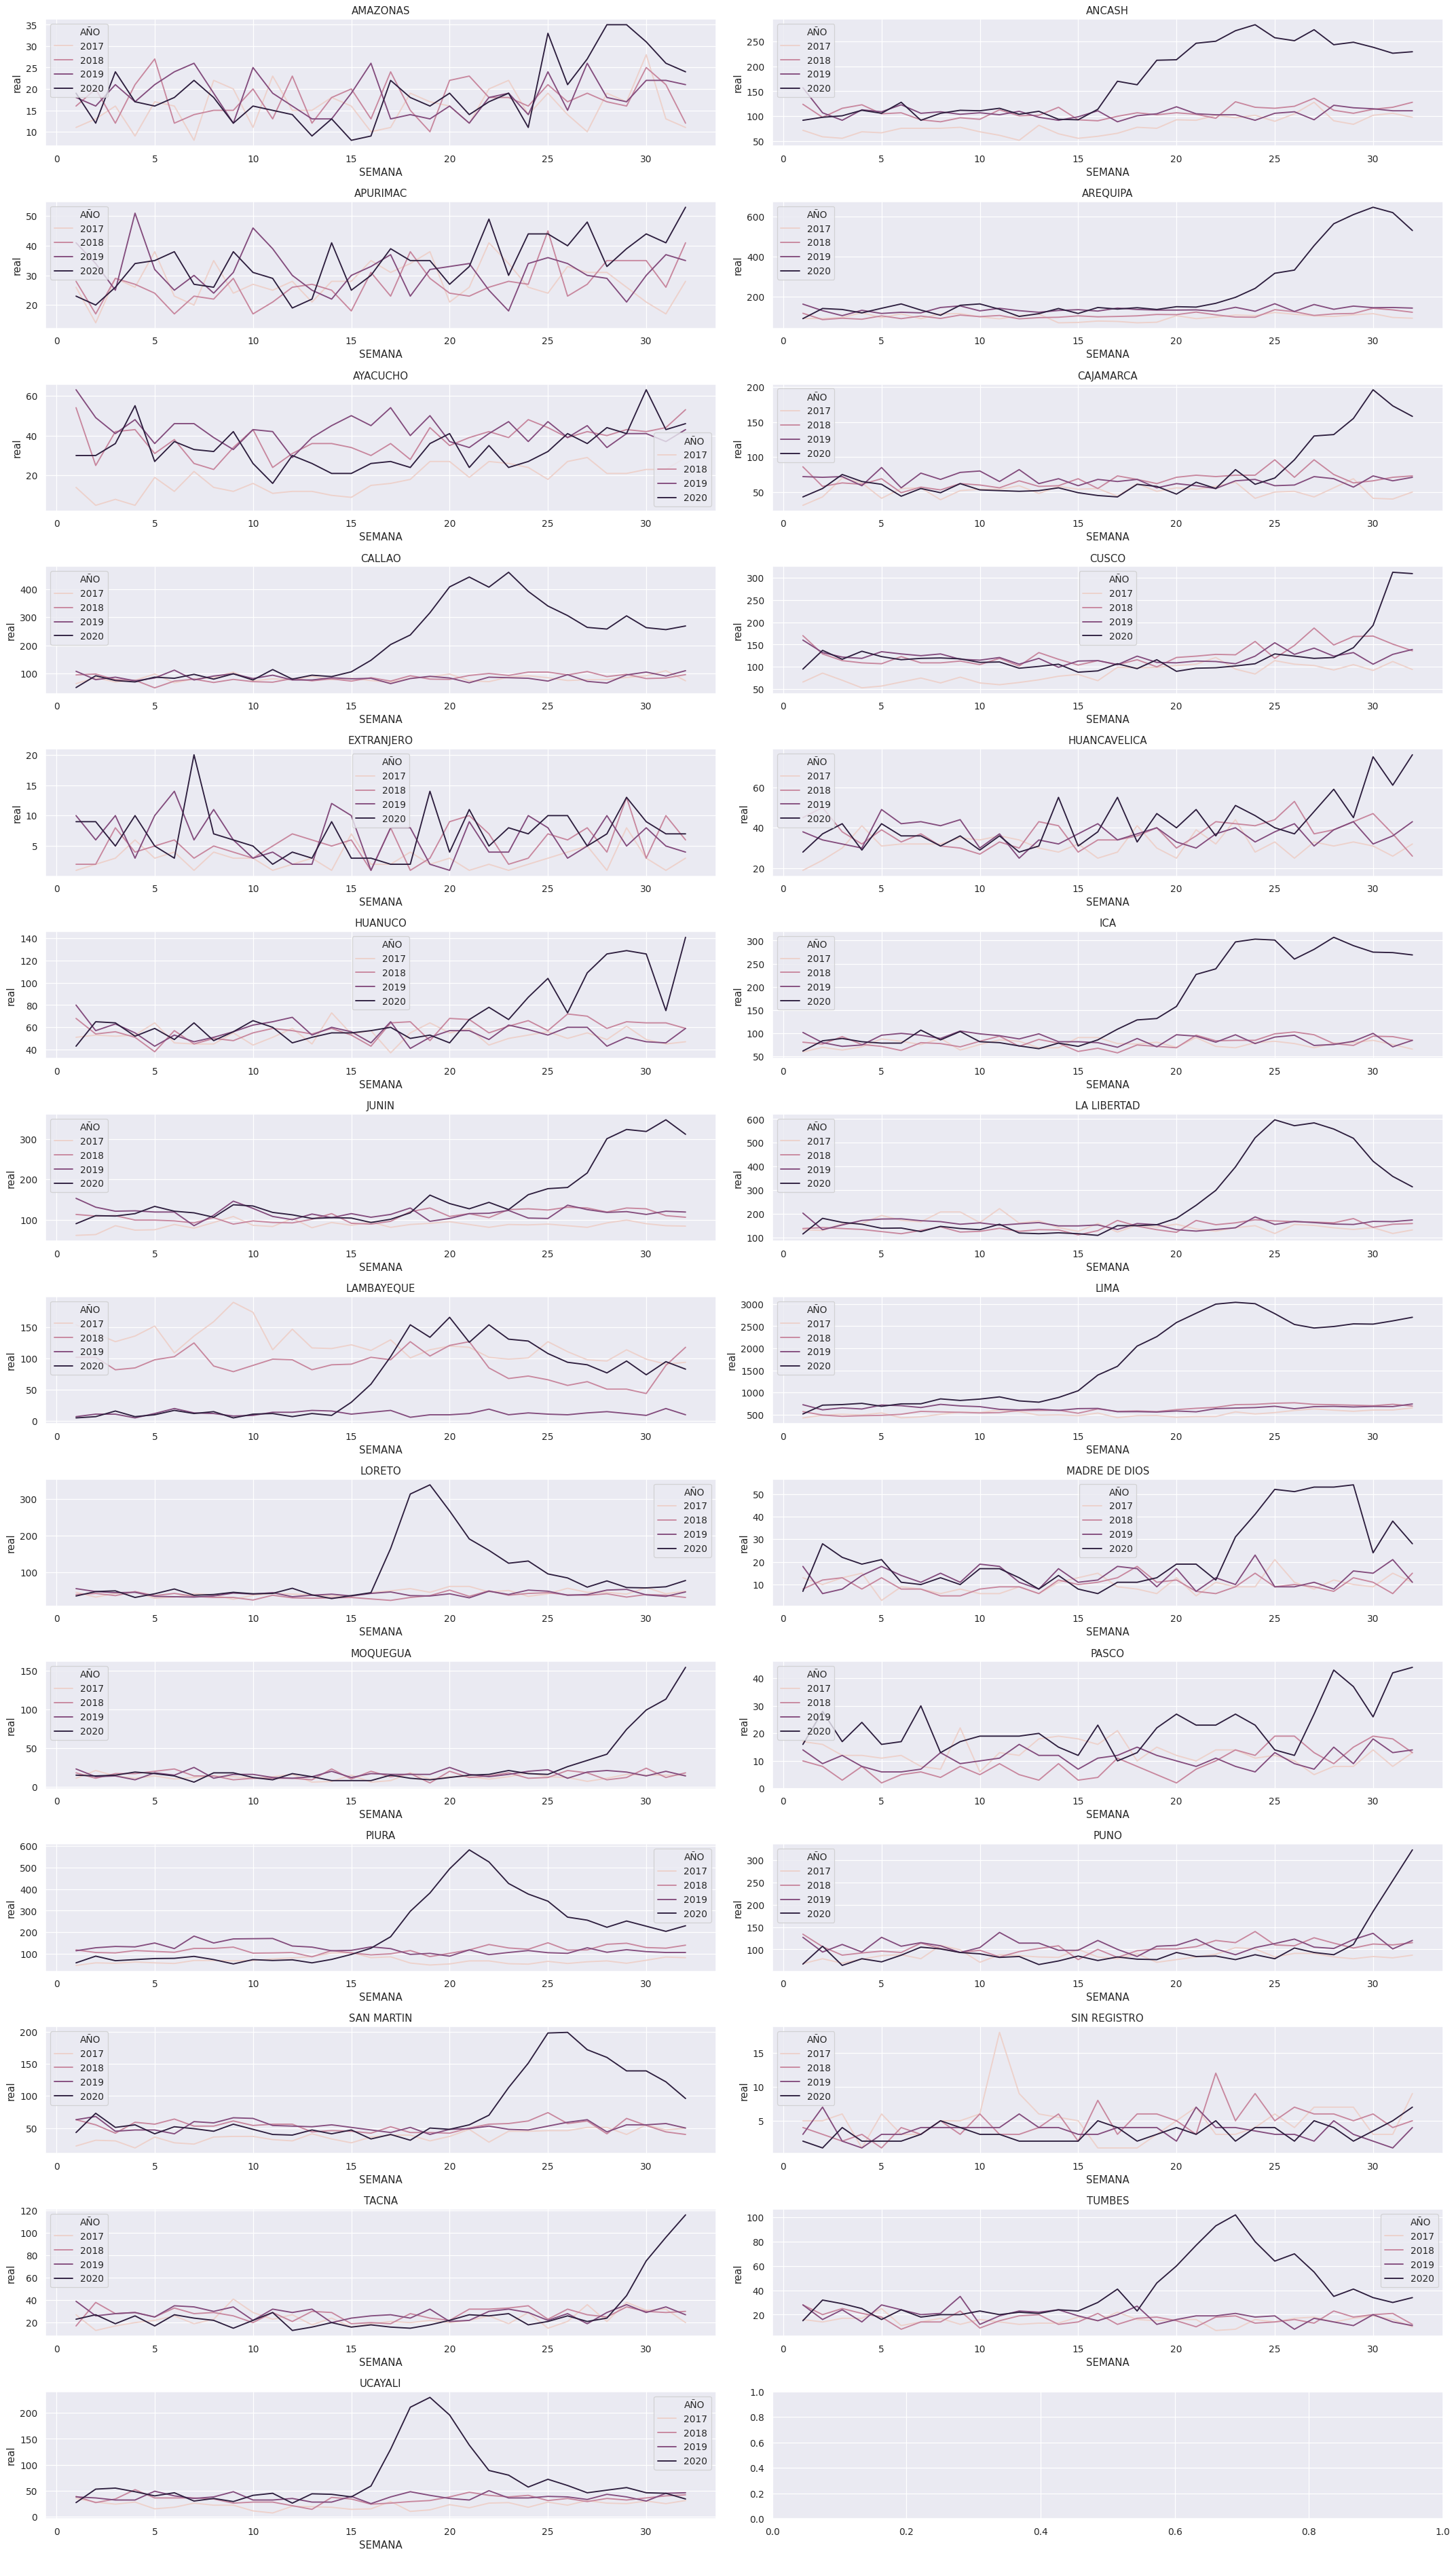

In [292]:
def plot_rt_states():
    N_COLS = 2
    N_ROWS = int(np.ceil(len(datos_sinadef_raw['DEPARTAMENTO DOMICILIO'].unique()) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(24, N_ROWS*3), dpi=90)
    
    # loop for several states
    for i, (state_name, result) in enumerate(datos_sinadef_departamentos.groupby('DEPARTAMENTO DOMICILIO')):
        plot_sinadef_departamentos(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')
    plt.savefig('image_24.png')

plot_rt_states()

In [281]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]
datos_sinadef_arequipa = datos_sinadef_no_violenta[datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA']
#datos_sinadef_arequipa['SEMANA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.week
#datos_sinadef_arequipa['DIAANUAL'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.dayofyear
datos_sinadef_arequipa = datos_sinadef_arequipa.reset_index(drop=True)
datos_sinadef_arequipa.tail()

Nº TIPO SEGURO       SEXO EDAD TIEMPO EDAD ESTADO CIVIL  \
23279  459737    PRIVADOS   FEMENINO   86        AÑOS       CASADO   
23280  459738    PRIVADOS   FEMENINO   97        AÑOS        VIUDO   
23281  459740         SIS   FEMENINO   88        AÑOS       CASADO   
23282  460780         SIS  MASCULINO   86        AÑOS        VIUDO   
23283  460784         SIS  MASCULINO   76        AÑOS      SOLTERO   

          NIVEL DE INSTRUCCIÓN COD# UBIGEO DOMICILIO PAIS DOMICILIO  \
23279      SUPERIOR UNIV. INC.    92-33-04-01-02-000           PERU   
23280      PRIMARIA INCOMPLETA    92-33-04-01-23-000           PERU   
23281  NINGUN NIVEL / ILETRADO    92-33-04-06-06-000           PERU   
23282      PRIMARIA INCOMPLETA    92-33-04-08-02-000           PERU   
23283      PRIMARIA INCOMPLETA    92-33-04-08-03-000           PERU   

      DEPARTAMENTO DOMICILIO PROVINCIA DOMICILIO DISTRITO DOMICILIO  \
23279               AREQUIPA            AREQUIPA              CAYMA   
23280               AREQUIPA            AREQUIPA          YANAHUARA   
23281               AREQUIPA          CONDESUYOS          SALAMANCA   
23282               AREQUIPA            LA UNION               ALCA   
23283               AREQUIPA            LA UNION           CHARCANA   

            FECHA   AÑO  MES TIPO LUGAR   INSTITUCION MUERTE VIOLENTA  \
23279  2019-11-19  2019   11       EESS       PRIVADO    SIN REGISTRO   
23280  2019-11-06  2019   11       EESS       PRIVADO    SIN REGISTRO   
23281  2019-11-12  2019   11  DOMICILIO  SIN REGISTRO    SIN REGISTRO   
23282  2019-12-23  2019   12       OTRO  SIN REGISTRO    SIN REGISTRO   
23283  2019-12-08  2019   12  DOMICILIO  SIN REGISTRO    SIN REGISTRO   

                     NECROPSIA                DEBIDO A (CAUSA A)  \
23279  NO SE REALIZÓ NECROPSIA               CHOQUE CARDIOGÉNICO   
23280  NO SE REALIZÓ NECROPSIA               CHOQUE CARDIOGÉNICO   
23281  NO SE REALIZÓ NECROPSIA           FALLA ORGANICA MULTIPLE   
23282  NO SE REALIZÓ NECROPSIA            INSUFICIENCIA CARDIACA   
23283  NO SE REALIZÓ NECROPSIA  INSUFICIENCIA RESPIRATORIA AGUDA   

      CAUSA A (CIE-X)         DEBIDO A (CAUSA B) CAUSA B (CIE-X)  \
23279            R570    SEPSIS, NO ESPECIFICADA            A419   
23280            R570    SEPSIS, NO ESPECIFICADA            A419   
23281            R99X               SIN REGISTRO    SIN REGISTRO   
23282            R092                HIPOVOLEMIA            E86X   
23283            J960  NEUMONITIS POR ASPIRACIÓN            J698   

                       DEBIDO A (CAUSA C) CAUSA C (CIE-X)  \
23279    INSUFICIENCIA RESPIRATORIA AGUDA            J960   
23280  INSUFICIENCIA RESPIRATORIA AGUDA              J960   
23281         INSUFICIENCIA RENAL CRONICA            N189   
23282                     VASO DILATACIÓN            I739   
23283       INTOXICACIÓN ALCOHOLICA AGUDA            Y919   

              DEBIDO A (CAUSA D) CAUSA D (CIE-X)  \
23279  NEUMONÍA, NO ESPECIFICADA            J189   
23280  NEUMONÍA, NO ESPECIFICADA            J189   
23281               SIN REGISTRO    SIN REGISTRO   
23282               SIN REGISTRO    SIN REGISTRO   
23283               SIN REGISTRO    SIN REGISTRO   

                              DEBIDO A (CAUSA E) CAUSA E (CIE-X)  \
23279                               SIN REGISTRO    SIN REGISTRO   
23280  INSUFICIENCIA CARDÍACA, NO ESPECIFICADA              I509   
23281                               SIN REGISTRO    SIN REGISTRO   
23282                               SIN REGISTRO    SIN REGISTRO   
23283                                ALCOHOLISMO    SIN REGISTRO   

      DEBIDO A (CAUSA F) CAUSA F (CIE-X)  SEMANA MESDIA  
23279       SIN REGISTRO    SIN REGISTRO      47  11-19  
23280       SIN REGISTRO    SIN REGISTRO      45  11-06  
23281       SIN REGISTRO    SIN REGISTRO      46  11-12  
23282       SIN REGISTRO    SIN REGISTRO      52  12-23  
23283       DESNUTRICIÓN    SIN REGISTRO      49  12-08

In [282]:
datos_sinadef_arequipa_semana = datos_sinadef_arequipa.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana.to_frame().reset_index()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana[datos_sinadef_arequipa_semana['SEMANA'] <= 32 ]
datos_sinadef_arequipa_semana.tail()

SEMANA   AÑO   Nº
123      31  2020  613
124      32  2017   75
125      32  2018  110
126      32  2019  130
127      32  2020  526

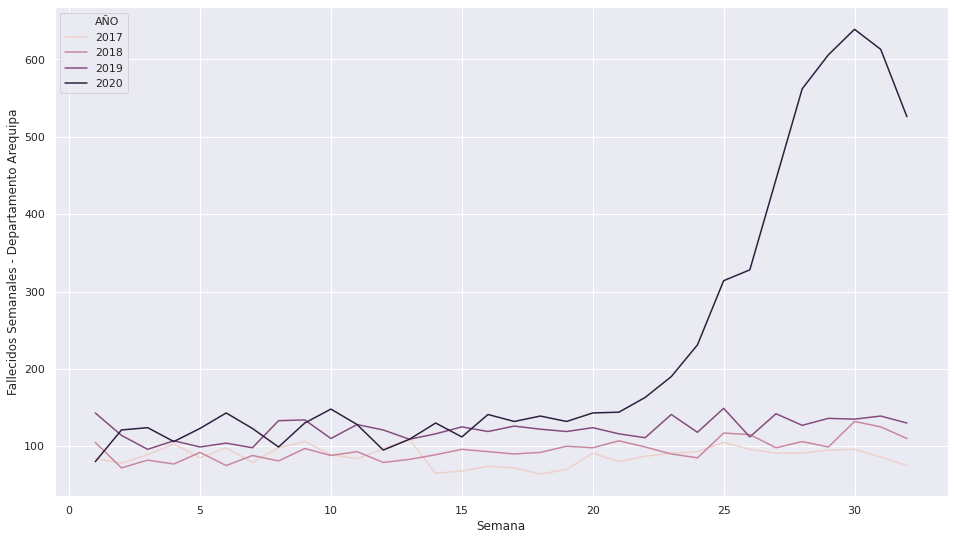

In [283]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')

plt.savefig('image_21.png')
plt.show()

In [284]:
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa.groupby(['DIAANUAL', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_arequipa.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia.to_frame().reset_index()
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['DIAANUAL'] <= 222 ]
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] <= '08-14' ]
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] != '02-29' ]
datos_sinadef_arequipa_dia

MESDIA   AÑO  Nº
0    01-01  2017  16
1    01-01  2018   8
2    01-01  2019  19
3    01-01  2020  15
4    01-02  2017  12
..     ...   ...  ..
900  08-13  2020  54
901  08-14  2017   9
902  08-14  2018  16
903  08-14  2019  22
904  08-14  2020  65

[904 rows x 3 columns]

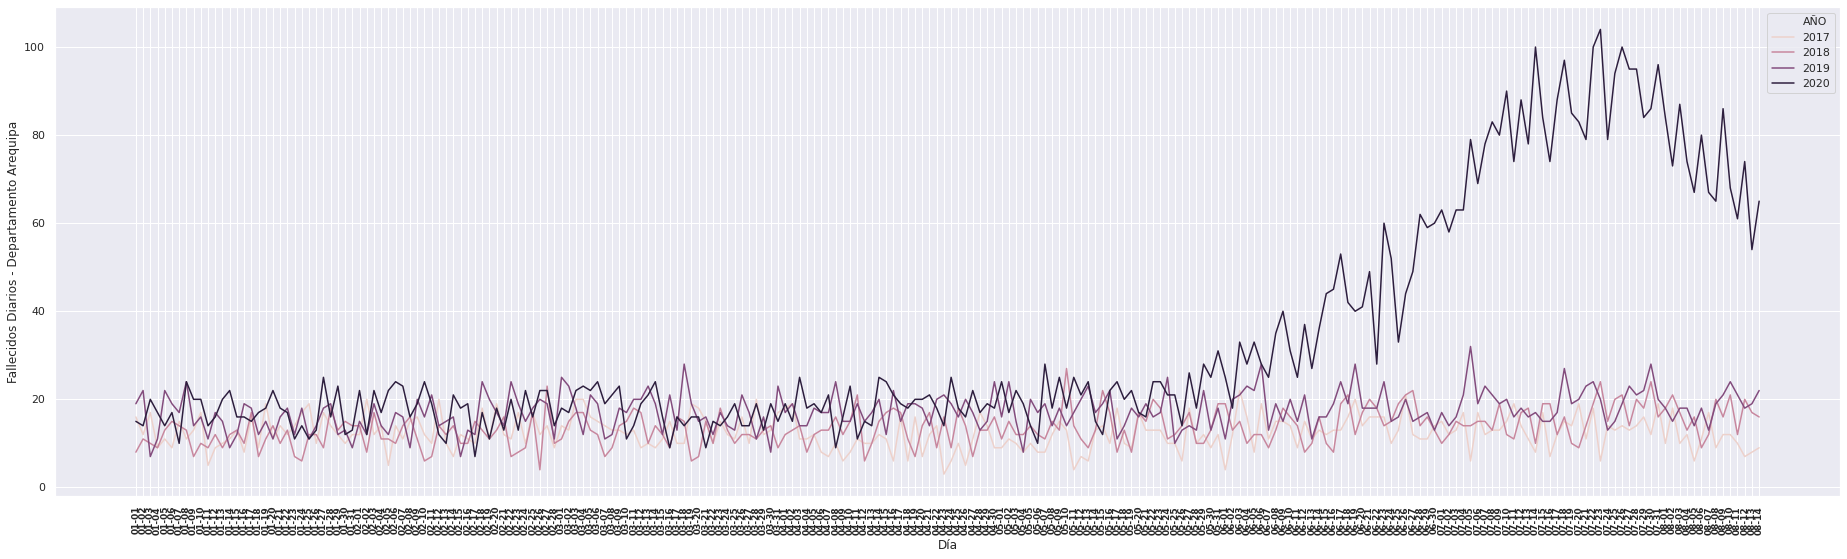

In [293]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

sns.lineplot(data=datos_sinadef_arequipa_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
plt.savefig('image_25.png')
plt.show()

In [286]:
datos_arequipa_semana = datos_arequipa.groupby(['week', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_semana = datos_arequipa_semana.to_frame().reset_index()
datos_arequipa_semana = datos_arequipa_semana[datos_arequipa_semana['week'] <= 32 ]

datos_arequipa_semana

week  year  fallecidos_diarios
0     18  2020                   4
1     19  2020                  10
2     20  2020                   7
3     21  2020                  10
4     22  2020                  20
5     23  2020                  18
6     24  2020                  48
7     25  2020                  83
8     26  2020                  79
9     27  2020                 113
10    28  2020                  83
11    29  2020                 212
12    30  2020                 151
13    31  2020                 137
14    32  2020                 194

In [287]:
datos_sinadef_arequipa_covid = datos_sinadef_arequipa[datos_sinadef_arequipa['CAUSA A (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA B (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA C (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA D (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA E (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA F (CIE-X)'].str.contains("U07") |
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("CORONAVIRUS")
                                                       ]

#display(df_sinadef_raw_arequipa_covid)

datos_sinadef_arequipa_covid['week'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.week
datos_sinadef_arequipa_covid['year'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.year
datos_sinadef_arequipa_covid = datos_sinadef_arequipa_covid.reset_index(drop=True)

datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_covid.groupby(['week', 'year'])['Nº'].count()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid.to_frame().reset_index()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid[(datos_sinadef_arequipa_semana_covid['week'] >= 18) & (datos_sinadef_arequipa_semana_covid['week'] <= 32)]

datos_sinadef_arequipa_semana_covid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


week  year   Nº
4     18  2020   10
5     19  2020   18
6     20  2020   14
7     21  2020   26
8     22  2020   54
9     23  2020   56
10    24  2020   89
11    25  2020  145
12    26  2020  166
13    27  2020  226
14    28  2020  275
15    29  2020  322
16    30  2020  344
17    31  2020  341
18    32  2020  297

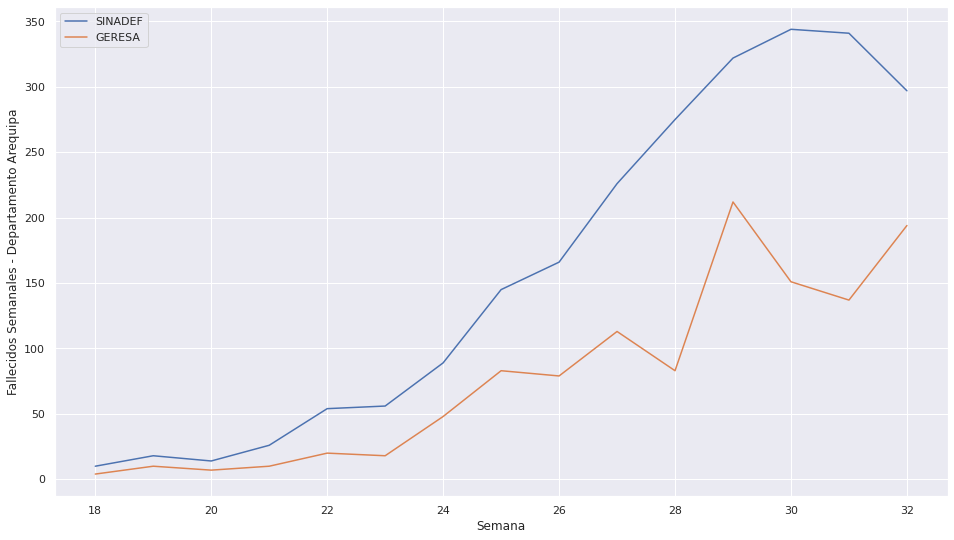

In [288]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana_covid, x = 'week', y = 'Nº', label='SINADEF', ax=ax1)
sns.lineplot(data=datos_arequipa_semana, x = 'week', y = 'fallecidos_diarios', label='GERESA', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')

plt.savefig('image_22.png')
plt.show()

In [289]:
datos_arequipa_dia = datos_arequipa.groupby(['mesdia', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_dia = datos_arequipa_dia.to_frame().reset_index()
datos_arequipa_dia = datos_arequipa_dia[datos_arequipa_dia['mesdia'] <= '08-14' ]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-09')]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-17')]
datos_arequipa_dia = datos_arequipa_dia.reset_index(drop=True)

datos_arequipa_dia.tail()

mesdia  year  fallecidos_diarios
99   08-10  2020                  25
100  08-11  2020                  40
101  08-12  2020                  39
102  08-13  2020                  25
103  08-14  2020                  19

In [290]:
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_covid.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.to_frame().reset_index()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid[(datos_sinadef_arequipa_dia_covid['MESDIA'] >= '05-01') & (datos_sinadef_arequipa_dia_covid['MESDIA'] <= '08-14')]
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.reset_index(drop=True)

datos_sinadef_arequipa_dia_covid.tail()

MESDIA   AÑO  Nº
99   08-10  2020  37
100  08-11  2020  39
101  08-12  2020  41
102  08-13  2020  32
103  08-14  2020  37

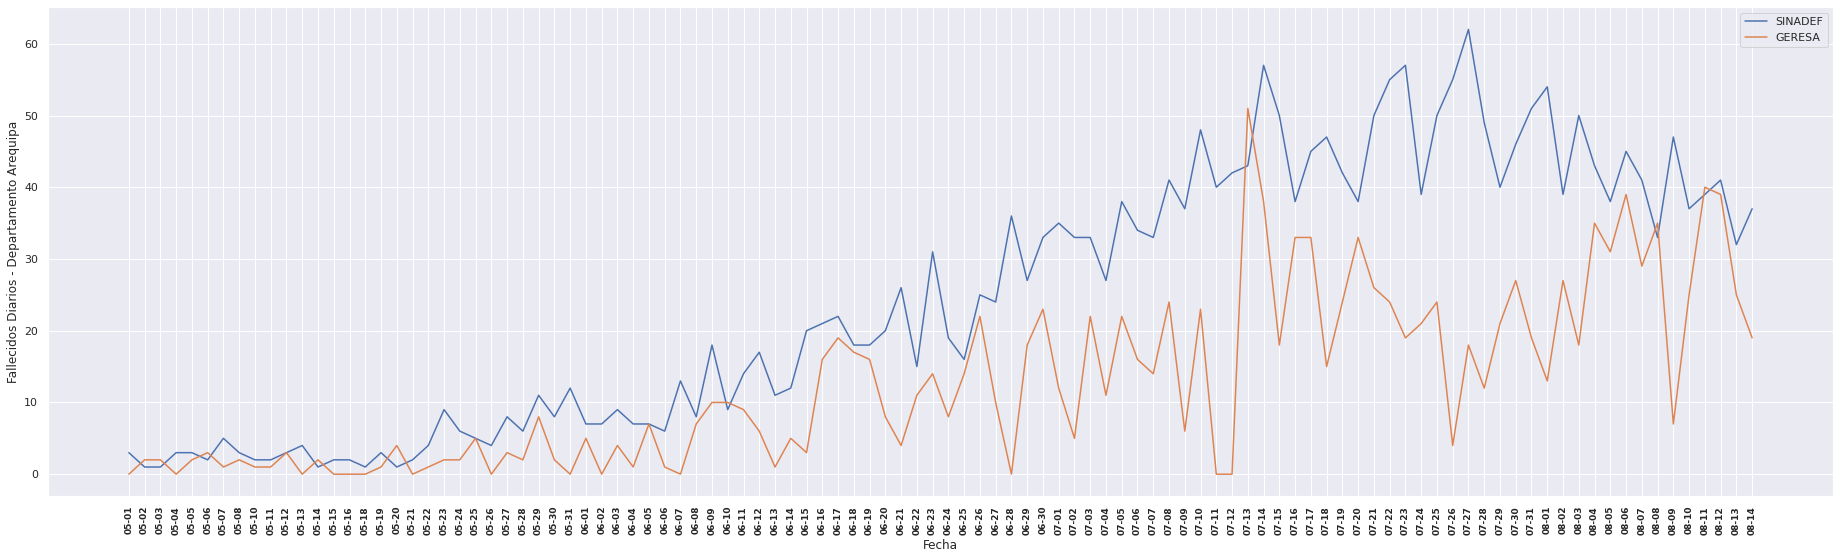

In [291]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

sns.lineplot(data=datos_sinadef_arequipa_dia_covid, x = 'MESDIA', y = 'Nº', label='SINADEF', ax=ax1)
sns.lineplot(data=datos_arequipa_dia, x = 'mesdia', y = 'fallecidos_diarios', label='GERESA', ax=ax1)

plt.xlabel('Fecha')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')

plt.savefig('image_22.png')
plt.show()

## Clustering

Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

### Initialize

In [232]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
    !pip install stop-words

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

from stop_words import get_stop_words

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [233]:
stop_words = get_stop_words('spanish')
punctuations = string.punctuation

# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

### Load Data

In [234]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

In [235]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

### Pre-processing

In [236]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample.replace('SIN REGISTRO', ' ')

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample[['DEBIDO A (CAUSA A)',
                                                                                     'CAUSA A (CIE-X)',
                                                                                     'DEBIDO A (CAUSA B)',
                                                                                     'CAUSA B (CIE-X)',
                                                                                     'DEBIDO A (CAUSA C)',
                                                                                     'CAUSA C (CIE-X)',
                                                                                     'DEBIDO A (CAUSA D)',
                                                                                     'CAUSA D (CIE-X)',
                                                                                     'DEBIDO A (CAUSA E)',
                                                                                     'CAUSA E (CIE-X)',
                                                                                     'DEBIDO A (CAUSA F)',
                                                                                     'CAUSA F (CIE-X)']]

datos_sinadef_arequipa_clustering_sample['all_features'] =  datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA A)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA A (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA B)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA B (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA C)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA C (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA D)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA D (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA E)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA E (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA F)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA F (CIE-X)']

datos_sinadef_arequipa_clustering_sample

DEBIDO A (CAUSA A) CAUSA A (CIE-X)  \
43                          TRAUMATISMO ENCEFALO CRANEANO            S069   
52                                  NEOPLASIA DE PANCREAS                   
167     IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...                   
221                                        CHOQUE SEPTICO            R572   
229                            INSUFICIENCIA RESPIRATORIA                   
...                                                   ...             ...   
133764                SINDROME INSUFICIENCIA RESPIRATORIA            J960   
133765             SINDROME DE INSUFICIENCIA RESPIRATORIA            J960   
133766                SINDROME INSUFICIENCIA RESPIRATORIA            J960   
133767                   INSUFICIENCIA RESPIRATORIA AGUDA            J960   
133768                   INSUFICIENCIA RESPIRATORIA AGUDA            J960   

                    DEBIDO A (CAUSA B) CAUSA B (CIE-X)  \
43      AHOGAMIENTO Y SUMERSIÓN EN RÍO            W698   
52                                                       
167                                                      
221                     BRONCONEUMONIA            J180   
229     ENFERMEDAD DE MEMBRANA HIALINA                   
...                                ...             ...   
133764                  NEUMONIA VIRAL            J129   
133765                   NEMONIA VIRAL            J129   
133766                  NEUMONIA VIRAL            J129   
133767                  NEUMONIA VIRAL            J129   
133768                       COVID -19            U071   

                       DEBIDO A (CAUSA C) CAUSA C (CIE-X) DEBIDO A (CAUSA D)  \
43                                                                             
52                                                                             
167                                                                            
221                    ENFERMEDAD POR VIH            B207                      
229     RECIÉN NACIDO DE PARTO PRETÉRMINO                                      
...                                   ...             ...                ...   
133764           COVID 19 CASO SOSPECHOSO            U072                      
133765           COVID 19 CASO SOSPECHOSO            U072                      
133766              COVID CASO CONFIRMADO            U071                      
133767             COVID NO IDENTIFICADO             U072                      
133768                                                                         

       CAUSA D (CIE-X) DEBIDO A (CAUSA E) CAUSA E (CIE-X) DEBIDO A (CAUSA F)  \
43                                                                             
52                                                                             
167                                                                            
221                                                                            
229                                                                            
...                ...                ...             ...                ...   
133764                                                                         
133765                                                                         
133766                                                                         
133767                                                                         
133768                                                                         

       CAUSA F (CIE-X)                                       all_features  
43                      TRAUMATISMO ENCEFALO CRANEANO S069 AHOGAMIENTO...  
52                            NEOPLASIA DE PANCREAS                        
167                     IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...  
221                     CHOQUE SEPTICO R572 BRONCONEUMONIA J180 ENFERM...  
229                     INSUFICIENCIA RESPIRATORIA   ENFERMEDAD DE MEM...  
...                ...                 

### Clean

In [237]:
datos_sinadef_arequipa_clustering_sample["processed_text"] = datos_sinadef_arequipa_clustering_sample['all_features'].progress_apply(spacy_tokenizer)

100%|██████████| 7564/7564 [00:32<00:00, 231.71it/s]


### Vectorize

In [238]:
text = datos_sinadef_arequipa_clustering_sample['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(7564, 3332)

### PCA

In [239]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(7564, 1177)

### Elbow Method

In [240]:
# run kmeans with many different k
"""
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow_departamento_arequipa_2020.png')
plt.show()
"""

"\ndistortions = []\nK = range(2, 50)\nfor k in K:\n    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)\n    k_means.fit(X_reduced)\n    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])\n    print('Found distortion for {} clusters'.format(k))\n\nX_line = [K[0], K[-1]]\nY_line = [distortions[0], distortions[-1]]\n\n# Plot the elbow\nplt.plot(K, distortions, 'b-')\nplt.plot(X_line, Y_line, 'r')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.savefig('elbow_departamento_arequipa_2020.png')\nplt.show()\n"

### K-means over K calculated

In [241]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
datos_sinadef_arequipa_clustering_sample['y'] = y_pred

### TSNE Method

In [242]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7564 samples in 3.018s...
[t-SNE] Computed neighbors for 7564 samples in 396.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7564
[t-SNE] Computed conditional probabilities for sample 2000 / 7564
[t-SNE] Computed conditional probabilities for sample 3000 / 7564
[t-SNE] Computed conditional probabilities for sample 4000 / 7564
[t-SNE] Computed conditional probabilities for sample 5000 / 7564
[t-SNE] Computed conditional probabilities for sample 6000 / 7564
[t-SNE] Computed conditional probabilities for sample 7000 / 7564
[t-SNE] Computed conditional probabilities for sample 7564 / 7564
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.758072
[t-SNE] KL divergence after 1000 iterations: 1.587977


### Plot Clusters

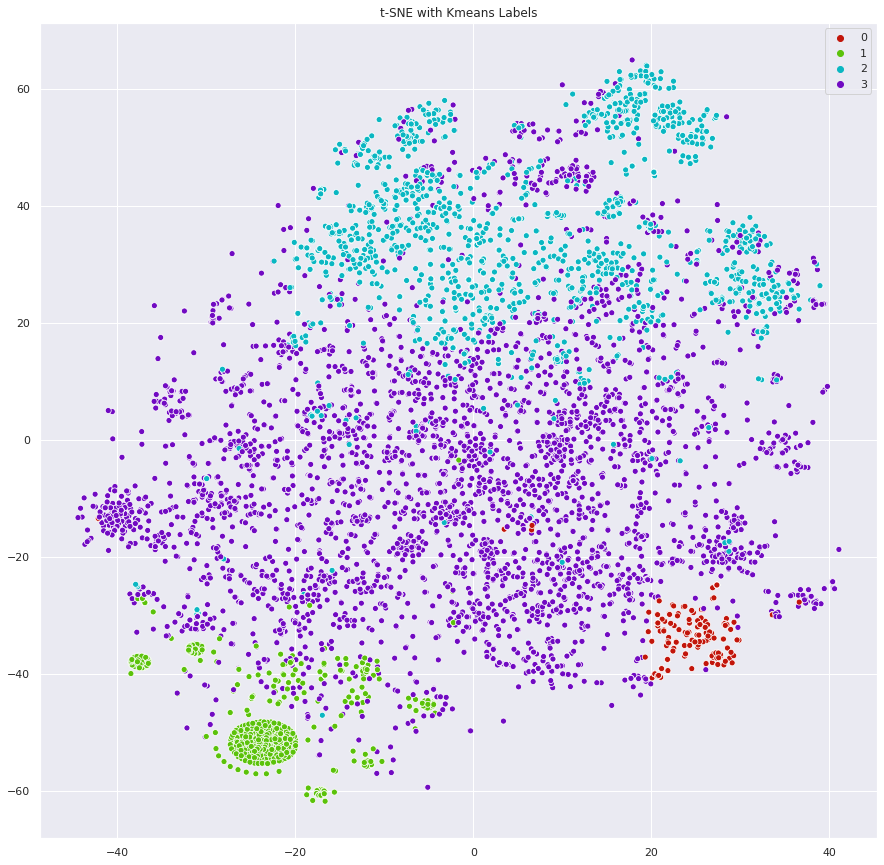

In [243]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("image_23.png")
plt.show()

### Topic Modeling

In [244]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante',
                            'antes', 'como', 'con', 'contra', 'cual', 'cuando',
                            'de', 'del', 'desde', 'donde', 'durante', 'e', 'el',
                            'ella', 'ellas', 'ellos', 'en', 'entre', 'era',
                            'erais', 'eran', 'eras', 'eres', 'es', ...],
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [245]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(datos_sinadef_arequipa_clustering_sample.loc[datos_sinadef_arequipa_clustering_sample['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
len(vectorized_data)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


4

In [246]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [247]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

len(clusters_lda_data[0])

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


292

In [248]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

display(all_keywords[0][:10])
len(all_keywords)

['arterial',
 'insuficiencia',
 'ncer',
 'hipertension',
 'nica',
 'neumonia',
 'fibrosis',
 'pulmonar',
 'cirrosis',
 'hepatica']

4

In [249]:
f=open('topicos.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

### Verifying Topics

In [294]:
ver_topico = 2
df = datos_sinadef_arequipa_clustering_sample[datos_sinadef_arequipa_clustering_sample['y'] == ver_topico]
display(df)

df.to_csv('df.csv')

df['processed_text'].to_csv('palabras_cluster_' + str(ver_topico) + '.txt', header=False, index=False)

from collections import Counter
results = Counter()
df['processed_text'].str.lower().str.split().apply(results.update)
print(results)

DEBIDO A (CAUSA A) CAUSA A (CIE-X)  \
446                 INSUFICIENCIA RESPIRATORIA            J80X   
3236          INSUFICIENCIA RESPIRATORIA AGUDA                   
6322          INSUFICIENCIA RESPIRATORIA AGUDA            J960   
7852          INSUFICIENCIA RESPIRATORIA AGUDA            J960   
8362                INSUFICIENCIA RESPIRATORIA            J80X   
...                                        ...             ...   
133764     SINDROME INSUFICIENCIA RESPIRATORIA            J960   
133765  SINDROME DE INSUFICIENCIA RESPIRATORIA            J960   
133766     SINDROME INSUFICIENCIA RESPIRATORIA            J960   
133767        INSUFICIENCIA RESPIRATORIA AGUDA            J960   
133768        INSUFICIENCIA RESPIRATORIA AGUDA            J960   

       DEBIDO A (CAUSA B) CAUSA B (CIE-X)        DEBIDO A (CAUSA C)  \
446                                                                   
3236             NEUMONIA                                             
6322             NEUMONIA            J189                             
7852             NEUMONIA            J189                             
8362                                                                  
...                   ...             ...                       ...   
133764     NEUMONIA VIRAL            J129  COVID 19 CASO SOSPECHOSO   
133765      NEMONIA VIRAL            J129  COVID 19 CASO SOSPECHOSO   
133766     NEUMONIA VIRAL            J129     COVID CASO CONFIRMADO   
133767     NEUMONIA VIRAL            J129    COVID NO IDENTIFICADO    
133768          COVID -19            U071                             

       CAUSA C (CIE-X) DEBIDO A (CAUSA D) CAUSA D (CIE-X) DEBIDO A (CAUSA E)  \
446                                                                            
3236                                                                           
6322                                                                           
7852                                                                           
8362                                                                           
...                ...                ...             ...                ...   
133764            U072                                                         
133765            U072                                                         
133766            U071                                                         
133767            U072                                                         
133768                                                                         

       CAUSA E (CIE-X) DEBIDO A (CAUSA F) CAUSA F (CIE-X)  \
446                                                         
3236                                                        
6322                                                        
7852                                                        
8362                                                        
...                ...                ...             ...   
133764                                                      
133765                                                      
133766                                                      
133767                                                      
133768                                                      

                                             all_features  \
446     INSUFICIENCIA RESPIRATORIA J80X               ...   
3236    INSUFICIENCIA RESPIRATORIA AGUDA   NEUMONIA   ...   
6322    INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...   
7852    INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...   
8362    INSUFICIENCIA RESPIRATORIA J80X               ...   
...                                                   ...   
133764  SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...   
133765  SINDROME DE INSUFICIENCIA RESPIRATORIA J960 NE...   
133766  SINDROME INSUFICIENCIA RESPIRATORIA J960 NEUMO...   
133767  INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...   
133768  INSUFICIE

Counter({'respiratoria': 2087, 'insuficiencia': 1876, 'neumonia': 1506, 'covid': 1464, 'j960': 1327, 'u071': 1220, 'aguda': 1150, '19': 1141, 'u072': 745, 'virus': 478, 'j80x': 459, 'identificado': 445, 'viral': 334, 'severa': 324, 'infeccion': 303, 'sars': 291, 'j969': 258, 'dificultad': 246, 'sindrome': 238, 'j129': 237, '2': 230, 'covid-19': 216, 'j189': 211, 'arterial': 203, 'i10x': 194, 'hipertension': 188, 'atipica': 185, 'cov': 182, 'diabetes': 171, 'mellitus': 167, 'j128': 150, 'adulto': 143, 'coronavirus': 137, 'j22x': 130, 'obesidad': 129, 'covid19': 128, 'falla': 121, 'sospechoso': 108, 'caso': 104, 'infección': 98, 'e669': 94, 'especificada': 92, 'neumonía': 86, 'renal': 86, 'cov2': 82, 'multiorganica': 80, 'shock': 72, 'r579': 72, 'confirmado': 65, 'respiratorio': 64, 'enfermedad': 62, 'j180': 62, 'e119': 60, 'síndrome': 55, 'j168': 44, 'n179': 43, 'sepsis': 42, 'b972': 42, 'bilateral': 40, 'j159': 36, 'pulmonar': 36, 'a419': 34, 'probable': 34, 'cronica': 32, 'distres': 3

![](https://drive.google.com/uc?export=view&id=1mT00AP58ek6SKbZpsW3bXZjlVO-5W56T)


In [251]:
from google.colab import files
for i in range(1,24):
    files.download('image_' + str(i) + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Varios

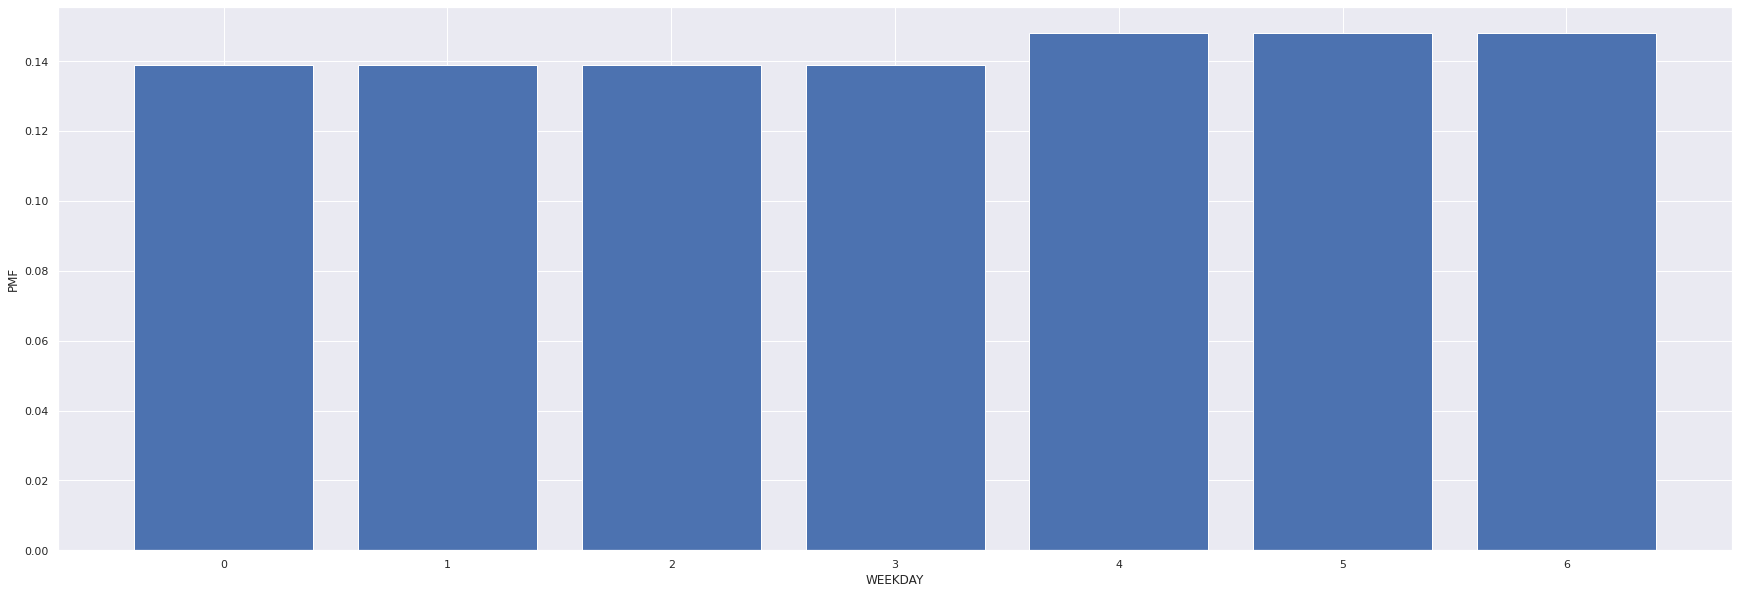

In [252]:
metododx = datos_arequipa['weekday']
plt.figure(figsize=(30,10))
Pmf.from_seq(metododx).bar()

plt.xlabel('WEEKDAY')
plt.ylabel('PMF')
plt.show()

# Estudios de correlacion y regresion

In [253]:
datos_arequipa.tail()

0           total_muestras  casos_positivos  casos_negativos  \
date                                                           
2020-08-12          471217            70558           400597   
2020-08-13          480496            72714           407738   
2020-08-14          487886            74465           413347   
2020-08-15          496331            76299           420006   
2020-08-16          502634            77804           424794   

0           espera_resultado  defunciones  recuperados  \
date                                                     
2020-08-12                62         1288        42208   
2020-08-13                44         1313        43629   
2020-08-14                74         1332        43905   
2020-08-15                26         1340        45334   
2020-08-16                36         1347        46428   

0           hospitalizados_positivos  hospitalizados_sospechosos  \
date                                                               
2020-08-12                       497                         292   
2020-08-13                       485                         302   
2020-08-14                       486                         277   
2020-08-15                       480                         260   
2020-08-16                       474                         294   

0           uci_positivos  uci_sospechosos  defunciones_minsa  \
date                                                            
2020-08-12             41               28                478   
2020-08-13             44               28                495   
2020-08-14             43               28                514   
2020-08-15             42               27                522   
2020-08-16             43               29                529   

0           defunciones_essalud  defunciones_clinicas  defunciones_domicilio  \
date                                                                           
2020-08-12                  744                    15                     41   
2020-08-13                  751                    16                     41   
2020-08-14                  751                    16                     41   
2020-08-15                  751                    16                     41   
2020-08-16                  751                    16                     41   

0           defunciones_sanidades  dia  weekday  week  year  muestras_diarias  \
date                                                                            
2020-08-12                     10  103        2    33  2020              7998   
2020-08-13                     10  104        3    33  2020              9279   
2020-08-14                     10  105        4    33  2020              7390   
2020-08-15                     10  106        5    33  2020              8445   
2020-08-16                     10  107        6    33  2020              6303   

0           confirmados_diarios  fallecidos_diarios  recuperados_diarios  \
date                                                                       
2020-08-12                 1964                  39                 1739   
2020-08-13                 2156                  25                 1421   
2020-08-14                 1751                  19                  276   
2020-08-15                 1834                   8                 1429   
2020-08-16                 1505                   7                 1094   

0           hospitalizados_positivos_diarios  uci_positivos_diarios  \
date                                                                  
2020-08-12                                60                      4   
2020-08-13                               -12                      3   
2020-08-14                                 1                     -1   
2020-08-15                                -6                     -1   
2020-08-16                                -6                      1   

0           positividad mesdia  activos  
date     

In [254]:
datos_arequipa.describe()

0      total_muestras  casos_positivos  casos_negativos  espera_resultado  \
count      108.000000       108.000000       108.000000        108.000000   
mean    190356.666667     20585.777778    169728.138889         40.101852   
std     150797.765389     22623.812617    128883.459241         49.491610   
min      14208.000000       655.000000     13552.000000          0.000000   
25%      53268.500000      3089.750000     50151.750000          8.000000   
50%     150805.500000      9773.500000    140887.500000         23.000000   
75%     311032.000000     33296.500000    277707.250000         53.250000   
max     502634.000000     77804.000000    424794.000000        258.000000   

0      defunciones   recuperados  hospitalizados_positivos  \
count   108.000000    108.000000                108.000000   
mean    413.990741  10298.185185                270.481481   
std     416.111562  12760.286519                170.750158   
min      15.000000     83.000000                 40.000000   
25%      55.500000   1265.000000                 85.500000   
50%     244.000000   4427.000000                293.500000   
75%     741.500000  14873.250000                421.000000   
max    1347.000000  46428.000000                668.000000   

0      hospitalizados_sospechosos  uci_positivos  uci_sospechosos  \
count                  108.000000     108.000000       108.000000   
mean                   150.018519      41.694444        11.731481   
std                    111.524439      13.741579         7.572215   
min                      0.000000      18.000000         0.000000   
25%                     41.000000      27.000000         5.000000   
50%                    145.500000      45.500000        13.000000   
75%                    247.000000      52.000000        16.000000   
max                    349.000000      74.000000        29.000000   

0      defunciones_minsa  defunciones_essalud  defunciones_clinicas  \
count         108.000000           108.000000            108.000000   
mean          142.055556           231.231481              5.518519   
std           150.027339           245.868197              5.540811   
min             0.000000             0.000000              0.000000   
25%            13.000000            32.500000              0.000000   
50%            84.000000           113.000000              5.000000   
75%           226.500000           425.500000             12.000000   
max           529.000000           751.000000             16.000000   

0      defunciones_domicilio  defunciones_sanidades        dia     weekday  \
count             108.000000             108.000000  108.00000  108.000000   
mean               13.259259               3.546296   53.50000    3.055556   
std                17.486641               4.014889   31.32092    2.013196   
min                 0.000000               0.000000    0.00000    0.000000   
25%                 0.000000               0.000000   26.75000    1.000000   
50%                 3.000000               2.000000   53.50000    3.000000   
75%                38.000000               8.250000   80.25000    5.000000   
max                41.000000              10.000000  107.00000    6.000000   

0            week    year  muestras_diarias  confirmados_diarios  \
count  108.000000   108.0        108.000000           108.000000   
mean    25.777778  2020.0       4522.462963           714.342593   
std      4.479096     0.0       2644.431771           711.245021   
min     18.000000  2020.0          0.000000             0.000000   
25%     22.000000  2020.0       2387.250000           133.500000   
50%     26.000000  2020.0       4238.000000           449.000000   
75%     30.000000  2020.0       6708.250000          1374.750000   
max     33.000000  2020.0      10143.000000          2501.000000   

0      fallecidos_diarios  recuperados_diarios  \
count          108.000000            108.00000   
mean            12.333333            429.12037   
std             11.

In [255]:
datos_arequipa.corr()

0                                 total_muestras  casos_positivos  \
0                                                                   
total_muestras                          1.000000         0.973054   
casos_positivos                         0.973054         1.000000   
casos_negativos                         0.999187         0.962967   
espera_resultado                        0.058417        -0.027186   
defunciones                             0.990086         0.993377   
recuperados                             0.947781         0.992957   
hospitalizados_positivos                0.890452         0.785903   
hospitalizados_sospechosos              0.890257         0.826876   
uci_positivos                           0.531189         0.344315   
uci_sospechosos                         0.703743         0.657518   
defunciones_minsa                       0.951428         0.968425   
defunciones_essalud                     0.954235         0.967240   
defunciones_clinicas                    0.922817         0.873733   
defunciones_domicilio                   0.917886         0.922360   
defunciones_sanidades                   0.941302         0.920301   
dia                                     0.975965         0.906327   
weekday                                 0.033267         0.046159   
week                                    0.972809         0.902416   
year                                         NaN              NaN   
muestras_diarias                        0.813778         0.726255   
confirmados_diarios                     0.892106         0.867123   
fallecidos_diarios                      0.719613         0.651045   
recuperados_diarios                     0.860406         0.878521   
hospitalizados_positivos_diarios       -0.015315        -0.020851   
uci_positivos_diarios                  -0.065078        -0.061323   
positividad                             0.897434         0.883062   
activos                                 0.984954         0.988248   

0                                 casos_negativos  espera_resultado  \
0                                                                     
total_muestras                           0.999187          0.058417   
casos_positivos                          0.962967         -0.027186   
casos_negativos                          1.000000          0.072765   
espera_resultado                         0.072765          1.000000   
defunciones                              0.984040          0.010257   
recuperados                              0.934641         -0.029865   
hospitalizados_positivos                 0.903779          0.197373   
hospitalizados_sospechosos               0.896433          0.223724   
uci_positivos                            0.560919          0.329811   
uci_sospechosos                          0.707887          0.356114   
defunciones_minsa                        0.943196          0.066444   
defunciones_essalud                      0.946697          0.038017   
defunciones_clinicas                     0.926317          0.161349   
defunciones_domicilio                    0.912057         -0.065548   
defunciones_sanidades                    0.939807          0.060391   
dia                                      0.982747          0.139305   
weekday                                  0.030714          0.012699   
week                                     0.979748          0.138344   
year                                          NaN               NaN   
muestras_diarias                         0.824570          0.172323   
confirmados_diarios                      0.891579          0.051415   
fallecidos_diarios                       0.727734          0.089823   
recuperados_diarios                      0.852539         -0.058979   
hospitalizados_positivos_diarios        -0.014285         -0.031126   
uci_positivos_diarios                   -0.065494          0.037035   
positividad                              0.895036          0.059870   
activos   

In [256]:
datos_arequipa['WEEKDAY'] = datos_arequipa.index.weekday

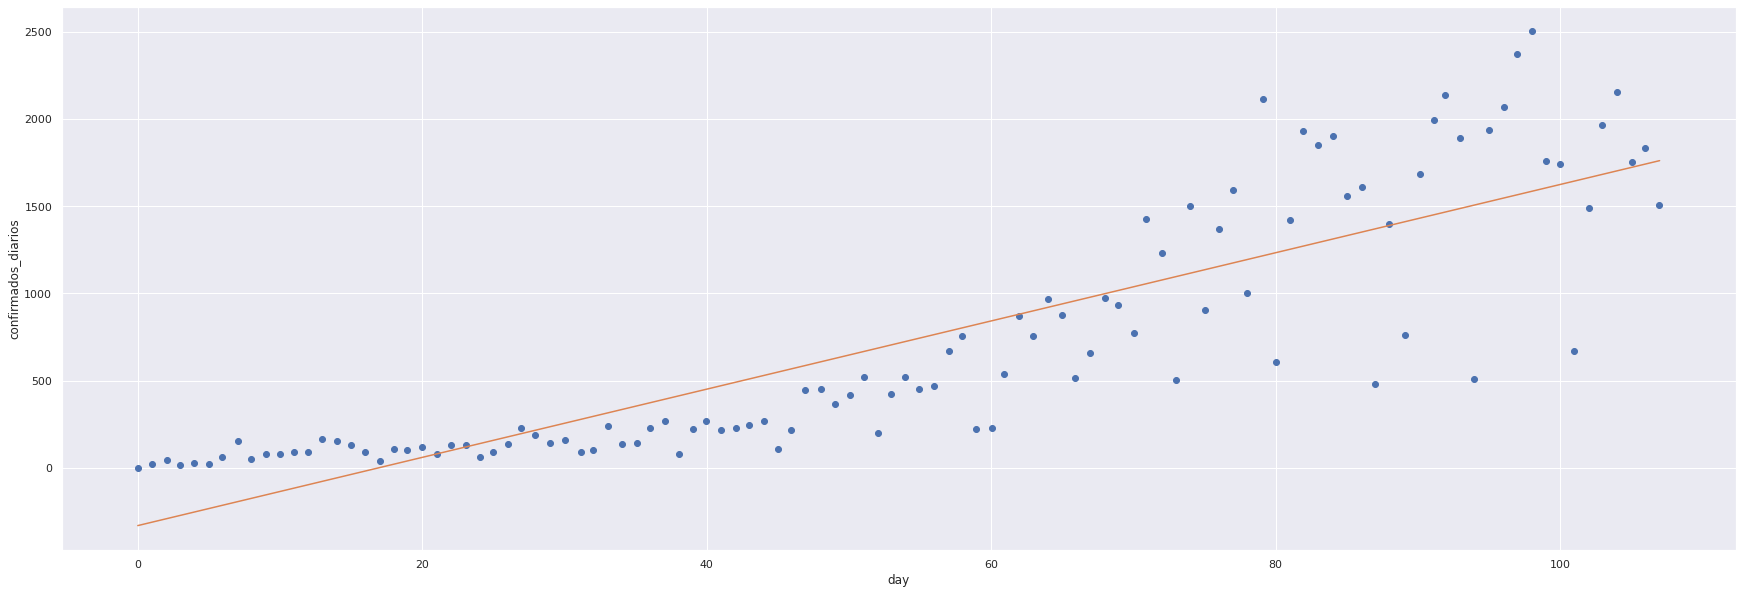

In [257]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['confirmados_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('confirmados_diarios')
plt.show()

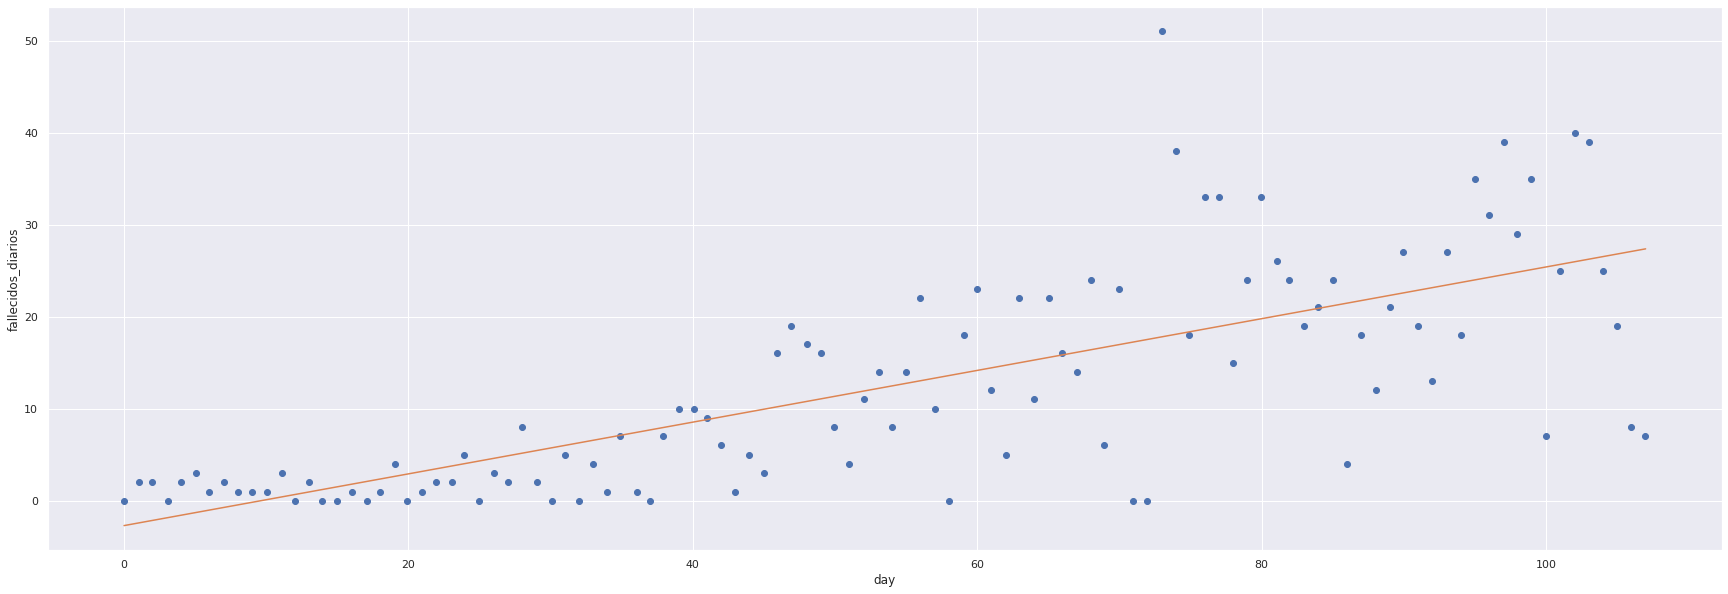

In [258]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('fallecidos_diarios')
plt.show()

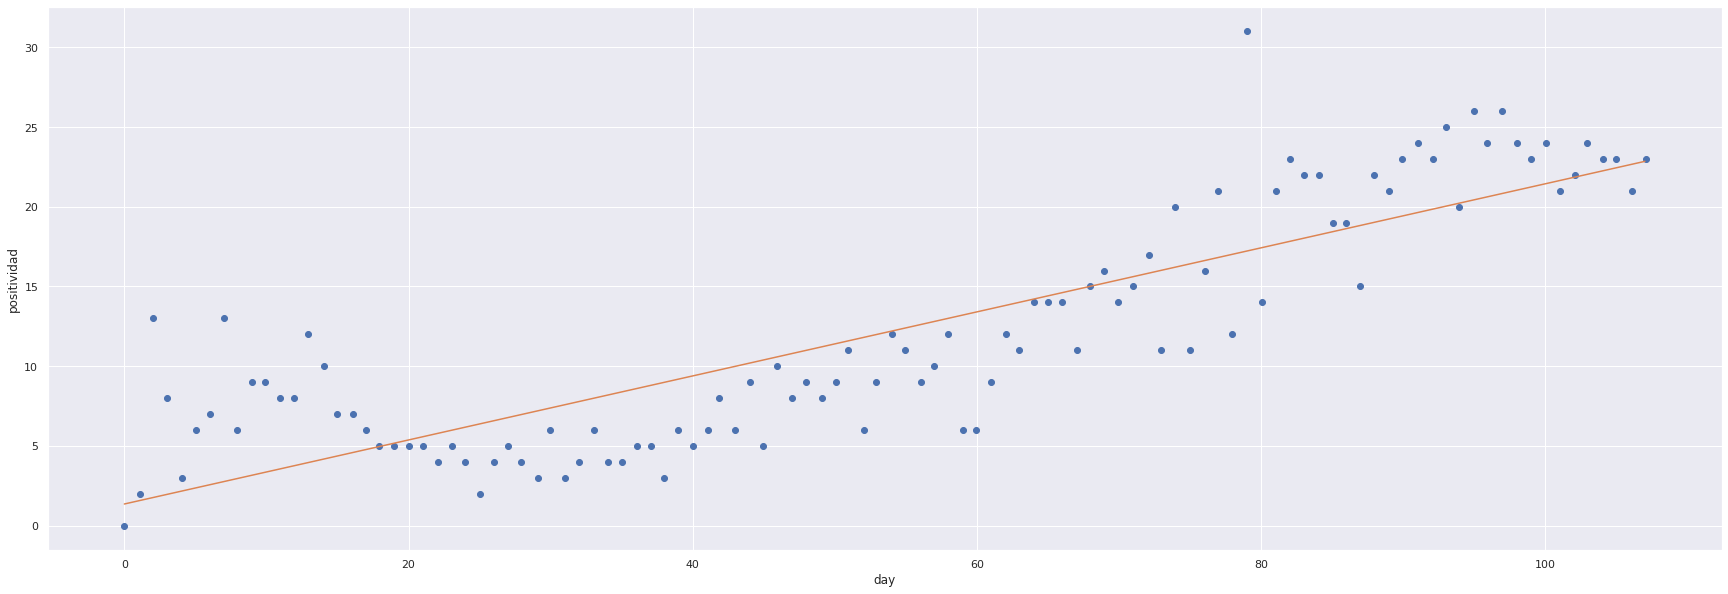

In [259]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['positividad']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('positividad')
plt.show()

In [260]:
import statsmodels.formula.api as smf

results = smf.ols('positividad ~ dia', data=datos_arequipa).fit()
results.params

Intercept    1.354400
dia          0.200887
dtype: float64

Cada dia la linea de regresion aumenta un 0.01

In [261]:
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2
datos_arequipa['dia3'] = datos_arequipa['dia'] ** 3

model = smf.ols('positividad ~ dia + dia2 + dia3', data=datos_arequipa)

results = model.fit()
results.params

Intercept    9.397609
dia         -0.438512
dia2         0.011106
dia3        -0.000053
dtype: float64

In [262]:
df = pd.DataFrame()
df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2
df['dia3'] = df['dia'] ** 3

pred12 = results.predict(df)

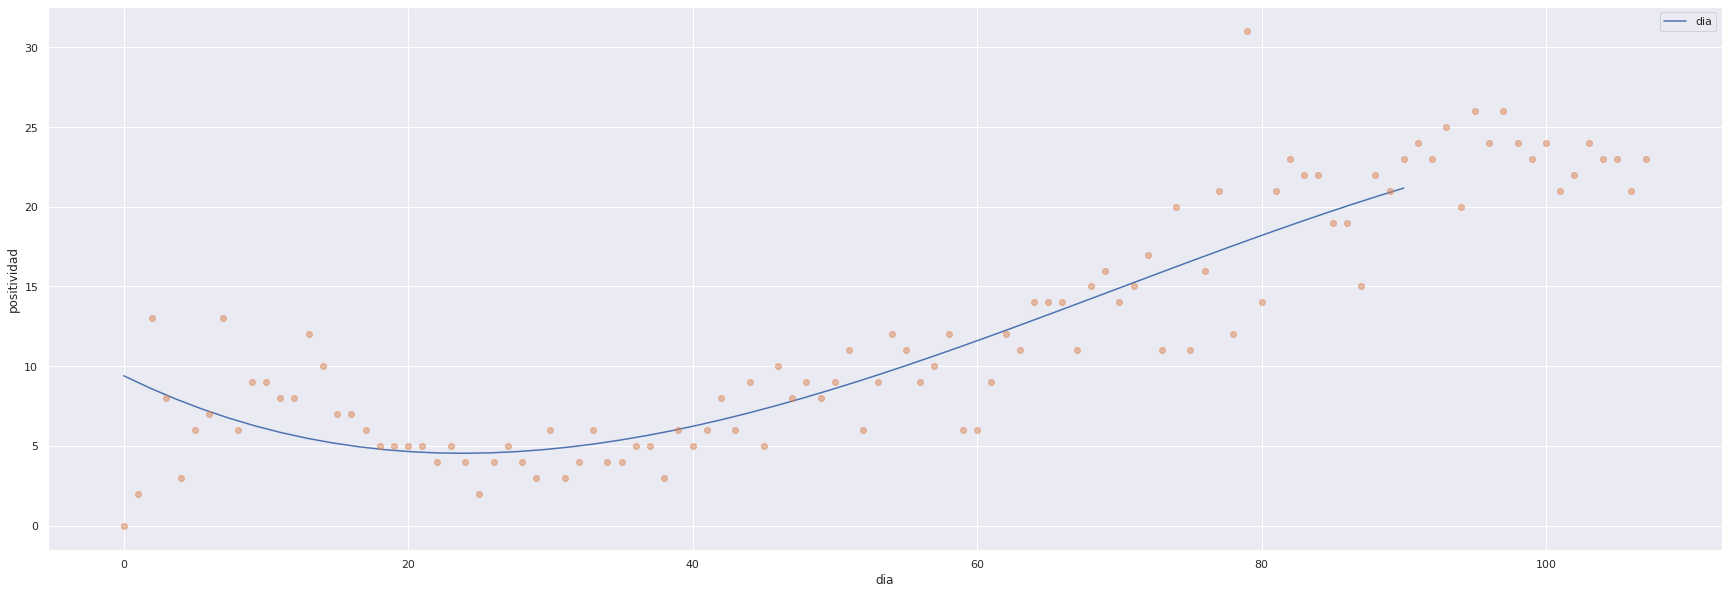

In [263]:
plt.figure(figsize=(30,10))
plt.plot(df['dia'], pred12, label='dia')
plt.plot(datos_arequipa['dia'], datos_arequipa['positividad'], 'o', alpha=0.5)

plt.xlabel('dia')
plt.ylabel('positividad')
plt.legend()
plt.show()

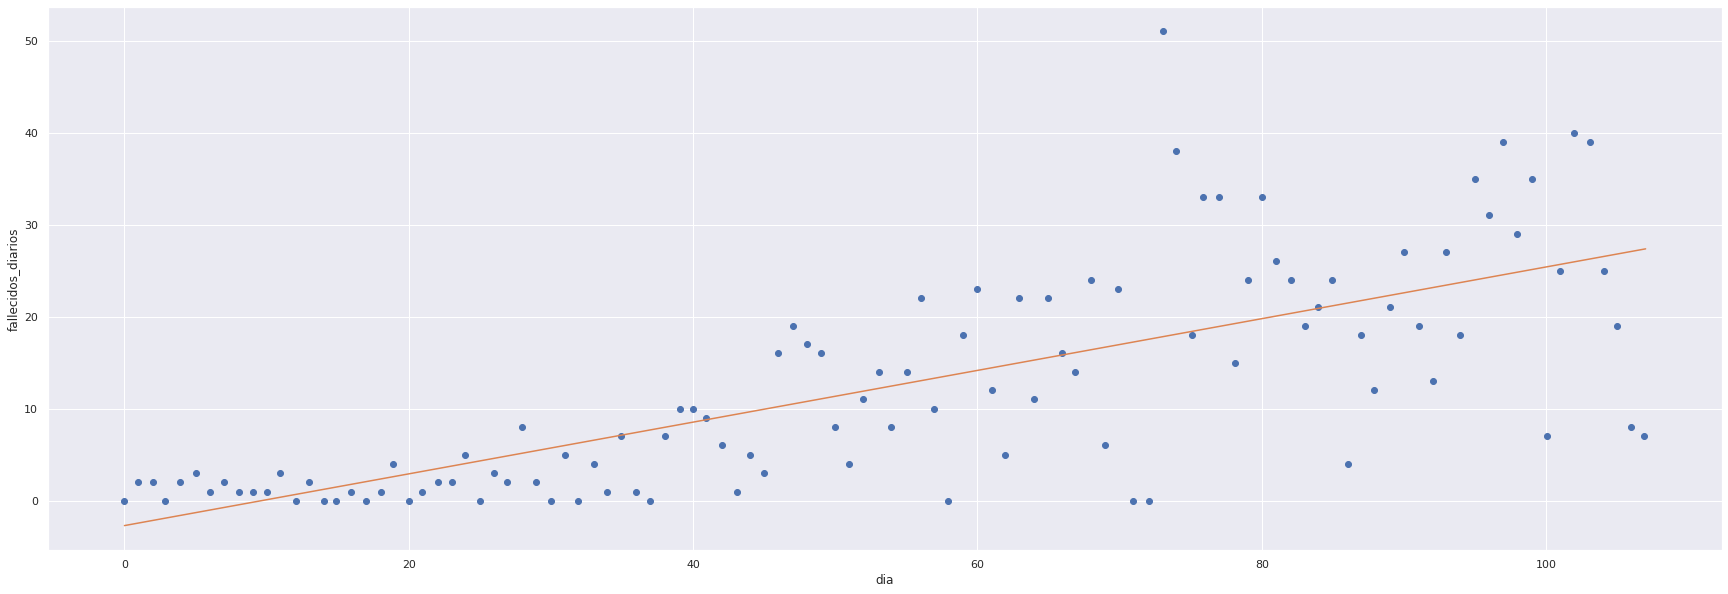

In [264]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('dia')
plt.ylabel('fallecidos_diarios')
plt.show()

In [265]:
results = smf.ols('fallecidos_diarios ~ dia + positividad', data=datos_arequipa).fit()
results.params

Intercept     -3.020825
dia            0.234059
positividad    0.234016
dtype: float64

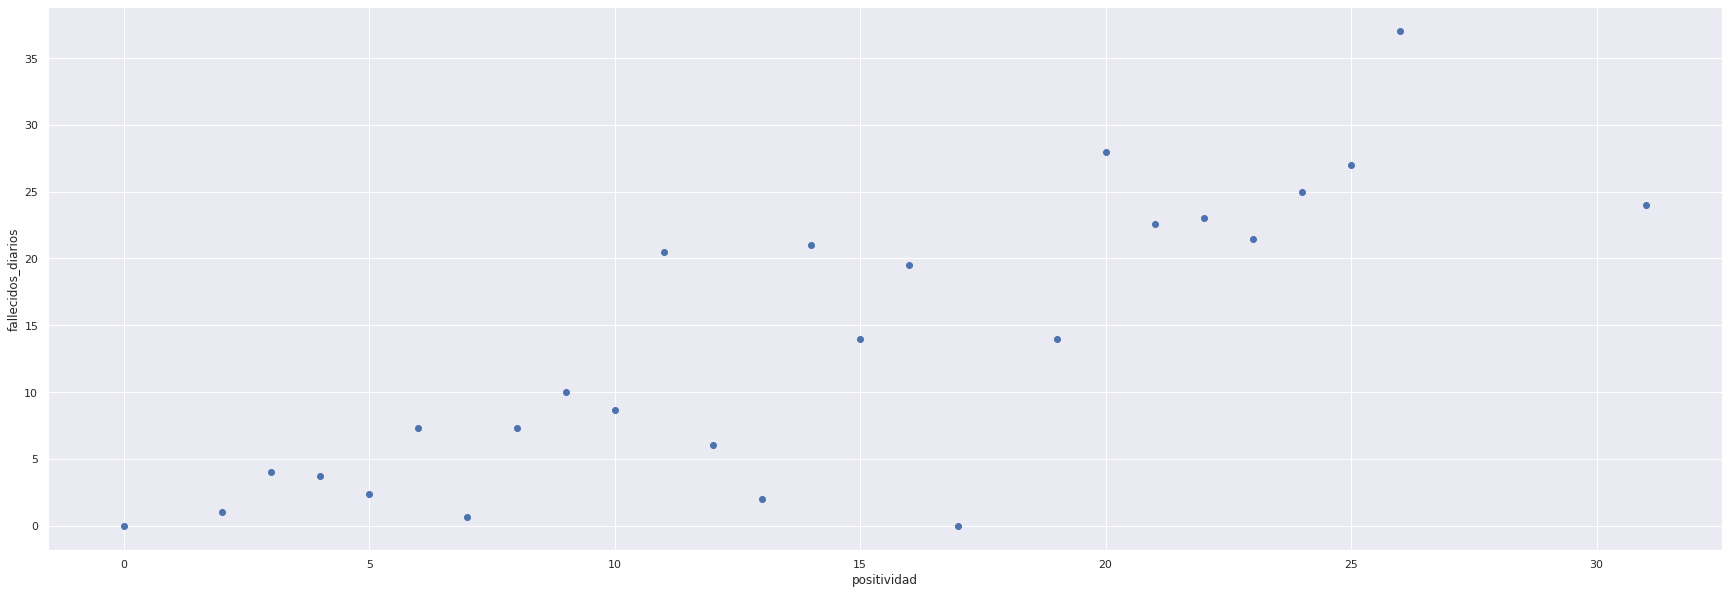

In [266]:
#grouped = datos_arequipa.groupby('dia')
grouped = datos_arequipa.groupby('positividad')
mean_positividad_by_weekday = grouped['fallecidos_diarios'].mean()
plt.figure(figsize=(30,10))
plt.plot(mean_positividad_by_weekday, 'o')

plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.show()

In [267]:
datos_arequipa['positividad2'] = datos_arequipa['positividad'] ** 2
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2

model = smf.ols('fallecidos_diarios ~ dia + dia2 + positividad + positividad2', data=datos_arequipa)
results = model.fit()
results.params

Intercept      -3.915585
dia             0.320182
dia2           -0.001019
positividad     0.102992
positividad2    0.008856
dtype: float64

In [268]:
df = pd.DataFrame()
df['positividad'] = np.linspace(0, 13)
df['positividad2'] = df['positividad'] ** 2

df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2

pred12 = results.predict(df)

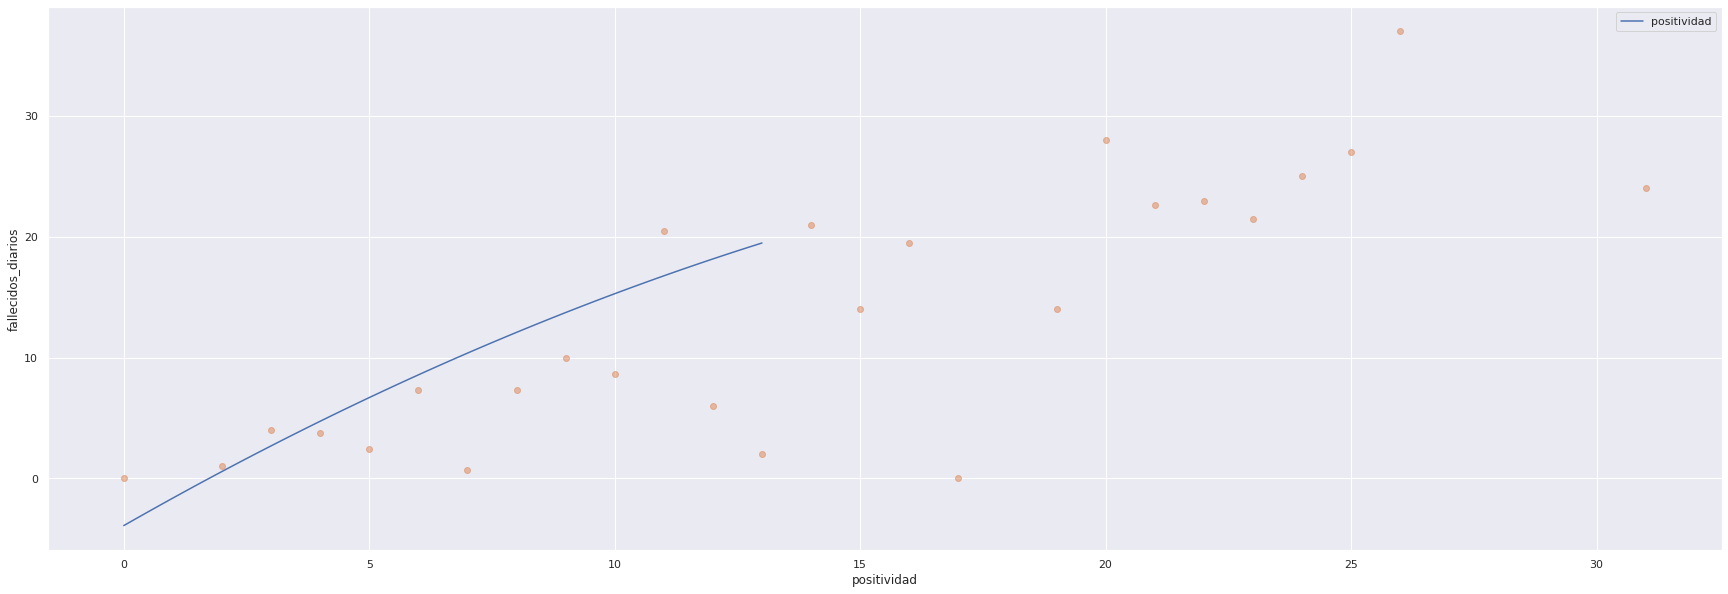

In [269]:
#plt.plot(df['dia'], pred12, label='dia')
plt.figure(figsize=(30,10))
plt.plot(df['positividad'], pred12, label='positividad')
plt.plot(mean_positividad_by_weekday, 'o', alpha=0.5)

#plt.xlabel('dia')
plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.legend()
plt.show()